## Импорты.

In [ ]:
!pip install -q pycm==3.4

     |████████████████████████████████| 66 kB 2.6 MB/s 
     |████████████████████████████████| 590 kB 11.4 MB/s 


In [ ]:
!pip install -q imgaug==0.4.0

     |████████████████████████████████| 948 kB 4.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
!pip install -q optuna

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 210 kB 44.5 MB/s 
     |████████████████████████████████| 81 kB 7.7 MB/s 
     |████████████████████████████████| 78 kB 5.7 MB/s 
     |████████████████████████████████| 146 kB 44.0 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 112 kB 45.3 MB/s 


In [ ]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import torch
from torch import nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torchvision.transforms as tt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm, tqdm_notebook
import pycm
import seaborn as sns
from copy import deepcopy
import cv2
import imgaug.augmenters as iaa
from copy import deepcopy
from torchvision import transforms as tt
from torchvision import models
import optuna
from sklearn.metrics import classification_report

## Вынесем сюда все константы.

In [ ]:
resize_h, resize_w = 256, 256

In [ ]:
means = [0.7606, 0.5825, 0.4934]
stds = [0.1954, 0.1941, 0.2007]

In [ ]:
batch_size = 5

In [ ]:
epochs = 20

In [ ]:
classes = ['Typical Nevus', 'Atyical Nevus', 'Melanoma']

In [ ]:
colors = ['gold', 'olivedrab', 'darkorange', 'maroon', 'indigo', 'brown', 'blue',
          'gray', 'tomato', 'olive', 'lime', 'steelblue', 'hotpink', 'cyan', 
          'slategray', 'orangered', 'darkviolet']

In [ ]:
augs_for_exp = [iaa.flip.Flipud(1)]

In [ ]:
augs_for_complication = [iaa.AverageBlur(k=(2, 11))]

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
DEVICE

device(type='cuda')

## Собираем массив с изображениями.

In [ ]:
images = {}
from skimage.io import imread
root = '/content/drive/MyDrive/my_bachelor_diploma/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images[root[-24:-18]] = (imread(os.path.join(root, files[0])))

In [ ]:
len(images)

200

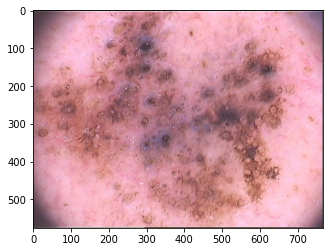

In [ ]:
plt.imshow(list(images.values())[0])

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/my_bachelor_diploma/data/X_train.csv', index_col=0)
X_val = pd.read_csv('/content/drive/MyDrive/my_bachelor_diploma/data/X_val.csv', index_col=0)

In [ ]:
train_images_array = list()
for df_ind in X_train.index:
  train_images_array.append(images[X_train.loc[df_ind, 'name']])

val_images_array = list()
for df_ind in X_val.index:
  val_images_array.append(images[X_val.loc[df_ind, 'name']])

In [ ]:
transformations = tt.Compose([
    tt.ToTensor(),
    tt.Resize((resize_h, resize_w)),
    tt.Normalize(means, stds)
])

In [ ]:
y_train = pd.read_csv('/content/drive/MyDrive/my_bachelor_diploma/data/y_train.csv', index_col=0).target
y_val = pd.read_csv('/content/drive/MyDrive/my_bachelor_diploma/data/y_val.csv', index_col=0).target

In [ ]:
train_images = array_to_tensor(transformations, train_images_array)
val_images = array_to_tensor(transformations, val_images_array)

## Посмотрим, на means и stds на тренировочном датасете и сохраним их.

In [ ]:
temp_arr = list()
for i in range(len(train_images_array)):
  temp_arr.append(np.array(train_images_array[i]))

In [ ]:
temp_arr = torch.FloatTensor(np.array(temp_arr))

In [ ]:
means = temp_arr.mean(axis = (0, 2, 3))
stds = temp_arr.std(axis = (0, 2, 3))
print(means, '\n', stds)

## Собираем даталоадеры.

In [ ]:
train_dataloader = DataLoader(list(zip(train_images, list(y_train))), batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = batch_size, shuffle=False)

## Вспомогательные функции.

In [ ]:
def image_to_tensor(transformations, image):
    """
    apply given transforms to given image;
    """
    return transformations(image)

In [ ]:
def array_to_tensor(transformations, array):
    """
    apply image_to_tensor for every item in given array and return it 
    as a new list;
    """
    buff = list()
    for i in range(len(array)):
        buff.append(image_to_tensor(transformations, array[i] / 256))

    return buff

In [ ]:
def eval_epoch(model, val_loader, criterion, use_inception = False):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE, dtype=torch.float)
        labels = labels.to(DEVICE, dtype=torch.long)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, use_inception = False):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE, dtype=torch.float)
        labels = labels.to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()

        #https://discuss.pytorch.org/t/why-auxiliary-logits-set-to-false-in-train-mode/40705/14
        if not use_inception:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        else:
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4*loss2

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 4, norm_type=2.0)
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def train(model, criterion, optimizer, epochs, train_loader, val_loader, save_path, scheduler = None, use_inception = False):
    max_acc = 0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, use_inception)
            print("loss on train", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, use_inception)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > max_acc:
                if save_path is not None:
                    torch.save(model.state_dict(), save_path)
                max_acc = val_acc
            
            if scheduler != None:
                scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def get_predictions(model, dataloader):
    """
    compute real lables and model's predictions for every item in
    diven dataloader;
    """
    with torch.no_grad():
        model.eval()
        logits = []
        real_labels = []
    
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE, dtype=torch.float)
            outputs = model(inputs).cpu()
            logits.append(outputs)
            real_labels.append(labels)
            
    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    labels = torch.cat(real_labels).numpy()
    return labels, probs

In [ ]:
def show_accuracy(model, dataloader):
    """
    compute model's accuracy for every image presenting
    in given data loader.
    """
    labels, predicts = get_predictions(model, dataloader)
    predicted_classes = np.argmax(predicts, axis=1)
    actual_classes = np.array(labels)

    predictions_acc = {i : 0 for i in [0, 1, 2]}
    for i in range(len(labels)):
        if actual_classes[i] == predicted_classes[i]:
            predictions_acc[actual_classes[i]] += 1

    for i in range(len(predictions_acc)):
        predictions_acc[i] /= len(actual_classes[actual_classes == i])

    return {classes[i] : predictions_acc[i] for i in range(3)}

In [ ]:
def balance_classes(train_images, train_target,
                  size, augmentations = [iaa.Fliplr(p=1.0), iaa.Flipud(p=1.0)]):
    """
    make a class balance for 2nd class - "melanoma" using by default flip
    from left to ringht and flip from up to down, if there still no balance.
    """
    new_train_images = deepcopy(train_images)
    new_train_target = deepcopy(train_target)

    #for evety class in train data
    for curr_class in set(train_target):
        curr_aug_ind = 0
        #while current class stil has less than size items and we have unused augs
        while (new_train_target.count(curr_class) < size and \
                curr_aug_ind < len(augmentations)):
            length = new_train_target.count(curr_class)
            pos = 0
            i = 0
            while pos < size - length:
                if new_train_target[i] == curr_class:
                    new_train_images.append(torch.from_numpy(np.moveaxis( \
                        augmentations[curr_aug_ind].augment_image(np.moveaxis(\
                           np.array(new_train_images[i]), 0, 2)).copy(), 2, 0)))
                    new_train_target.append(curr_class)
                    pos+=1
                i+=1
            curr_aug_ind+=1

    return new_train_images, new_train_target

In [ ]:
def add_more_examples(train_images, train_target,
                      augmentations = [iaa.geometric.Rotate(90),
                      iaa.geometric.Rotate(180), iaa.geometric.Rotate(190)],
                      p = 0.5):
    """
    function for train dataset expansion using given augmentations, by default 
    there are rotations on 90, 180 and 270 degrees;
    """
    new_train_images = deepcopy(train_images)
    new_train_target = deepcopy(train_target)

    length = len(train_images)
    for i in range(length):
        for augmentation in augmentations:
            if 'imgaug.augmenters' in augmentation.__module__:
                if np.random.uniform() > p:
                    new_train_images.append(torch.from_numpy(np.moveaxis(
                        augmentation.augment_image(np.moveaxis(np.array(
                        train_images[i]), 0, 2)).copy(), 2, 0)))
                    new_train_target.append(train_target[i])
                
    return new_train_images, np.array(new_train_target)

In [ ]:
def make_it_harder(images, augmentations : list, threshold = 0.3):
    buff = []
    for image in images:
        for augmentation in augmentations:
            if threshold > np.random.uniform(0, 1):
                if 'imgaug.augmenters' in augmentation.__module__:
                    buff.append(torch.permute(torch.Tensor(augmentation.augment_image(np.array(torch.permute(image, (1, 2, 0))))), (2, 0, 1)))
            else:
                buff.append(image)
    return buff

In [ ]:
def denorm(tensor, means, stds):
    """
    denorm tensor so we can use it with pyplot and look and correct image.
    """
    means, stds = np.array(means), np.array(stds)
    return np.array(tensor)*stds.reshape((-1, 1, 1)) + means.reshape((-1, 1, 1))

## augs

Для баланса классов:
1. отражения относительно горизонтальной и вертикальной оси. (хороший результат)

Для расширения датасета:
1. повороты на $\pi$/2, $\pi$, 3$\pi$/2

Для усложнения задачи при обучении:
1. гуассовсий шум.

# Бейзлайн.

## Архитектура модели.

In [ ]:
class baseline(nn.Module):
    def __init__(self):
        super().__init__()

        #(3, 256, 256) -> (8, 256, 256) -> (8, 128, 128)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        #(8, 256, 256) -> (16, 256, 256) -> (16, 64, 64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        #(16, 256, 256) -> (32, 256, 256) -> (32, 32, 32)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        #(32, 256, 256) -> (64, 256, 256) -> (64, 16, 16)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        #(64, 256, 256) -> (128, 256, 256) -> (128, 8, 8)
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        #(128, 256, 256) -> (256, 256, 256) -> (256, 4, 4)
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256*4*4, 128*2*2),
            nn.ReLU(),
            nn.BatchNorm1d(128*2*2),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128*2*2, 64*1*1),
            nn.ReLU(),
            nn.BatchNorm1d(64*1*1)
        )
        self.out = nn.Linear(64*1*1, 3)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.out(x)
        return logits

## 6 conv-ups.

In [ ]:
my_model_2_1 = baseline().to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(my_model_2_1.parameters())

In [ ]:
path = '/content/drive/MyDrive/my_bachelor_diploma/trained_models/baseline/my_model_2_1.pth'

In [ ]:
history = train(my_model_2_1, criterion, optimizer, 15, train_dataloader, val_dataloader, path)

epoch:   7%|▋         | 1/15 [00:01<00:16,  1.15s/it]

loss on train 1.154477944970131

Epoch 001 train_loss: 1.1545     val_loss 0.9273 train_acc 0.4400 val_acc 0.6200


epoch:  13%|█▎        | 2/15 [00:02<00:14,  1.15s/it]

loss on train 0.9686303555965423

Epoch 002 train_loss: 0.9686     val_loss 0.9121 train_acc 0.5667 val_acc 0.5800


epoch:  20%|██        | 3/15 [00:03<00:13,  1.15s/it]

loss on train 0.9709164500236511

Epoch 003 train_loss: 0.9709     val_loss 1.0155 train_acc 0.5267 val_acc 0.4600


epoch:  27%|██▋       | 4/15 [00:04<00:12,  1.15s/it]

loss on train 0.960616781314214

Epoch 004 train_loss: 0.9606     val_loss 0.9077 train_acc 0.5467 val_acc 0.5800


epoch:  33%|███▎      | 5/15 [00:05<00:10,  1.06s/it]

loss on train 0.9077135026454926

Epoch 005 train_loss: 0.9077     val_loss 1.2166 train_acc 0.5933 val_acc 0.4600


epoch:  40%|████      | 6/15 [00:06<00:08,  1.04it/s]

loss on train 0.9115819533665975

Epoch 006 train_loss: 0.9116     val_loss 1.0553 train_acc 0.5667 val_acc 0.5000


epoch:  47%|████▋     | 7/15 [00:07<00:07,  1.11it/s]

loss on train 0.8520967880884807

Epoch 007 train_loss: 0.8521     val_loss 0.8885 train_acc 0.6267 val_acc 0.5600


epoch:  53%|█████▎    | 8/15 [00:07<00:05,  1.17it/s]

loss on train 0.8586574832598368

Epoch 008 train_loss: 0.8587     val_loss 0.8228 train_acc 0.6067 val_acc 0.6000


epoch:  60%|██████    | 9/15 [00:08<00:04,  1.22it/s]

loss on train 0.8751636028289795

Epoch 009 train_loss: 0.8752     val_loss 0.8145 train_acc 0.5733 val_acc 0.6200


epoch:  67%|██████▋   | 10/15 [00:09<00:03,  1.25it/s]

loss on train 0.8951750516891479

Epoch 010 train_loss: 0.8952     val_loss 0.7753 train_acc 0.5733 val_acc 0.6200


epoch:  73%|███████▎  | 11/15 [00:10<00:03,  1.25it/s]

loss on train 0.7497304757436116

Epoch 011 train_loss: 0.7497     val_loss 0.9140 train_acc 0.6400 val_acc 0.6600


epoch:  80%|████████  | 12/15 [00:10<00:02,  1.27it/s]

loss on train 0.7764561573664347

Epoch 012 train_loss: 0.7765     val_loss 0.9273 train_acc 0.6467 val_acc 0.6200


epoch:  87%|████████▋ | 13/15 [00:11<00:01,  1.29it/s]

loss on train 0.7259162068367004

Epoch 013 train_loss: 0.7259     val_loss 0.8022 train_acc 0.6600 val_acc 0.6200


epoch:  93%|█████████▎| 14/15 [00:12<00:00,  1.29it/s]

loss on train 0.8301991363366444

Epoch 014 train_loss: 0.8302     val_loss 0.8083 train_acc 0.6400 val_acc 0.5800


epoch: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]

loss on train 0.7937042812506357

Epoch 015 train_loss: 0.7937     val_loss 0.9615 train_acc 0.6267 val_acc 0.4800


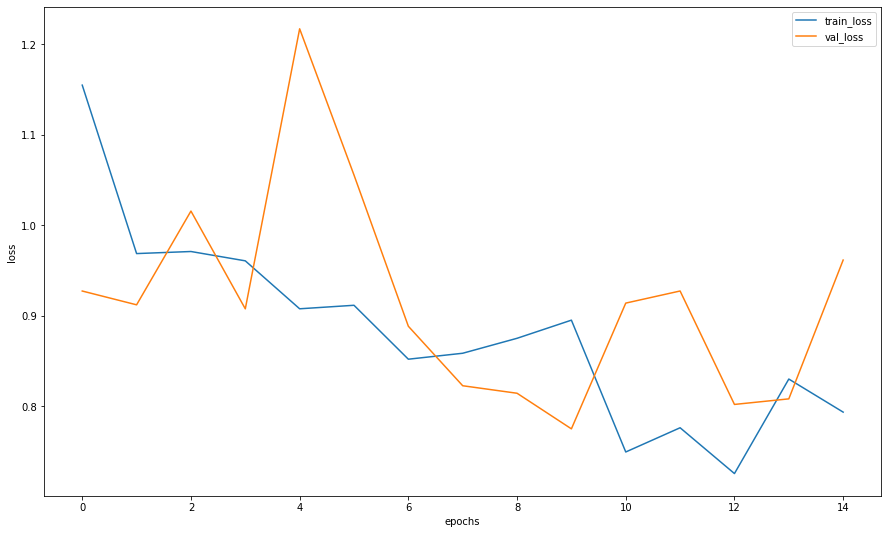

In [ ]:
loss, acc, val_loss, val_acc = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

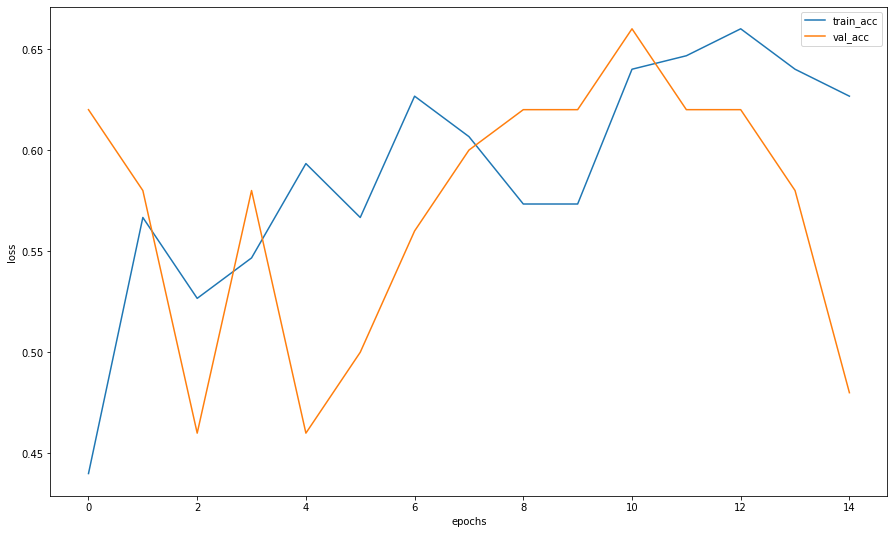

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
my_model_2_1.load_state_dict(torch.load(path, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
print(show_accuracy(my_model_2_1, val_dataloader))

{'Typical Nevus': 0.6666666666666666, 'Atyical Nevus': 0.6111111111111112, 'Melanoma': 0.7142857142857143}


In [ ]:
labels, predicts = get_predictions(my_model_2_1, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

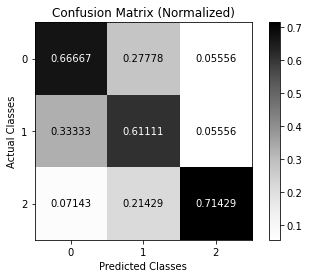

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.6708246708246707


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.63      0.67      0.65        18
Atypical Nevus       0.58      0.61      0.59        18
      Melanoma       0.83      0.71      0.77        14

      accuracy                           0.66        50
     macro avg       0.68      0.66      0.67        50
  weighted avg       0.67      0.66      0.66        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

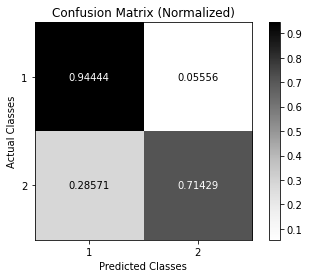

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.844074844074844


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.89      0.94      0.92        36
            Melanoma       0.83      0.71      0.77        14

            accuracy                           0.88        50
           macro avg       0.86      0.83      0.84        50
        weighted avg       0.88      0.88      0.88        50



## 6 conv-ups. + classes' balance.


Класс #3, меланома, представлен меньшим количеством образцов в обучающей выборке. Сбалансируем классы, добавив в обучающую выборку отзеркаленные относительно вертикальной оси изображения.

In [ ]:
new_train_images, new_train_target = balance_classes(train_images, list(y_train), 100)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images[:-1], new_train_target[:-1])), batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = batch_size, shuffle=False)

In [ ]:
my_model_2_2 = baseline().to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(my_model_2_2.parameters())

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
path = '/content/drive/MyDrive/my_bachelor_diploma/trained_models/baseline/my_model_2_2.pth'

In [ ]:
history = train(my_model_2_2, criterion, optimizer, 15,
              new_train_dataloader, val_dataloader, path, lr_scheduler)

epoch:   7%|▋         | 1/15 [00:01<00:24,  1.77s/it]

loss on train 1.0169442318953001

Epoch 001 train_loss: 1.0169     val_loss 1.1873 train_acc 0.4749 val_acc 0.5000


epoch:  13%|█▎        | 2/15 [00:03<00:20,  1.59s/it]

loss on train 0.8538323741493417

Epoch 002 train_loss: 0.8538     val_loss 0.7423 train_acc 0.6221 val_acc 0.6600


epoch:  20%|██        | 3/15 [00:04<00:18,  1.52s/it]

loss on train 0.8749365295255463

Epoch 003 train_loss: 0.8749     val_loss 0.8127 train_acc 0.6154 val_acc 0.6600


epoch:  27%|██▋       | 4/15 [00:06<00:16,  1.48s/it]

loss on train 0.8332901658820469

Epoch 004 train_loss: 0.8333     val_loss 0.7463 train_acc 0.6288 val_acc 0.6400


epoch:  33%|███▎      | 5/15 [00:07<00:14,  1.46s/it]

loss on train 0.830129399447138

Epoch 005 train_loss: 0.8301     val_loss 0.9539 train_acc 0.6054 val_acc 0.5600


epoch:  40%|████      | 6/15 [00:08<00:13,  1.45s/it]

loss on train 0.8123320208544715

Epoch 006 train_loss: 0.8123     val_loss 0.7686 train_acc 0.6355 val_acc 0.6000


epoch:  47%|████▋     | 7/15 [00:10<00:11,  1.45s/it]

loss on train 0.7566342091679972

Epoch 007 train_loss: 0.7566     val_loss 0.8617 train_acc 0.6856 val_acc 0.6200


epoch:  53%|█████▎    | 8/15 [00:11<00:10,  1.44s/it]

loss on train 0.7034031642121216

Epoch 008 train_loss: 0.7034     val_loss 0.7350 train_acc 0.6923 val_acc 0.6200


epoch:  60%|██████    | 9/15 [00:13<00:08,  1.44s/it]

loss on train 0.6649137905808197

Epoch 009 train_loss: 0.6649     val_loss 0.8207 train_acc 0.7224 val_acc 0.6200


epoch:  67%|██████▋   | 10/15 [00:14<00:07,  1.43s/it]

loss on train 0.7356857156075761

Epoch 010 train_loss: 0.7357     val_loss 0.8188 train_acc 0.6756 val_acc 0.6200


epoch:  73%|███████▎  | 11/15 [00:16<00:05,  1.43s/it]

loss on train 0.6133658835620784

Epoch 011 train_loss: 0.6134     val_loss 0.8067 train_acc 0.7625 val_acc 0.6600


epoch:  80%|████████  | 12/15 [00:17<00:04,  1.44s/it]

loss on train 0.6268228123518934

Epoch 012 train_loss: 0.6268     val_loss 0.7968 train_acc 0.7324 val_acc 0.7000


epoch:  87%|████████▋ | 13/15 [00:19<00:02,  1.44s/it]

loss on train 0.6386487485971738

Epoch 013 train_loss: 0.6386     val_loss 0.8570 train_acc 0.7458 val_acc 0.6200


epoch:  93%|█████████▎| 14/15 [00:20<00:01,  1.43s/it]

loss on train 0.6145662015497086

Epoch 014 train_loss: 0.6146     val_loss 0.8564 train_acc 0.7258 val_acc 0.6400


epoch: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]

loss on train 0.5612248330809998

Epoch 015 train_loss: 0.5612     val_loss 0.8627 train_acc 0.7960 val_acc 0.6800


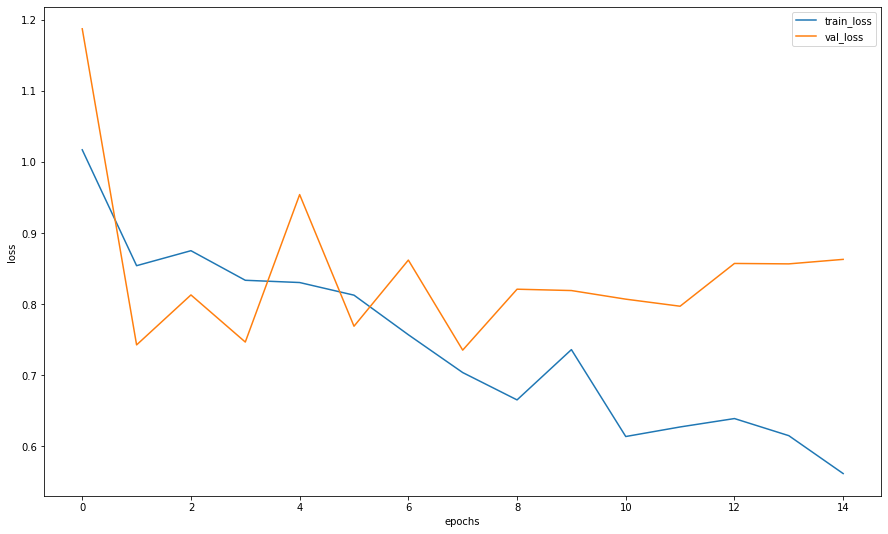

In [ ]:
loss, acc, val_loss, val_acc = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

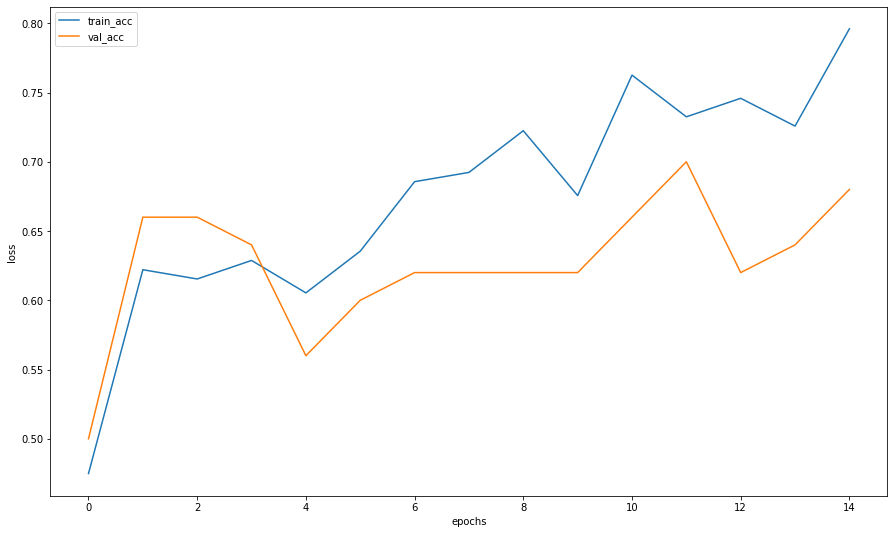

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
my_model_2_2.load_state_dict(torch.load(path, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
print(show_accuracy(my_model_2_2, val_dataloader))

{'Typical Nevus': 0.5555555555555556, 'Atyical Nevus': 0.6666666666666666, 'Melanoma': 0.9285714285714286}


In [ ]:
labels, predicts = get_predictions(my_model_2_2, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

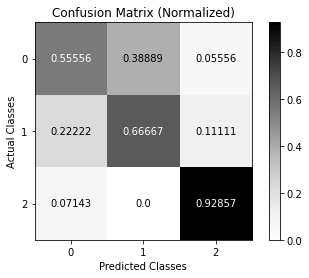

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.7071253071253071


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.67      0.56      0.61        18
Atypical Nevus       0.63      0.67      0.65        18
      Melanoma       0.81      0.93      0.87        14

      accuracy                           0.70        50
     macro avg       0.70      0.72      0.71        50
  weighted avg       0.69      0.70      0.69        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

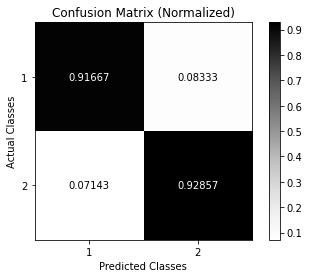

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.9047619047619047


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.97      0.92      0.94        36
            Melanoma       0.81      0.93      0.87        14

            accuracy                           0.92        50
           macro avg       0.89      0.92      0.90        50
        weighted avg       0.93      0.92      0.92        50



## 6 conv-ups. + classes' balance + gaussian blur.

In [ ]:
new_train_images, new_train_target = balance_classes(train_images, list(y_train), size=100)

In [ ]:
#new_train_images, new_train_target = add_more_examples(new_train_images, list(new_train_target))

In [ ]:
new_train_images = make_it_harder(new_train_images, augs_for_complication)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images, new_train_target)), batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = batch_size, shuffle=False)

In [ ]:
my_model_2_3 = baseline().to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.AdamW(my_model_2_3.parameters(), lr = 0.01)

In [ ]:
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.5, last_epoch=- 1, verbose=False)

In [ ]:
path = '/content/drive/MyDrive/my_bachelor_diploma/trained_models/my_model_2_3.pth'

In [ ]:
history = train(my_model_2_3, criterion, optimizer, 15,
                new_train_dataloader, val_dataloader, path)

epoch:   7%|▋         | 1/15 [00:02<00:32,  2.30s/it]

loss on train 1.063802562157313

Epoch 001 train_loss: 1.0638     val_loss 0.8574 train_acc 0.4933 val_acc 0.5400


epoch:  13%|█▎        | 2/15 [00:04<00:29,  2.24s/it]

loss on train 0.9716493239005407

Epoch 002 train_loss: 0.9716     val_loss 1.5066 train_acc 0.5333 val_acc 0.4200


epoch:  20%|██        | 3/15 [00:06<00:22,  1.90s/it]

loss on train 0.930999415119489

Epoch 003 train_loss: 0.9310     val_loss 1.0736 train_acc 0.5100 val_acc 0.4000


epoch:  27%|██▋       | 4/15 [00:07<00:19,  1.74s/it]

loss on train 0.9396375700831413

Epoch 004 train_loss: 0.9396     val_loss 0.9937 train_acc 0.5300 val_acc 0.5600


epoch:  33%|███▎      | 5/15 [00:09<00:16,  1.66s/it]

loss on train 0.9007549862066905

Epoch 005 train_loss: 0.9008     val_loss 0.8168 train_acc 0.5500 val_acc 0.5800


epoch:  40%|████      | 6/15 [00:10<00:14,  1.61s/it]

loss on train 0.8167485689123472

Epoch 006 train_loss: 0.8167     val_loss 0.7251 train_acc 0.6133 val_acc 0.6600


epoch:  47%|████▋     | 7/15 [00:12<00:12,  1.57s/it]

loss on train 0.8980599562327067

Epoch 007 train_loss: 0.8981     val_loss 0.8135 train_acc 0.6067 val_acc 0.7400


epoch:  53%|█████▎    | 8/15 [00:13<00:10,  1.54s/it]

loss on train 0.8947325780987739

Epoch 008 train_loss: 0.8947     val_loss 0.7193 train_acc 0.5767 val_acc 0.7000


epoch:  60%|██████    | 9/15 [00:14<00:09,  1.51s/it]

loss on train 0.8645939653118452

Epoch 009 train_loss: 0.8646     val_loss 0.8310 train_acc 0.5933 val_acc 0.5400


epoch:  67%|██████▋   | 10/15 [00:16<00:07,  1.49s/it]

loss on train 0.8782719065745671

Epoch 010 train_loss: 0.8783     val_loss 0.7857 train_acc 0.6000 val_acc 0.5600


epoch:  73%|███████▎  | 11/15 [00:17<00:05,  1.49s/it]

loss on train 0.831221001346906

Epoch 011 train_loss: 0.8312     val_loss 0.8550 train_acc 0.6067 val_acc 0.5200


epoch:  80%|████████  | 12/15 [00:19<00:04,  1.49s/it]

loss on train 0.7959557761748631

Epoch 012 train_loss: 0.7960     val_loss 0.9234 train_acc 0.5967 val_acc 0.5800


epoch:  87%|████████▋ | 13/15 [00:20<00:02,  1.48s/it]

loss on train 0.8519714549183846

Epoch 013 train_loss: 0.8520     val_loss 0.8589 train_acc 0.5967 val_acc 0.5600


epoch:  93%|█████████▎| 14/15 [00:22<00:01,  1.47s/it]

loss on train 0.8111378982663154

Epoch 014 train_loss: 0.8111     val_loss 1.0456 train_acc 0.6100 val_acc 0.6600


epoch: 100%|██████████| 15/15 [00:23<00:00,  1.58s/it]

loss on train 0.8138788123925527

Epoch 015 train_loss: 0.8139     val_loss 3.9045 train_acc 0.6067 val_acc 0.5800


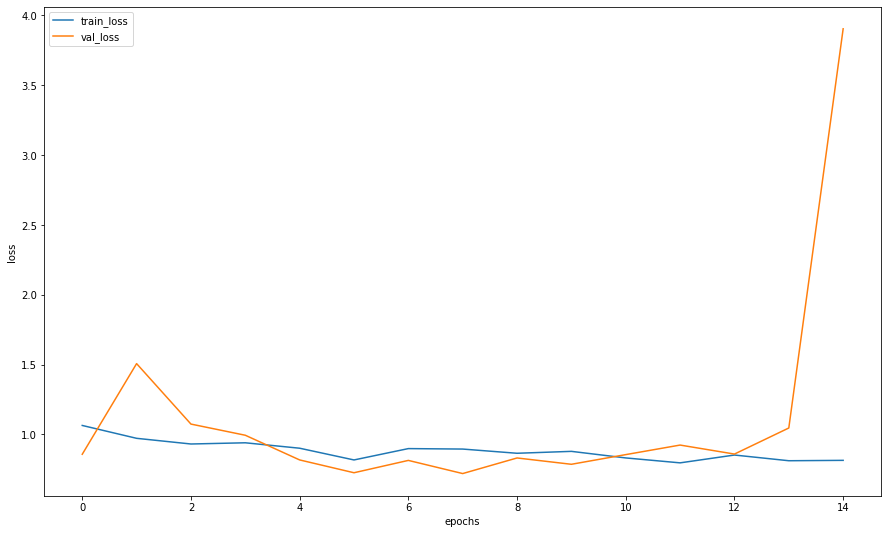

In [ ]:
loss, acc, val_loss, val_acc = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

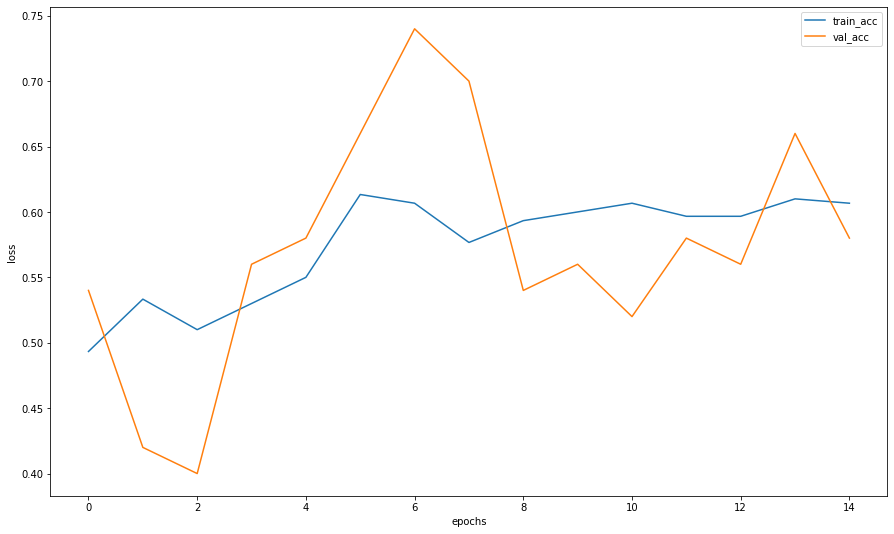

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
my_model_2_3.load_state_dict(torch.load(path, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
print(show_accuracy(my_model_2_3, val_dataloader))

{'Typical Nevus': 0.6666666666666666, 'Atyical Nevus': 0.6666666666666666, 'Melanoma': 0.9285714285714286}


In [ ]:
labels, predicts = get_predictions(my_model_2_3, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

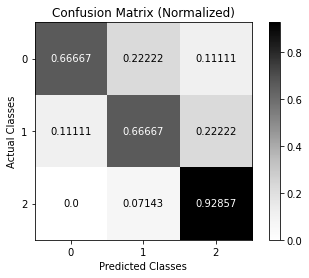

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.7411976911976912


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.86      0.67      0.75        18
Atypical Nevus       0.71      0.67      0.69        18
      Melanoma       0.68      0.93      0.79        14

      accuracy                           0.74        50
     macro avg       0.75      0.75      0.74        50
  weighted avg       0.75      0.74      0.74        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

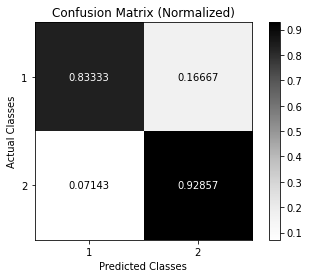

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.8417005879692447


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.97      0.83      0.90        36
            Melanoma       0.68      0.93      0.79        14

            accuracy                           0.86        50
           macro avg       0.83      0.88      0.84        50
        weighted avg       0.89      0.86      0.87        50



## 6 conv-ups. + classes' balance + $\pi/2$ rotation.

In [ ]:
new_train_images, new_train_target = balance_classes(train_images, list(y_train), 100)

In [ ]:
augmentations = [iaa.geometric.Rotate(90)]
                      #iaa.geometric.Rotate(180), iaa.geometric.Rotate(190)]

In [ ]:
new_train_images_exp, new_train_target_exp = add_more_examples(new_train_images, list(new_train_target), augmentations)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images_exp[:-1], new_train_target_exp[:-1])), batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = batch_size, shuffle=False)

In [ ]:
my_model_2_4 = baseline().to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(my_model_2_4.parameters())

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
path = '/content/drive/MyDrive/my_bachelor_diploma/trained_models/my_model_2_4.pth'

In [ ]:
history = train(my_model_2_4, criterion, optimizer, 15,
              new_train_dataloader, val_dataloader, path, lr_scheduler)

epoch:   7%|▋         | 1/15 [00:03<00:45,  3.23s/it]

loss on train 0.9966933572978045

Epoch 001 train_loss: 0.9967     val_loss 0.8791 train_acc 0.5221 val_acc 0.6200


epoch:  13%|█▎        | 2/15 [00:06<00:40,  3.11s/it]

loss on train 0.8930308723212343

Epoch 002 train_loss: 0.8930     val_loss 0.9497 train_acc 0.5863 val_acc 0.6000


epoch:  20%|██        | 3/15 [00:10<00:41,  3.43s/it]

loss on train 0.8256210758622768

Epoch 003 train_loss: 0.8256     val_loss 0.8442 train_acc 0.6062 val_acc 0.5600


epoch:  27%|██▋       | 4/15 [00:12<00:32,  2.95s/it]

loss on train 0.8324100718034052

Epoch 004 train_loss: 0.8324     val_loss 0.8871 train_acc 0.6261 val_acc 0.6600


epoch:  33%|███▎      | 5/15 [00:14<00:26,  2.66s/it]

loss on train 0.7977552454160378

Epoch 005 train_loss: 0.7978     val_loss 0.8280 train_acc 0.6438 val_acc 0.6600


epoch:  40%|████      | 6/15 [00:16<00:22,  2.49s/it]

loss on train 0.7930185572631592

Epoch 006 train_loss: 0.7930     val_loss 0.7406 train_acc 0.6350 val_acc 0.7200


epoch:  47%|████▋     | 7/15 [00:18<00:18,  2.37s/it]

loss on train 0.7788860656123245

Epoch 007 train_loss: 0.7789     val_loss 0.7842 train_acc 0.6416 val_acc 0.6600


epoch:  53%|█████▎    | 8/15 [00:20<00:16,  2.29s/it]

loss on train 0.8137138944811526

Epoch 008 train_loss: 0.8137     val_loss 0.8302 train_acc 0.6239 val_acc 0.6200


epoch:  60%|██████    | 9/15 [00:22<00:13,  2.23s/it]

loss on train 0.8374746010630532

Epoch 009 train_loss: 0.8375     val_loss 0.8209 train_acc 0.6460 val_acc 0.6600


epoch:  67%|██████▋   | 10/15 [00:25<00:11,  2.21s/it]

loss on train 0.7923009584830926

Epoch 010 train_loss: 0.7923     val_loss 0.7094 train_acc 0.6482 val_acc 0.6600


epoch:  73%|███████▎  | 11/15 [00:27<00:08,  2.18s/it]

loss on train 0.7640601666891469

Epoch 011 train_loss: 0.7641     val_loss 0.7188 train_acc 0.6726 val_acc 0.6600


epoch:  80%|████████  | 12/15 [00:29<00:06,  2.16s/it]

loss on train 0.7070464598657811

Epoch 012 train_loss: 0.7070     val_loss 0.9838 train_acc 0.7058 val_acc 0.6800


epoch:  87%|████████▋ | 13/15 [00:31<00:04,  2.14s/it]

loss on train 0.6998092120727607

Epoch 013 train_loss: 0.6998     val_loss 0.7513 train_acc 0.6881 val_acc 0.6600


epoch:  93%|█████████▎| 14/15 [00:33<00:02,  2.13s/it]

loss on train 0.710854915885535

Epoch 014 train_loss: 0.7109     val_loss 0.6974 train_acc 0.7058 val_acc 0.7000


epoch: 100%|██████████| 15/15 [00:35<00:00,  2.37s/it]

loss on train 0.7234452714302898

Epoch 015 train_loss: 0.7234     val_loss 0.6857 train_acc 0.7080 val_acc 0.7200


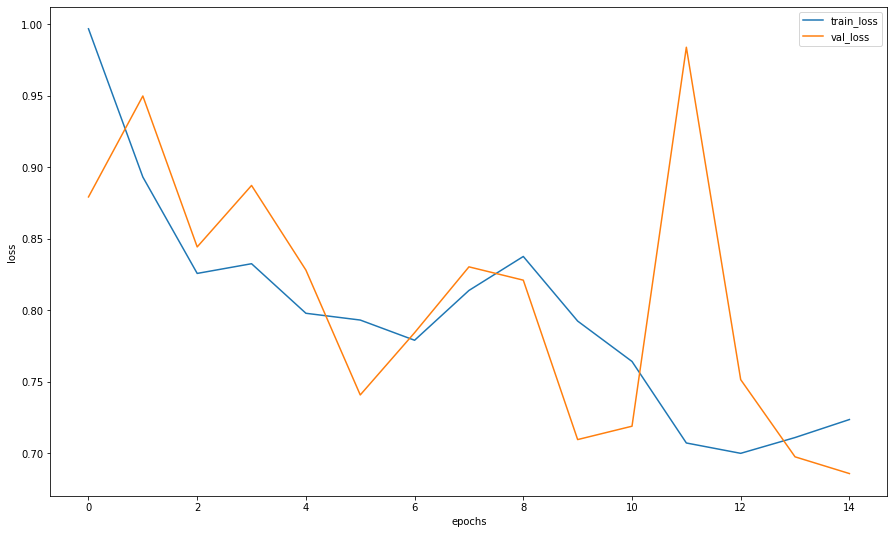

In [ ]:
loss, acc, val_loss, val_acc = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

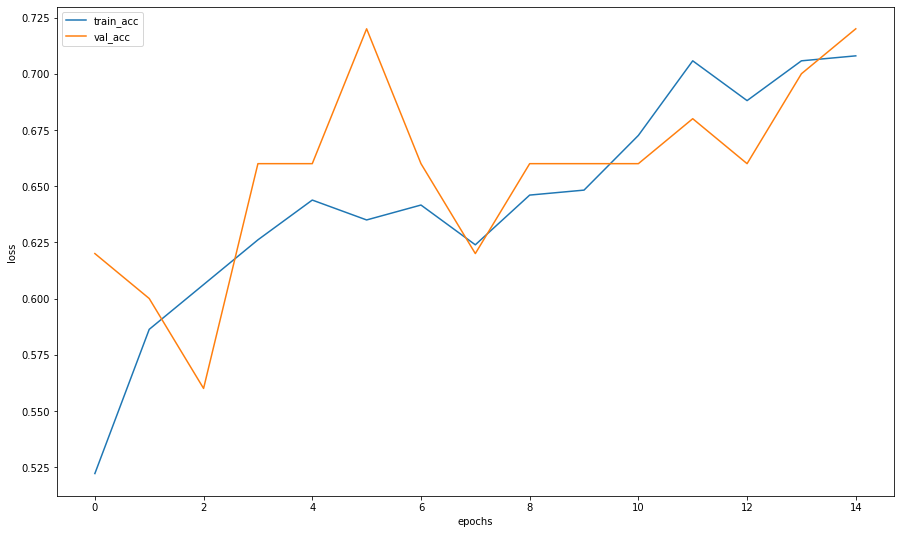

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
print(show_accuracy(my_model_2_4, val_dataloader))

{'Typical Nevus': 0.6666666666666666, 'Atyical Nevus': 0.6111111111111112, 'Melanoma': 0.9285714285714286}


In [ ]:
labels, predicts = get_predictions(my_model_2_4, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

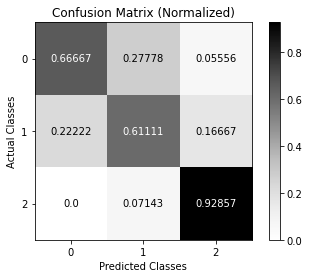

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.7243878196439867


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.75      0.67      0.71        18
Atypical Nevus       0.65      0.61      0.63        18
      Melanoma       0.76      0.93      0.84        14

      accuracy                           0.72        50
     macro avg       0.72      0.74      0.72        50
  weighted avg       0.72      0.72      0.72        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

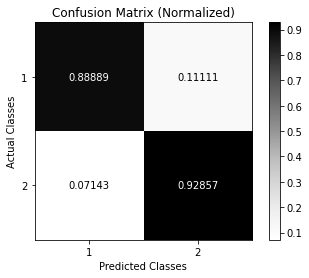

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.8831229546517064


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.97      0.89      0.93        36
            Melanoma       0.76      0.93      0.84        14

            accuracy                           0.90        50
           macro avg       0.87      0.91      0.88        50
        weighted avg       0.91      0.90      0.90        50



## 6 conv-ups. + classes' balance $\pi/2$ rotation + gaussian blur.

In [ ]:
new_train_images, new_train_target = balance_classes(train_images, list(y_train), size=100)

In [ ]:
augmentations = [iaa.geometric.Rotate(90)]
new_train_images, new_train_target = add_more_examples(new_train_images, 
                                      list(new_train_target), augmentations)

In [ ]:
new_train_images = make_it_harder(new_train_images, augs_for_complication)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images, new_train_target)), batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = batch_size, shuffle=False)

In [ ]:
my_model_2_5 = baseline().to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.AdamW(my_model_2_5.parameters(), lr = 0.01)

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.5, last_epoch=- 1, verbose=False)

In [ ]:
path = '/content/drive/MyDrive/my_bachelor_diploma/trained_models/baseline/my_model_2_5.pth'

In [ ]:
history = train(my_model_2_5, criterion, optimizer, 15,
            new_train_dataloader, val_dataloader, path, scheduler)

epoch:   7%|▋         | 1/15 [00:02<00:32,  2.31s/it]

loss on train 1.1363070861677105

Epoch 001 train_loss: 1.1363     val_loss 1.0753 train_acc 0.4135 val_acc 0.3600


epoch:  13%|█▎        | 2/15 [00:04<00:28,  2.23s/it]

loss on train 1.0203675058450592

Epoch 002 train_loss: 1.0204     val_loss 0.9176 train_acc 0.4876 val_acc 0.6200


epoch:  20%|██        | 3/15 [00:06<00:26,  2.18s/it]

loss on train 0.9554076723838121

Epoch 003 train_loss: 0.9554     val_loss 0.8907 train_acc 0.4966 val_acc 0.6200


epoch:  27%|██▋       | 4/15 [00:08<00:23,  2.16s/it]

loss on train 0.8853912956259223

Epoch 004 train_loss: 0.8854     val_loss 1.3313 train_acc 0.5416 val_acc 0.4400


epoch:  33%|███▎      | 5/15 [00:10<00:21,  2.14s/it]

loss on train 0.9361593663022759

Epoch 005 train_loss: 0.9362     val_loss 0.8164 train_acc 0.5461 val_acc 0.6200


epoch:  40%|████      | 6/15 [00:13<00:19,  2.15s/it]

loss on train 0.8655483059668809

Epoch 006 train_loss: 0.8655     val_loss 0.7971 train_acc 0.5708 val_acc 0.4400


epoch:  47%|████▋     | 7/15 [00:15<00:17,  2.14s/it]

loss on train 0.8052176223712021

Epoch 007 train_loss: 0.8052     val_loss 0.7025 train_acc 0.5910 val_acc 0.6200


epoch:  53%|█████▎    | 8/15 [00:17<00:15,  2.14s/it]

loss on train 0.7725618444801716

Epoch 008 train_loss: 0.7726     val_loss 1.1826 train_acc 0.6337 val_acc 0.7200


epoch:  60%|██████    | 9/15 [00:19<00:12,  2.14s/it]

loss on train 0.8506209779991193

Epoch 009 train_loss: 0.8506     val_loss 0.7375 train_acc 0.6090 val_acc 0.6800


epoch:  67%|██████▋   | 10/15 [00:21<00:10,  2.13s/it]

loss on train 0.7801228818598758

Epoch 010 train_loss: 0.7801     val_loss 2.5214 train_acc 0.6315 val_acc 0.7200


epoch:  73%|███████▎  | 11/15 [00:23<00:08,  2.16s/it]

loss on train 0.7769269859522916

Epoch 011 train_loss: 0.7769     val_loss 0.7000 train_acc 0.6382 val_acc 0.7800


epoch:  80%|████████  | 12/15 [00:25<00:06,  2.16s/it]

loss on train 0.8081922544522232

Epoch 012 train_loss: 0.8082     val_loss 0.8777 train_acc 0.6652 val_acc 0.6000


epoch:  87%|████████▋ | 13/15 [00:28<00:04,  2.14s/it]

loss on train 0.7858842155906591

Epoch 013 train_loss: 0.7859     val_loss 0.7739 train_acc 0.6180 val_acc 0.6800


epoch:  93%|█████████▎| 14/15 [00:30<00:02,  2.15s/it]

loss on train 0.7047445740592614

Epoch 014 train_loss: 0.7047     val_loss 0.6072 train_acc 0.6652 val_acc 0.7400


epoch: 100%|██████████| 15/15 [00:32<00:00,  2.15s/it]

loss on train 0.7391214243481669

Epoch 015 train_loss: 0.7391     val_loss 0.6314 train_acc 0.6449 val_acc 0.7000


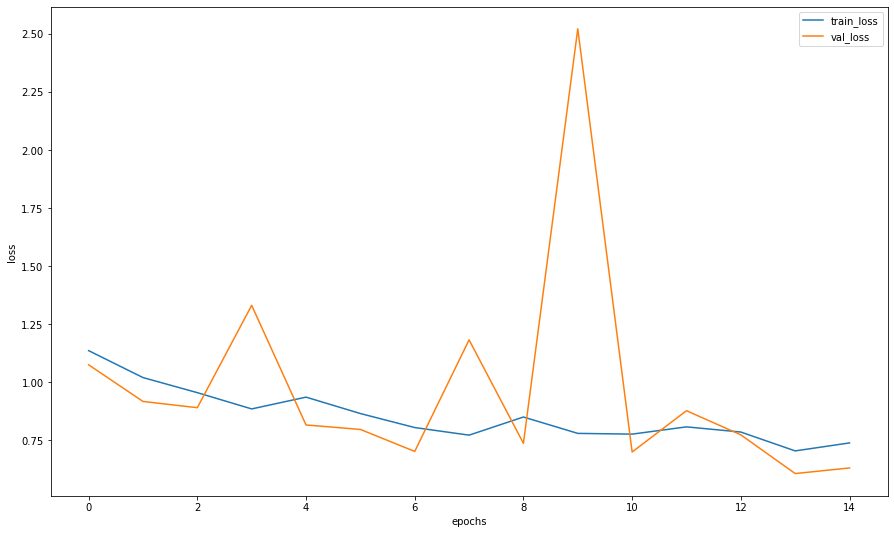

In [ ]:
loss, acc, val_loss, val_acc = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

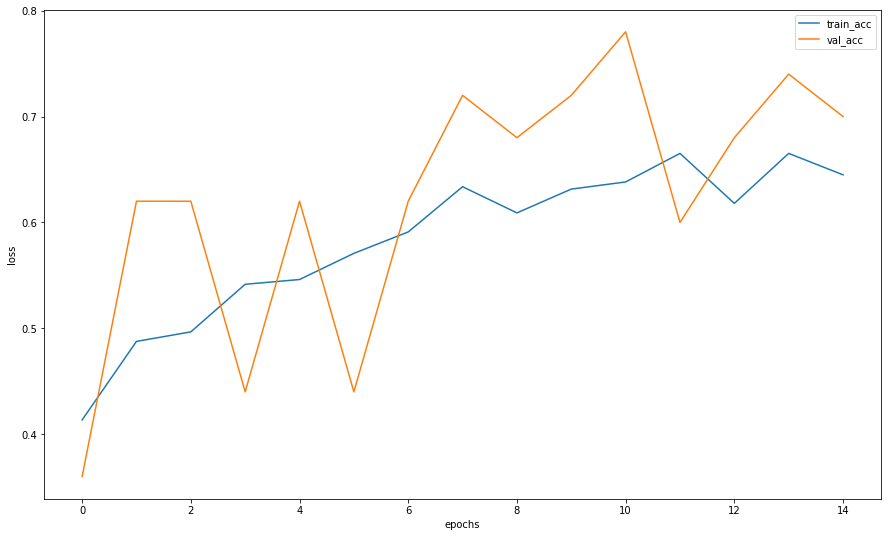

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
my_model_2_5.load_state_dict(torch.load(path, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
print(show_accuracy(my_model_2_5, val_dataloader))

{'Typical Nevus': 0.6666666666666666, 'Atyical Nevus': 0.8333333333333334, 'Melanoma': 0.8571428571428571}


In [ ]:
labels, predicts = get_predictions(my_model_2_5, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

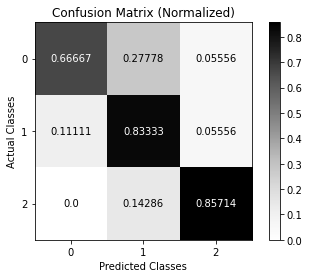

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.7857142857142857


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.86      0.67      0.75        18
Atypical Nevus       0.68      0.83      0.75        18
      Melanoma       0.86      0.86      0.86        14

      accuracy                           0.78        50
     macro avg       0.80      0.79      0.79        50
  weighted avg       0.79      0.78      0.78        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

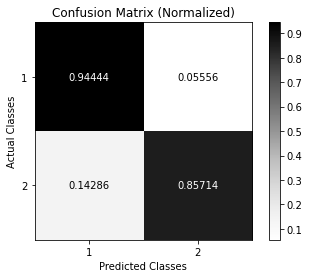

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.9007936507936507


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.94      0.94      0.94        36
            Melanoma       0.86      0.86      0.86        14

            accuracy                           0.92        50
           macro avg       0.90      0.90      0.90        50
        weighted avg       0.92      0.92      0.92        50



## 6 conv-ups. + classes' balance + $\pi/2$, $\pi$ rotation.

In [ ]:
new_train_images, new_train_target = balance_classes(train_images, list(y_train), 100)

In [ ]:
augmentations = [iaa.geometric.Rotate(90),
                      iaa.geometric.Rotate(180)] #iaa.geometric.Rotate(270)]

In [ ]:
new_train_images_exp, new_train_target_exp = add_more_examples(new_train_images, list(new_train_target), augmentations)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images_exp[:-1], new_train_target_exp[:-1])), batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = batch_size, shuffle=False)

In [ ]:
my_model_2_6 = baseline().to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(my_model_2_6.parameters())

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

In [ ]:
path = '/content/drive/MyDrive/my_bachelor_diploma/trained_models/my_model_2_6.pth'

In [ ]:
history = train(my_model_2_6, criterion, optimizer, 20,
              new_train_dataloader, val_dataloader, path)

epoch:   5%|▌         | 1/20 [00:03<00:57,  3.02s/it]

loss on train 0.940471363369546

Epoch 001 train_loss: 0.9405     val_loss 0.8518 train_acc 0.5359 val_acc 0.6400


epoch:  10%|█         | 2/20 [00:05<00:52,  2.92s/it]

loss on train 0.87554262369092

Epoch 002 train_loss: 0.8755     val_loss 1.1626 train_acc 0.5817 val_acc 0.5200


epoch:  15%|█▌        | 3/20 [00:08<00:49,  2.91s/it]

loss on train 0.8384378114167381

Epoch 003 train_loss: 0.8384     val_loss 0.8731 train_acc 0.6095 val_acc 0.6000


epoch:  20%|██        | 4/20 [00:11<00:46,  2.89s/it]

loss on train 0.8005232047411351

Epoch 004 train_loss: 0.8005     val_loss 0.9722 train_acc 0.6160 val_acc 0.6000


epoch:  25%|██▌       | 5/20 [00:14<00:43,  2.88s/it]

loss on train 0.7864406675197719

Epoch 005 train_loss: 0.7864     val_loss 0.8657 train_acc 0.6454 val_acc 0.6600


epoch:  30%|███       | 6/20 [00:17<00:40,  2.88s/it]

loss on train 0.821321143628725

Epoch 006 train_loss: 0.8213     val_loss 0.7436 train_acc 0.6225 val_acc 0.6200


epoch:  35%|███▌      | 7/20 [00:20<00:37,  2.88s/it]

loss on train 0.7667869282703773

Epoch 007 train_loss: 0.7668     val_loss 1.0037 train_acc 0.6487 val_acc 0.6200


epoch:  40%|████      | 8/20 [00:23<00:34,  2.88s/it]

loss on train 0.7666849886718529

Epoch 008 train_loss: 0.7667     val_loss 0.7823 train_acc 0.6683 val_acc 0.7000


epoch:  45%|████▌     | 9/20 [00:26<00:31,  2.88s/it]

loss on train 0.6996619436962932

Epoch 009 train_loss: 0.6997     val_loss 0.8173 train_acc 0.6879 val_acc 0.7400


epoch:  50%|█████     | 10/20 [00:28<00:28,  2.88s/it]

loss on train 0.7573395135745503

Epoch 010 train_loss: 0.7573     val_loss 0.8517 train_acc 0.6846 val_acc 0.6800


epoch:  55%|█████▌    | 11/20 [00:31<00:25,  2.88s/it]

loss on train 0.7072839317904189

Epoch 011 train_loss: 0.7073     val_loss 0.8218 train_acc 0.6879 val_acc 0.7000


epoch:  60%|██████    | 12/20 [00:34<00:23,  2.88s/it]

loss on train 0.7185545844190261

Epoch 012 train_loss: 0.7186     val_loss 0.7300 train_acc 0.6830 val_acc 0.7000


epoch:  65%|██████▌   | 13/20 [00:37<00:20,  2.87s/it]

loss on train 0.7230744967663211

Epoch 013 train_loss: 0.7231     val_loss 0.9236 train_acc 0.6781 val_acc 0.5800


epoch:  70%|███████   | 14/20 [00:40<00:17,  2.86s/it]

loss on train 0.7536164940474859

Epoch 014 train_loss: 0.7536     val_loss 0.8268 train_acc 0.6471 val_acc 0.6600


epoch:  75%|███████▌  | 15/20 [00:43<00:14,  2.85s/it]

loss on train 0.7445050057486381

Epoch 015 train_loss: 0.7445     val_loss 0.8695 train_acc 0.6503 val_acc 0.6800


epoch:  80%|████████  | 16/20 [00:46<00:11,  2.85s/it]

loss on train 0.6432573539904909

Epoch 016 train_loss: 0.6433     val_loss 0.8487 train_acc 0.7386 val_acc 0.7000


epoch:  85%|████████▌ | 17/20 [00:48<00:08,  2.86s/it]

loss on train 0.6947149920940788

Epoch 017 train_loss: 0.6947     val_loss 1.0479 train_acc 0.6879 val_acc 0.3800


epoch:  90%|█████████ | 18/20 [00:51<00:05,  2.85s/it]

loss on train 0.6671046197803971

Epoch 018 train_loss: 0.6671     val_loss 0.7903 train_acc 0.6895 val_acc 0.5400


epoch:  95%|█████████▌| 19/20 [00:54<00:02,  2.85s/it]

loss on train 0.6639949580277104

Epoch 019 train_loss: 0.6640     val_loss 1.3663 train_acc 0.7239 val_acc 0.7000


epoch: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it]

loss on train 0.6795494764118023

Epoch 020 train_loss: 0.6795     val_loss 1.0439 train_acc 0.7141 val_acc 0.6000


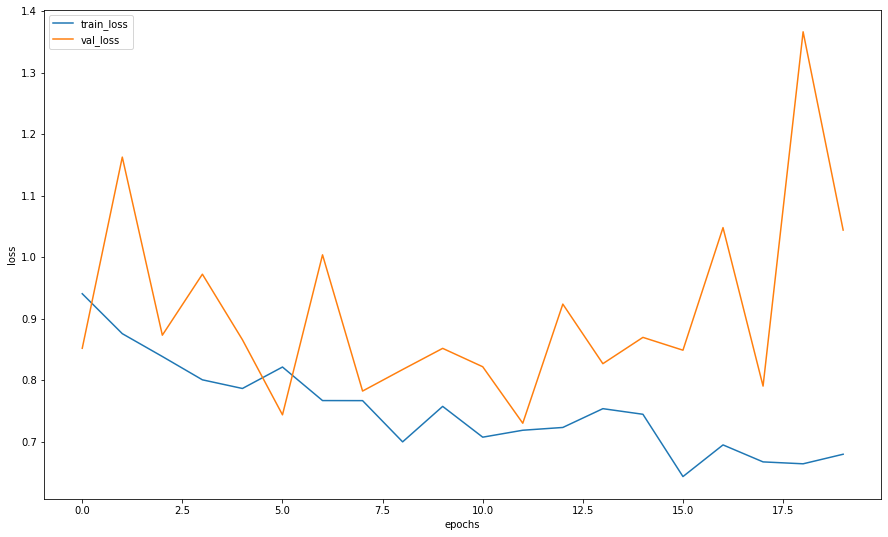

In [ ]:
loss, acc, val_loss, val_acc = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

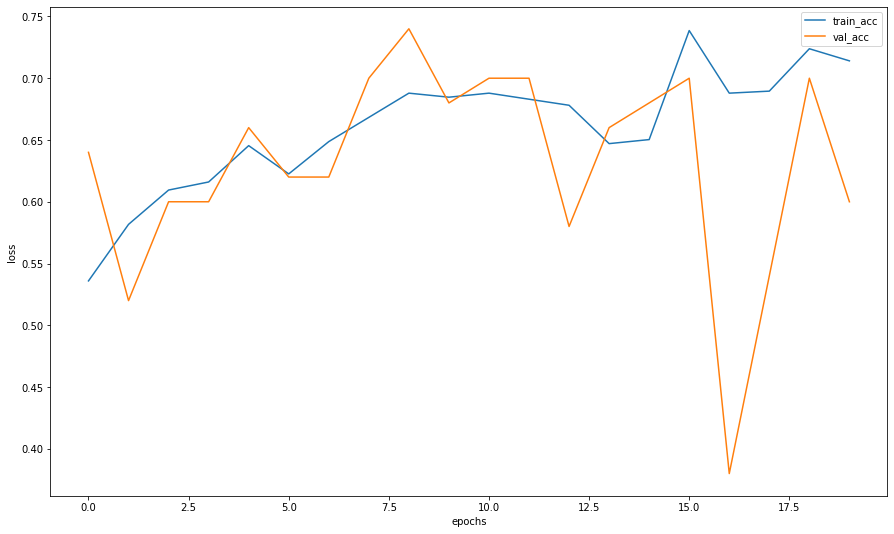

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
my_model_2_6.load_state_dict(torch.load(path, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
print(show_accuracy(my_model_2_6, val_dataloader))

{'Typical Nevus': 0.7222222222222222, 'Atyical Nevus': 0.5555555555555556, 'Melanoma': 1.0}


In [ ]:
labels, predicts = get_predictions(my_model_2_6, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

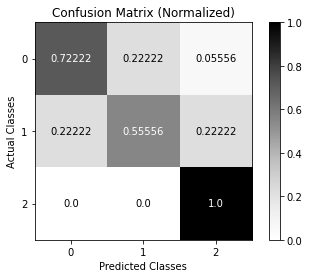

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.7387806637806639


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.76      0.72      0.74        18
Atypical Nevus       0.71      0.56      0.63        18
      Melanoma       0.74      1.00      0.85        14

      accuracy                           0.74        50
     macro avg       0.74      0.76      0.74        50
  weighted avg       0.74      0.74      0.73        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

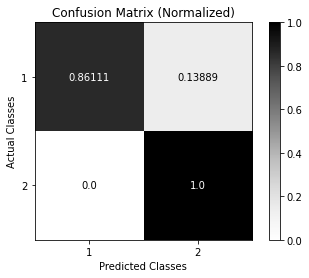

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.8869289914066033


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       1.00      0.86      0.93        36
            Melanoma       0.74      1.00      0.85        14

            accuracy                           0.90        50
           macro avg       0.87      0.93      0.89        50
        weighted avg       0.93      0.90      0.90        50



## 6 conv-ups. + classes' balance $\pi/2$, $\pi$ rotation + gaussian blur.

In [ ]:
new_train_images, new_train_target = balance_classes(train_images, list(y_train), size=100)

In [ ]:
augmentations = [iaa.geometric.Rotate(90), iaa.geometric.Rotate(180)]
new_train_images, new_train_target = add_more_examples(new_train_images, 
                                      list(new_train_target), augmentations)

In [ ]:
new_train_images = make_it_harder(new_train_images, augs_for_complication)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images, new_train_target)), batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = batch_size, shuffle=False)

In [ ]:
my_model_2_7 = baseline().to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.AdamW(my_model_2_7.parameters(), lr = 0.01)

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.75, last_epoch=- 1, verbose=False)

In [ ]:
path = '/content/drive/MyDrive/my_bachelor_diploma/trained_models/my_model_2_7.pth'

In [ ]:
history = train(my_model_2_7, criterion, optimizer, 20,
            new_train_dataloader, val_dataloader, path, scheduler)

epoch:   5%|▌         | 1/20 [00:03<00:57,  3.03s/it]

loss on train 1.0874339737861036

Epoch 001 train_loss: 1.0874     val_loss 1.0018 train_acc 0.4405 val_acc 0.5800


epoch:  10%|█         | 2/20 [00:05<00:52,  2.93s/it]

loss on train 0.9635758767509149

Epoch 002 train_loss: 0.9636     val_loss 0.8867 train_acc 0.5139 val_acc 0.5800


epoch:  15%|█▌        | 3/20 [00:08<00:49,  2.90s/it]

loss on train 0.8527076243381905

Epoch 003 train_loss: 0.8527     val_loss 0.8772 train_acc 0.5905 val_acc 0.5800


epoch:  20%|██        | 4/20 [00:11<00:46,  2.89s/it]

loss on train 0.8482096753346006

Epoch 004 train_loss: 0.8482     val_loss 1.4355 train_acc 0.6101 val_acc 0.6400


epoch:  25%|██▌       | 5/20 [00:14<00:43,  2.87s/it]

loss on train 0.8312620981968636

Epoch 005 train_loss: 0.8313     val_loss 0.8409 train_acc 0.6069 val_acc 0.5600


epoch:  30%|███       | 6/20 [00:17<00:40,  2.88s/it]

loss on train 0.848627479488659

Epoch 006 train_loss: 0.8486     val_loss 0.7279 train_acc 0.5987 val_acc 0.6600


epoch:  35%|███▌      | 7/20 [00:20<00:37,  2.89s/it]

loss on train 0.8086437817790575

Epoch 007 train_loss: 0.8086     val_loss 0.8874 train_acc 0.6183 val_acc 0.7000


epoch:  40%|████      | 8/20 [00:23<00:34,  2.88s/it]

loss on train 0.8293925774136336

Epoch 008 train_loss: 0.8294     val_loss 0.7785 train_acc 0.6085 val_acc 0.6800


epoch:  45%|████▌     | 9/20 [00:26<00:31,  2.88s/it]

loss on train 0.833096373188165

Epoch 009 train_loss: 0.8331     val_loss 0.8028 train_acc 0.6281 val_acc 0.6000


epoch:  50%|█████     | 10/20 [00:28<00:28,  2.88s/it]

loss on train 0.7962609288840271

Epoch 010 train_loss: 0.7963     val_loss 0.7284 train_acc 0.6183 val_acc 0.6800


epoch:  55%|█████▌    | 11/20 [00:31<00:25,  2.89s/it]

loss on train 0.7782712201990467

Epoch 011 train_loss: 0.7783     val_loss 0.7234 train_acc 0.6427 val_acc 0.6200


epoch:  60%|██████    | 12/20 [00:34<00:23,  2.88s/it]

loss on train 0.799515425283796

Epoch 012 train_loss: 0.7995     val_loss 0.7160 train_acc 0.6101 val_acc 0.7000


epoch:  65%|██████▌   | 13/20 [00:37<00:20,  2.87s/it]

loss on train 0.8203722380502773

Epoch 013 train_loss: 0.8204     val_loss 0.8282 train_acc 0.5889 val_acc 0.6200


epoch:  70%|███████   | 14/20 [00:40<00:17,  2.89s/it]

loss on train 0.804230698413211

Epoch 014 train_loss: 0.8042     val_loss 0.6900 train_acc 0.6166 val_acc 0.7400


epoch:  75%|███████▌  | 15/20 [00:43<00:14,  2.89s/it]

loss on train 0.780674903223604

Epoch 015 train_loss: 0.7807     val_loss 0.6743 train_acc 0.6346 val_acc 0.7200


epoch:  80%|████████  | 16/20 [00:46<00:11,  2.91s/it]

loss on train 0.8303247493301286

Epoch 016 train_loss: 0.8303     val_loss 0.7599 train_acc 0.6264 val_acc 0.7200


epoch:  85%|████████▌ | 17/20 [00:49<00:08,  2.89s/it]

loss on train 0.8110936507218036

Epoch 017 train_loss: 0.8111     val_loss 0.7109 train_acc 0.6330 val_acc 0.7000


epoch:  90%|█████████ | 18/20 [00:52<00:06,  3.11s/it]

loss on train 0.7379917129509601

Epoch 018 train_loss: 0.7380     val_loss 0.6456 train_acc 0.6688 val_acc 0.7600


epoch:  95%|█████████▌| 19/20 [00:55<00:03,  3.04s/it]

loss on train 0.738059082000135

Epoch 019 train_loss: 0.7381     val_loss 0.6989 train_acc 0.6558 val_acc 0.7400


epoch: 100%|██████████| 20/20 [00:58<00:00,  2.93s/it]

loss on train 0.778762012136702

Epoch 020 train_loss: 0.7788     val_loss 0.7302 train_acc 0.6591 val_acc 0.6200


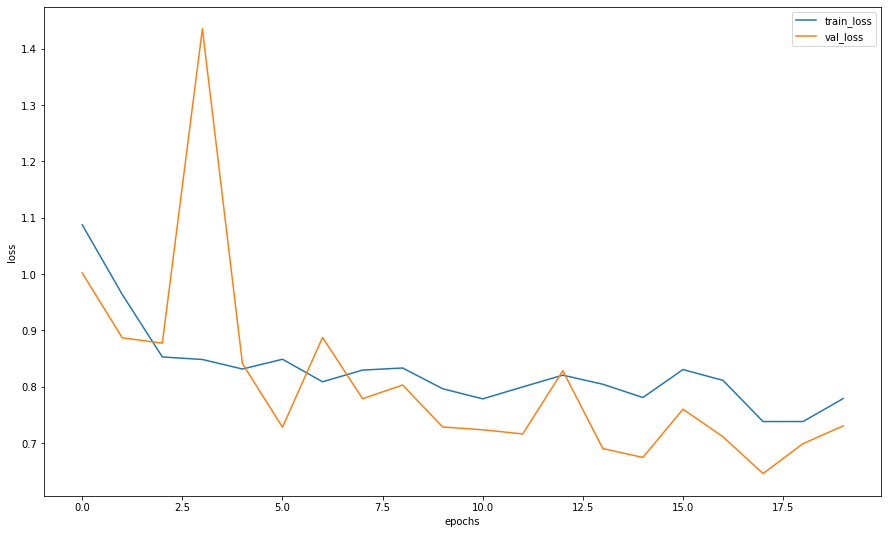

In [ ]:
loss, acc, val_loss, val_acc = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

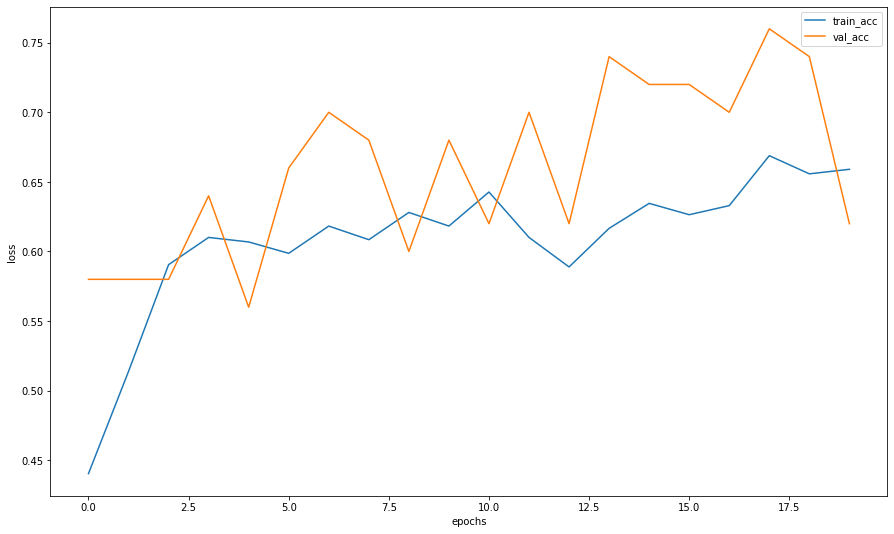

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
my_model_2_7.load_state_dict(torch.load(path, map_location = torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
print(show_accuracy(my_model_2_7, val_dataloader))

{'Typical Nevus': 0.6666666666666666, 'Atyical Nevus': 0.6666666666666666, 'Melanoma': 1.0}


In [ ]:
labels, predicts = get_predictions(my_model_2_7, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

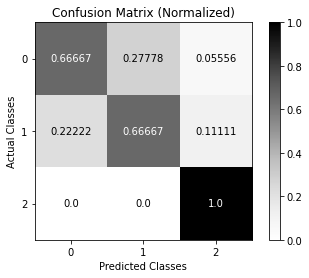

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.7649408150356917


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.75      0.67      0.71        18
Atypical Nevus       0.71      0.67      0.69        18
      Melanoma       0.82      1.00      0.90        14

      accuracy                           0.76        50
     macro avg       0.76      0.78      0.76        50
  weighted avg       0.75      0.76      0.75        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

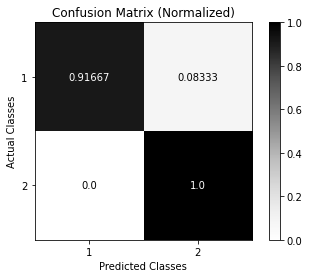

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.9298737727910238


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       1.00      0.92      0.96        36
            Melanoma       0.82      1.00      0.90        14

            accuracy                           0.94        50
           macro avg       0.91      0.96      0.93        50
        weighted avg       0.95      0.94      0.94        50



# Inception

## Inception + classes' balance

In [ ]:
means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [ ]:
transformations = tt.Compose([
    tt.ToTensor(),
    tt.Resize((299, 299)),
    tt.Normalize(means, stds)
])

In [ ]:
train_images = array_to_tensor(transformations, train_images_array)
val_images = array_to_tensor(transformations, val_images_array)

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
#for now we have 26 items of class 2 and 62 for 1 & 0, so balance all of them
#to have 100 elements.
new_train_images, new_train_target = balance_classes(train_images, list(y_train), 100)

In [ ]:
#new_train_images, new_train_target = add_more_examples(new_train_images, list(new_train_target), augs_for_exp)

In [ ]:
#new_train_images = make_it_harder(new_train_images, augs_for_complication)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images, new_train_target)), batch_size = 16, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = 16, shuffle=False)

In [ ]:
best_score = 0

In [ ]:
def objective(trial):
    global best_score
    inception = models.inception_v3(pretrained=True)

    for params in inception.parameters():
        params.requires_grad_(True)

    inception.AuxLogits.fc = nn.Sequential(
        nn.Linear(768, 3, bias=True),
        nn.Softmax())

    inception.fc = nn.Sequential(
        nn.Linear(2048, 3, bias=True),
        nn.Softmax())
    
    inception = inception.to(DEVICE)
    
    lr = trial.suggest_uniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-1)
    gamma = trial.suggest_uniform('gamma', 0.25, 0.75)

    optimizer = torch.optim.Adam(inception.parameters(), lr=lr,
                                            weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, 
                                            gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    history = train(inception, criterion, optimizer, 10, new_train_dataloader,
                val_dataloader, '/content/inception.pth', lr_scheduler, True)
    
    inception.load_state_dict(torch.load('/content/inception.pth'))
    
    loss, acc, val_loss, val_acc = zip(*history)

    if max(val_acc) > best_score:
        best_score = max(val_acc)
        torch.save(inception.state_dict(),
        '/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_balance.pth')

    return max(val_acc)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-04-29 09:51:30,518] A new study created in memory with name: no-name-84021f4b-dac5-47c9-92e9-81e9e3492336
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2508038314183554


epoch:  10%|█         | 1/10 [00:12<01:53, 12.59s/it]


Epoch 001 train_loss: 1.2508     val_loss 0.9792 train_acc 0.6567 val_acc 0.5400
loss on train 0.9890629259745279


epoch:  20%|██        | 2/10 [00:24<01:39, 12.43s/it]


Epoch 002 train_loss: 0.9891     val_loss 0.9624 train_acc 0.8567 val_acc 0.5800
loss on train 0.9430149491628012


epoch:  30%|███       | 3/10 [00:37<01:26, 12.41s/it]


Epoch 003 train_loss: 0.9430     val_loss 0.8849 train_acc 0.8733 val_acc 0.6600
loss on train 0.96921693166097


epoch:  40%|████      | 4/10 [00:49<01:14, 12.44s/it]


Epoch 004 train_loss: 0.9692     val_loss 0.8505 train_acc 0.8333 val_acc 0.6800
loss on train 0.9019267757733663


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.35s/it]


Epoch 005 train_loss: 0.9019     val_loss 0.9085 train_acc 0.8967 val_acc 0.6200
loss on train 0.8667264890670776


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.42s/it]


Epoch 006 train_loss: 0.8667     val_loss 0.8271 train_acc 0.9233 val_acc 0.7200
loss on train 0.8191612156232199


epoch:  70%|███████   | 7/10 [01:26<00:37, 12.39s/it]


Epoch 007 train_loss: 0.8192     val_loss 0.8929 train_acc 0.9700 val_acc 0.6200
loss on train 0.812612464427948


epoch:  80%|████████  | 8/10 [01:39<00:24, 12.32s/it]


Epoch 008 train_loss: 0.8126     val_loss 0.8663 train_acc 0.9767 val_acc 0.6800
loss on train 0.7983189090092977


epoch:  90%|█████████ | 9/10 [01:51<00:12, 12.28s/it]


Epoch 009 train_loss: 0.7983     val_loss 0.9268 train_acc 0.9867 val_acc 0.6000
loss on train 0.8073918040593465


epoch: 100%|██████████| 10/10 [02:03<00:00, 12.34s/it]



Epoch 010 train_loss: 0.8074     val_loss 0.9105 train_acc 0.9767 val_acc 0.6600


[I 2022-04-29 09:53:47,127] Trial 0 finished with value: 0.72 and parameters: {'lr': 0.00032962251653152606, 'weight_decay': 0.002784501816135313, 'gamma': 0.5842578665125073}. Best is trial 0 with value: 0.72.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.355741016070048


epoch:  10%|█         | 1/10 [00:12<01:53, 12.59s/it]


Epoch 001 train_loss: 1.3557     val_loss 0.9211 train_acc 0.5867 val_acc 0.6400
loss on train 0.9919854879379273


epoch:  20%|██        | 2/10 [00:25<01:40, 12.57s/it]


Epoch 002 train_loss: 0.9920     val_loss 0.8499 train_acc 0.9167 val_acc 0.7800
loss on train 0.8598391016324362


epoch:  30%|███       | 3/10 [00:37<01:26, 12.39s/it]


Epoch 003 train_loss: 0.8598     val_loss 0.8316 train_acc 0.9633 val_acc 0.7000
loss on train 0.8213254817326864


epoch:  40%|████      | 4/10 [00:49<01:13, 12.29s/it]


Epoch 004 train_loss: 0.8213     val_loss 0.8733 train_acc 0.9767 val_acc 0.6800
loss on train 0.8012781381607056


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.32s/it]


Epoch 005 train_loss: 0.8013     val_loss 0.8947 train_acc 0.9867 val_acc 0.6400
loss on train 0.7877188555399577


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.27s/it]


Epoch 006 train_loss: 0.7877     val_loss 0.8733 train_acc 0.9967 val_acc 0.6600
loss on train 0.7866878167788187


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.24s/it]


Epoch 007 train_loss: 0.7867     val_loss 0.8891 train_acc 0.9967 val_acc 0.6600
loss on train 0.7884037558237712


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.21s/it]


Epoch 008 train_loss: 0.7884     val_loss 0.8892 train_acc 0.9967 val_acc 0.6400
loss on train 0.7951118898391724


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.19s/it]


Epoch 009 train_loss: 0.7951     val_loss 0.8636 train_acc 0.9933 val_acc 0.6600
loss on train 0.7895119333267212


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.26s/it]



Epoch 010 train_loss: 0.7895     val_loss 0.8492 train_acc 0.9933 val_acc 0.6800


[I 2022-04-29 09:55:51,056] Trial 1 finished with value: 0.78 and parameters: {'lr': 9.452253166173997e-05, 'weight_decay': 0.0003272077783202216, 'gamma': 0.4783729765943612}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3125997765858968


epoch:  10%|█         | 1/10 [00:12<01:52, 12.49s/it]


Epoch 001 train_loss: 1.3126     val_loss 0.9234 train_acc 0.6433 val_acc 0.5800
loss on train 0.9085492086410523


epoch:  20%|██        | 2/10 [00:25<01:40, 12.51s/it]


Epoch 002 train_loss: 0.9085     val_loss 0.8880 train_acc 0.9400 val_acc 0.6600
loss on train 0.818730222384135


epoch:  30%|███       | 3/10 [00:37<01:26, 12.35s/it]


Epoch 003 train_loss: 0.8187     val_loss 0.8621 train_acc 0.9767 val_acc 0.6600
loss on train 0.8088428775469462


epoch:  40%|████      | 4/10 [00:49<01:14, 12.41s/it]


Epoch 004 train_loss: 0.8088     val_loss 0.8284 train_acc 0.9867 val_acc 0.7200
loss on train 0.8286582700411479


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.31s/it]


Epoch 005 train_loss: 0.8287     val_loss 0.8670 train_acc 0.9600 val_acc 0.6800
loss on train 0.8248897059758504


epoch:  60%|██████    | 6/10 [01:13<00:49, 12.26s/it]


Epoch 006 train_loss: 0.8249     val_loss 0.8713 train_acc 0.9600 val_acc 0.7000
loss on train 0.8133766142527262


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.23s/it]


Epoch 007 train_loss: 0.8134     val_loss 0.8579 train_acc 0.9700 val_acc 0.7000
loss on train 0.7886851112047831


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.20s/it]


Epoch 008 train_loss: 0.7887     val_loss 0.8488 train_acc 0.9933 val_acc 0.7000
loss on train 0.8136174058914185


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.18s/it]


Epoch 009 train_loss: 0.8136     val_loss 0.9016 train_acc 0.9800 val_acc 0.6200
loss on train 0.7876723424593608


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.30s/it]



Epoch 010 train_loss: 0.7877     val_loss 0.8243 train_acc 0.9967 val_acc 0.7400


[I 2022-04-29 09:57:54,899] Trial 2 finished with value: 0.74 and parameters: {'lr': 0.00012717293296137766, 'weight_decay': 0.00034301745994087015, 'gamma': 0.5699180668224358}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2580227406819662


epoch:  10%|█         | 1/10 [00:12<01:53, 12.64s/it]


Epoch 001 train_loss: 1.2580     val_loss 0.9343 train_acc 0.6567 val_acc 0.6200
loss on train 1.0309903319676716


epoch:  20%|██        | 2/10 [00:24<01:38, 12.34s/it]


Epoch 002 train_loss: 1.0310     val_loss 0.9254 train_acc 0.8100 val_acc 0.5600
loss on train 0.9142067631085714


epoch:  30%|███       | 3/10 [00:37<01:26, 12.41s/it]


Epoch 003 train_loss: 0.9142     val_loss 0.8857 train_acc 0.9067 val_acc 0.6400
loss on train 0.886658669312795


epoch:  40%|████      | 4/10 [00:49<01:14, 12.45s/it]


Epoch 004 train_loss: 0.8867     val_loss 0.8541 train_acc 0.9200 val_acc 0.6800
loss on train 0.8659682925542196


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.32s/it]


Epoch 005 train_loss: 0.8660     val_loss 0.9073 train_acc 0.9233 val_acc 0.6400
loss on train 0.8805230911572774


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.39s/it]


Epoch 006 train_loss: 0.8805     val_loss 0.7876 train_acc 0.9167 val_acc 0.7600
loss on train 0.830893824895223


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.30s/it]


Epoch 007 train_loss: 0.8309     val_loss 0.8439 train_acc 0.9533 val_acc 0.7000
loss on train 0.8176635948816935


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.25s/it]


Epoch 008 train_loss: 0.8177     val_loss 0.8296 train_acc 0.9733 val_acc 0.7200
loss on train 0.807887659072876


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.21s/it]


Epoch 009 train_loss: 0.8079     val_loss 0.8230 train_acc 0.9767 val_acc 0.6800
loss on train 0.8317796881993612


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.29s/it]



Epoch 010 train_loss: 0.8318     val_loss 0.8898 train_acc 0.9467 val_acc 0.6400


[I 2022-04-29 09:59:58,613] Trial 3 finished with value: 0.76 and parameters: {'lr': 0.0002995319247908718, 'weight_decay': 0.0008384044432752121, 'gamma': 0.6012501569421393}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.272507645289103


epoch:  10%|█         | 1/10 [00:12<01:54, 12.67s/it]


Epoch 001 train_loss: 1.2725     val_loss 0.9289 train_acc 0.6400 val_acc 0.6200
loss on train 1.1816157833735148


epoch:  20%|██        | 2/10 [00:25<01:40, 12.58s/it]


Epoch 002 train_loss: 1.1816     val_loss 0.8591 train_acc 0.6967 val_acc 0.6600
loss on train 0.981425937016805


epoch:  30%|███       | 3/10 [00:37<01:27, 12.55s/it]


Epoch 003 train_loss: 0.9814     val_loss 0.8303 train_acc 0.8533 val_acc 0.7000
loss on train 0.8898684899012248


epoch:  40%|████      | 4/10 [00:50<01:15, 12.53s/it]


Epoch 004 train_loss: 0.8899     val_loss 0.7657 train_acc 0.9233 val_acc 0.7800
loss on train 0.8680784098307291


epoch:  50%|█████     | 5/10 [01:02<01:02, 12.41s/it]


Epoch 005 train_loss: 0.8681     val_loss 0.8287 train_acc 0.9267 val_acc 0.7400
loss on train 0.8790175072352091


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.33s/it]


Epoch 006 train_loss: 0.8790     val_loss 0.9035 train_acc 0.9267 val_acc 0.6400
loss on train 0.9004312737782796


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.26s/it]


Epoch 007 train_loss: 0.9004     val_loss 0.8044 train_acc 0.9033 val_acc 0.7200
loss on train 0.8591314856211344


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.22s/it]


Epoch 008 train_loss: 0.8591     val_loss 0.8419 train_acc 0.9300 val_acc 0.6800
loss on train 0.8356084529558817


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.19s/it]


Epoch 009 train_loss: 0.8356     val_loss 0.8044 train_acc 0.9467 val_acc 0.7200
loss on train 0.8159382390975952


epoch: 100%|██████████| 10/10 [02:03<00:00, 12.31s/it]



Epoch 010 train_loss: 0.8159     val_loss 0.7943 train_acc 0.9633 val_acc 0.7600


[I 2022-04-29 10:02:02,480] Trial 4 finished with value: 0.78 and parameters: {'lr': 0.0004566871873046347, 'weight_decay': 0.0001346311876010891, 'gamma': 0.5183924031783986}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2146538416544597


epoch:  10%|█         | 1/10 [00:12<01:51, 12.44s/it]


Epoch 001 train_loss: 1.2147     val_loss 0.8830 train_acc 0.7033 val_acc 0.6600
loss on train 0.9397608661651611


epoch:  20%|██        | 2/10 [00:24<01:38, 12.26s/it]


Epoch 002 train_loss: 0.9398     val_loss 0.9031 train_acc 0.8833 val_acc 0.6600
loss on train 0.8493517446517944


epoch:  30%|███       | 3/10 [00:37<01:26, 12.37s/it]


Epoch 003 train_loss: 0.8494     val_loss 0.8197 train_acc 0.9433 val_acc 0.7200
loss on train 0.8646771478652954


epoch:  40%|████      | 4/10 [00:49<01:13, 12.28s/it]


Epoch 004 train_loss: 0.8647     val_loss 0.9449 train_acc 0.9300 val_acc 0.5800
loss on train 0.9154804531733195


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.21s/it]


Epoch 005 train_loss: 0.9155     val_loss 0.8970 train_acc 0.8833 val_acc 0.6600
loss on train 0.8438741413752238


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.17s/it]


Epoch 006 train_loss: 0.8439     val_loss 0.8468 train_acc 0.9467 val_acc 0.7000
loss on train 0.8090116810798645


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.17s/it]


Epoch 007 train_loss: 0.8090     val_loss 0.8681 train_acc 0.9667 val_acc 0.6400
loss on train 0.7855344684918721


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.16s/it]


Epoch 008 train_loss: 0.7855     val_loss 0.8447 train_acc 0.9867 val_acc 0.7000
loss on train 0.784529496828715


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.15s/it]


Epoch 009 train_loss: 0.7845     val_loss 0.8492 train_acc 0.9967 val_acc 0.6800
loss on train 0.7824464615186055


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.20s/it]



Epoch 010 train_loss: 0.7824     val_loss 0.8523 train_acc 0.9967 val_acc 0.7000


[I 2022-04-29 10:04:05,229] Trial 5 finished with value: 0.72 and parameters: {'lr': 0.00027063387551247377, 'weight_decay': 0.0010822736339052943, 'gamma': 0.2889789883322059}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.39756622950236


epoch:  10%|█         | 1/10 [00:12<01:52, 12.47s/it]


Epoch 001 train_loss: 1.3976     val_loss 0.9755 train_acc 0.5733 val_acc 0.6400
loss on train 1.1140673065185547


epoch:  20%|██        | 2/10 [00:24<01:38, 12.29s/it]


Epoch 002 train_loss: 1.1141     val_loss 0.9123 train_acc 0.8267 val_acc 0.6400
loss on train 0.9397159274419149


epoch:  30%|███       | 3/10 [00:37<01:26, 12.40s/it]


Epoch 003 train_loss: 0.9397     val_loss 0.8937 train_acc 0.9533 val_acc 0.7000
loss on train 0.8579931958516439


epoch:  40%|████      | 4/10 [00:49<01:14, 12.45s/it]


Epoch 004 train_loss: 0.8580     val_loss 0.8721 train_acc 0.9733 val_acc 0.7200
loss on train 0.8065179578463236


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.35s/it]


Epoch 005 train_loss: 0.8065     val_loss 0.8361 train_acc 0.9967 val_acc 0.7200
loss on train 0.795283256371816


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.27s/it]


Epoch 006 train_loss: 0.7953     val_loss 0.8400 train_acc 0.9967 val_acc 0.7200
loss on train 0.8137331255276998


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.24s/it]


Epoch 007 train_loss: 0.8137     val_loss 0.8403 train_acc 0.9900 val_acc 0.7200
loss on train 0.7857902336120606


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.33s/it]


Epoch 008 train_loss: 0.7858     val_loss 0.8265 train_acc 1.0000 val_acc 0.7400
loss on train 0.781804621219635


epoch:  90%|█████████ | 9/10 [01:51<00:12, 12.38s/it]


Epoch 009 train_loss: 0.7818     val_loss 0.8226 train_acc 1.0000 val_acc 0.7600
loss on train 0.7873205375671387


epoch: 100%|██████████| 10/10 [02:03<00:00, 12.33s/it]



Epoch 010 train_loss: 0.7873     val_loss 0.8428 train_acc 1.0000 val_acc 0.7400


[I 2022-04-29 10:06:09,302] Trial 6 finished with value: 0.76 and parameters: {'lr': 5.812970579933392e-05, 'weight_decay': 0.0008458092568451326, 'gamma': 0.3806851571054156}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.482677280108134


epoch:  10%|█         | 1/10 [00:12<01:52, 12.45s/it]


Epoch 001 train_loss: 1.4827     val_loss 1.0127 train_acc 0.4867 val_acc 0.5600
loss on train 1.2434913889567056


epoch:  20%|██        | 2/10 [00:24<01:39, 12.48s/it]


Epoch 002 train_loss: 1.2435     val_loss 0.9428 train_acc 0.7800 val_acc 0.6600
loss on train 1.0289073276519776


epoch:  30%|███       | 3/10 [00:37<01:27, 12.48s/it]


Epoch 003 train_loss: 1.0289     val_loss 0.9034 train_acc 0.8867 val_acc 0.6800
loss on train 0.908439663251241


epoch:  40%|████      | 4/10 [00:49<01:14, 12.33s/it]


Epoch 004 train_loss: 0.9084     val_loss 0.8732 train_acc 0.9700 val_acc 0.6800
loss on train 0.8507728910446167


epoch:  50%|█████     | 5/10 [01:02<01:02, 12.40s/it]


Epoch 005 train_loss: 0.8508     val_loss 0.8940 train_acc 0.9900 val_acc 0.7000
loss on train 0.8208589665095012


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.31s/it]


Epoch 006 train_loss: 0.8209     val_loss 0.8671 train_acc 0.9967 val_acc 0.7000
loss on train 0.8188853963216146


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.25s/it]


Epoch 007 train_loss: 0.8189     val_loss 0.8488 train_acc 0.9867 val_acc 0.7000
loss on train 0.7987124641736348


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.22s/it]


Epoch 008 train_loss: 0.7987     val_loss 0.8466 train_acc 1.0000 val_acc 0.6800
loss on train 0.7934108964602152


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.21s/it]


Epoch 009 train_loss: 0.7934     val_loss 0.8447 train_acc 1.0000 val_acc 0.7000
loss on train 0.8208778357505798


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.28s/it]



Epoch 010 train_loss: 0.8209     val_loss 0.8661 train_acc 0.9833 val_acc 0.7000


[I 2022-04-29 10:08:12,915] Trial 7 finished with value: 0.7 and parameters: {'lr': 3.612089389822753e-05, 'weight_decay': 0.002011907805848533, 'gamma': 0.6265805144290737}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2222593752543132


epoch:  10%|█         | 1/10 [00:12<01:52, 12.46s/it]


Epoch 001 train_loss: 1.2223     val_loss 0.8848 train_acc 0.6533 val_acc 0.6600
loss on train 0.9704164981842041


epoch:  20%|██        | 2/10 [00:24<01:39, 12.48s/it]


Epoch 002 train_loss: 0.9704     val_loss 0.8494 train_acc 0.8567 val_acc 0.6800
loss on train 1.0063737281163534


epoch:  30%|███       | 3/10 [00:37<01:27, 12.48s/it]


Epoch 003 train_loss: 1.0064     val_loss 0.8273 train_acc 0.8200 val_acc 0.7400
loss on train 0.9237514352798462


epoch:  40%|████      | 4/10 [00:49<01:14, 12.36s/it]


Epoch 004 train_loss: 0.9238     val_loss 0.8644 train_acc 0.8900 val_acc 0.7000
loss on train 0.8545488023757934


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.28s/it]


Epoch 005 train_loss: 0.8545     val_loss 0.8743 train_acc 0.9333 val_acc 0.6800
loss on train 0.8230811564127604


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.23s/it]


Epoch 006 train_loss: 0.8231     val_loss 0.8466 train_acc 0.9733 val_acc 0.7000
loss on train 0.8213852858543396


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.22s/it]


Epoch 007 train_loss: 0.8214     val_loss 0.8230 train_acc 0.9700 val_acc 0.7000
loss on train 0.8338226556777955


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.31s/it]


Epoch 008 train_loss: 0.8338     val_loss 0.8024 train_acc 0.9600 val_acc 0.7800
loss on train 0.8205293226242065


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.25s/it]


Epoch 009 train_loss: 0.8205     val_loss 0.8634 train_acc 0.9567 val_acc 0.6600
loss on train 0.7993915955225627


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.29s/it]



Epoch 010 train_loss: 0.7994     val_loss 0.8462 train_acc 0.9867 val_acc 0.7200


[I 2022-04-29 10:10:16,588] Trial 8 finished with value: 0.78 and parameters: {'lr': 0.00032607902047051385, 'weight_decay': 0.0016816768657551115, 'gamma': 0.5846984905136883}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.264955259958903


epoch:  10%|█         | 1/10 [00:12<01:52, 12.47s/it]


Epoch 001 train_loss: 1.2650     val_loss 1.1780 train_acc 0.6533 val_acc 0.3600
loss on train 1.2749791653951008


epoch:  20%|██        | 2/10 [00:24<01:39, 12.48s/it]


Epoch 002 train_loss: 1.2750     val_loss 1.0893 train_acc 0.5933 val_acc 0.4200
loss on train 1.281042612393697


epoch:  30%|███       | 3/10 [00:37<01:27, 12.49s/it]


Epoch 003 train_loss: 1.2810     val_loss 0.9789 train_acc 0.6000 val_acc 0.5800
loss on train 1.2510633563995361


epoch:  40%|████      | 4/10 [00:49<01:13, 12.33s/it]


Epoch 004 train_loss: 1.2511     val_loss 1.0162 train_acc 0.6500 val_acc 0.4800
loss on train 1.199280343055725


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.24s/it]


Epoch 005 train_loss: 1.1993     val_loss 1.2047 train_acc 0.6867 val_acc 0.3000
loss on train 1.1782402801513672


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.18s/it]


Epoch 006 train_loss: 1.1782     val_loss 0.9972 train_acc 0.6900 val_acc 0.5400
loss on train 1.1670671939849853


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.26s/it]


Epoch 007 train_loss: 1.1671     val_loss 0.9138 train_acc 0.7200 val_acc 0.6200
loss on train 1.099108338356018


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.20s/it]


Epoch 008 train_loss: 1.0991     val_loss 0.9448 train_acc 0.7600 val_acc 0.5200
loss on train 1.1453702688217162


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.16s/it]


Epoch 009 train_loss: 1.1454     val_loss 0.8979 train_acc 0.7267 val_acc 0.5800
loss on train 1.0802388381958008


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.23s/it]



Epoch 010 train_loss: 1.0802     val_loss 1.1289 train_acc 0.7833 val_acc 0.4400


[I 2022-04-29 10:12:19,725] Trial 9 finished with value: 0.62 and parameters: {'lr': 0.000982121833484426, 'weight_decay': 0.006792166360737304, 'gamma': 0.5969208098801364}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2920419947306314


epoch:  10%|█         | 1/10 [00:12<01:52, 12.52s/it]


Epoch 001 train_loss: 1.2920     val_loss 0.9335 train_acc 0.6100 val_acc 0.6200
loss on train 1.1613898913065592


epoch:  20%|██        | 2/10 [00:24<01:38, 12.30s/it]


Epoch 002 train_loss: 1.1614     val_loss 0.9712 train_acc 0.7367 val_acc 0.5200
loss on train 1.2372404686609904


epoch:  30%|███       | 3/10 [00:36<01:25, 12.23s/it]


Epoch 003 train_loss: 1.2372     val_loss 1.1090 train_acc 0.6333 val_acc 0.3600
loss on train 1.2680816809336344


epoch:  40%|████      | 4/10 [00:48<01:13, 12.17s/it]


Epoch 004 train_loss: 1.2681     val_loss 1.0705 train_acc 0.6467 val_acc 0.4200
loss on train 1.366918813387553


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.14s/it]


Epoch 005 train_loss: 1.3669     val_loss 1.0444 train_acc 0.5500 val_acc 0.5800
loss on train 1.3089742390314738


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.10s/it]


Epoch 006 train_loss: 1.3090     val_loss 1.0359 train_acc 0.5800 val_acc 0.4600
loss on train 1.24190323193868


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.09s/it]


Epoch 007 train_loss: 1.2419     val_loss 1.0165 train_acc 0.6700 val_acc 0.4800
loss on train 1.1787625122070313


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.08s/it]


Epoch 008 train_loss: 1.1788     val_loss 1.0731 train_acc 0.7033 val_acc 0.3800
loss on train 1.2274664195378622


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.07s/it]


Epoch 009 train_loss: 1.2275     val_loss 1.0824 train_acc 0.6600 val_acc 0.4400
loss on train 1.3205557473500569


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.11s/it]



Epoch 010 train_loss: 1.3206     val_loss 1.2599 train_acc 0.5333 val_acc 0.3000


[I 2022-04-29 10:14:21,676] Trial 10 finished with value: 0.62 and parameters: {'lr': 0.0007304166694573866, 'weight_decay': 0.06365044681698902, 'gamma': 0.7130308464394265}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.281513655980428


epoch:  10%|█         | 1/10 [00:12<01:51, 12.43s/it]


Epoch 001 train_loss: 1.2815     val_loss 0.9642 train_acc 0.6233 val_acc 0.5600
loss on train 1.1622438311576844


epoch:  20%|██        | 2/10 [00:24<01:39, 12.44s/it]


Epoch 002 train_loss: 1.1622     val_loss 0.9112 train_acc 0.7267 val_acc 0.5800
loss on train 1.0245750188827514


epoch:  30%|███       | 3/10 [00:37<01:26, 12.30s/it]


Epoch 003 train_loss: 1.0246     val_loss 1.0468 train_acc 0.8233 val_acc 0.5000
loss on train 1.0073128843307495


epoch:  40%|████      | 4/10 [00:49<01:13, 12.24s/it]


Epoch 004 train_loss: 1.0073     val_loss 0.9890 train_acc 0.8233 val_acc 0.5400
loss on train 0.9902610492706299


epoch:  50%|█████     | 5/10 [01:01<01:00, 12.20s/it]


Epoch 005 train_loss: 0.9903     val_loss 0.9694 train_acc 0.8433 val_acc 0.5400
loss on train 0.9191142423947652


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.17s/it]


Epoch 006 train_loss: 0.9191     val_loss 0.9866 train_acc 0.9067 val_acc 0.5600
loss on train 0.8935999838511149


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.28s/it]


Epoch 007 train_loss: 0.8936     val_loss 0.9184 train_acc 0.9100 val_acc 0.6400
loss on train 0.8506670697530111


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.34s/it]


Epoch 008 train_loss: 0.8507     val_loss 0.8556 train_acc 0.9400 val_acc 0.6800
loss on train 0.8102509586016337


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.27s/it]


Epoch 009 train_loss: 0.8103     val_loss 0.8545 train_acc 0.9800 val_acc 0.6600
loss on train 0.8200889054934184


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.26s/it]



Epoch 010 train_loss: 0.8201     val_loss 0.8741 train_acc 0.9700 val_acc 0.6400


[I 2022-04-29 10:16:25,101] Trial 11 finished with value: 0.68 and parameters: {'lr': 0.000552121445490351, 'weight_decay': 0.0001224763381553582, 'gamma': 0.443499038472155}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2489161459604898


epoch:  10%|█         | 1/10 [00:12<01:52, 12.44s/it]


Epoch 001 train_loss: 1.2489     val_loss 0.8789 train_acc 0.6300 val_acc 0.6800
loss on train 1.091942659219106


epoch:  20%|██        | 2/10 [00:24<01:38, 12.26s/it]


Epoch 002 train_loss: 1.0919     val_loss 1.0617 train_acc 0.7533 val_acc 0.4800
loss on train 1.0687135807673136


epoch:  30%|███       | 3/10 [00:36<01:25, 12.23s/it]


Epoch 003 train_loss: 1.0687     val_loss 0.8832 train_acc 0.7967 val_acc 0.6200
loss on train 0.956785683631897


epoch:  40%|████      | 4/10 [00:48<01:13, 12.20s/it]


Epoch 004 train_loss: 0.9568     val_loss 0.8527 train_acc 0.8600 val_acc 0.6800
loss on train 0.9920060888926188


epoch:  50%|█████     | 5/10 [01:01<01:00, 12.18s/it]


Epoch 005 train_loss: 0.9920     val_loss 1.0298 train_acc 0.8400 val_acc 0.4400
loss on train 0.9553015351295471


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.17s/it]


Epoch 006 train_loss: 0.9553     val_loss 0.9090 train_acc 0.8667 val_acc 0.6200
loss on train 0.9116117493311564


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.16s/it]


Epoch 007 train_loss: 0.9116     val_loss 0.8681 train_acc 0.8900 val_acc 0.6800
loss on train 0.8750002837181091


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.15s/it]


Epoch 008 train_loss: 0.8750     val_loss 0.9292 train_acc 0.9267 val_acc 0.6000
loss on train 0.8599041604995727


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.15s/it]


Epoch 009 train_loss: 0.8599     val_loss 0.9005 train_acc 0.9367 val_acc 0.6400
loss on train 0.8347097261746724


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.21s/it]



Epoch 010 train_loss: 0.8347     val_loss 0.8474 train_acc 0.9500 val_acc 0.7000


[I 2022-04-29 10:18:28,009] Trial 12 finished with value: 0.7 and parameters: {'lr': 0.0005786651864166158, 'weight_decay': 0.00016700997102445762, 'gamma': 0.47100109763101805}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2658308045069377


epoch:  10%|█         | 1/10 [00:12<01:52, 12.46s/it]


Epoch 001 train_loss: 1.2658     val_loss 1.1090 train_acc 0.6500 val_acc 0.4200
loss on train 1.137857216199239


epoch:  20%|██        | 2/10 [00:24<01:39, 12.45s/it]


Epoch 002 train_loss: 1.1379     val_loss 0.9569 train_acc 0.7300 val_acc 0.6000
loss on train 1.1074616368611654


epoch:  30%|███       | 3/10 [00:37<01:27, 12.46s/it]


Epoch 003 train_loss: 1.1075     val_loss 0.8894 train_acc 0.7600 val_acc 0.6800
loss on train 1.0971438868840535


epoch:  40%|████      | 4/10 [00:49<01:14, 12.33s/it]


Epoch 004 train_loss: 1.0971     val_loss 1.1301 train_acc 0.7633 val_acc 0.3400
loss on train 1.094958227475484


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.26s/it]


Epoch 005 train_loss: 1.0950     val_loss 0.8472 train_acc 0.7533 val_acc 0.6600
loss on train 1.013144268989563


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.20s/it]


Epoch 006 train_loss: 1.0131     val_loss 0.9465 train_acc 0.8267 val_acc 0.6000
loss on train 0.9630308564503988


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.29s/it]


Epoch 007 train_loss: 0.9630     val_loss 0.8249 train_acc 0.8667 val_acc 0.7000
loss on train 0.9264846658706665


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.23s/it]


Epoch 008 train_loss: 0.9265     val_loss 0.8980 train_acc 0.8833 val_acc 0.6000
loss on train 0.8692743372917175


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.20s/it]


Epoch 009 train_loss: 0.8693     val_loss 0.8798 train_acc 0.9300 val_acc 0.6400
loss on train 0.874538722038269


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.26s/it]



Epoch 010 train_loss: 0.8745     val_loss 0.8896 train_acc 0.9400 val_acc 0.6400


[I 2022-04-29 10:20:31,425] Trial 13 finished with value: 0.7 and parameters: {'lr': 0.0007495969092181812, 'weight_decay': 0.00028870352281177474, 'gamma': 0.38763306184718027}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2093682050704957


epoch:  10%|█         | 1/10 [00:12<01:51, 12.43s/it]


Epoch 001 train_loss: 1.2094     val_loss 0.8281 train_acc 0.6900 val_acc 0.7400
loss on train 1.0143400390942892


epoch:  20%|██        | 2/10 [00:24<01:38, 12.26s/it]


Epoch 002 train_loss: 1.0143     val_loss 0.8306 train_acc 0.8300 val_acc 0.7200
loss on train 1.0082079855600994


epoch:  30%|███       | 3/10 [00:36<01:25, 12.20s/it]


Epoch 003 train_loss: 1.0082     val_loss 0.9521 train_acc 0.8367 val_acc 0.5800
loss on train 1.103024566968282


epoch:  40%|████      | 4/10 [00:48<01:12, 12.16s/it]


Epoch 004 train_loss: 1.1030     val_loss 0.9204 train_acc 0.7833 val_acc 0.6400
loss on train 1.0392267831166586


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.15s/it]


Epoch 005 train_loss: 1.0392     val_loss 0.9663 train_acc 0.8200 val_acc 0.6000
loss on train 0.9530152702331542


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.16s/it]


Epoch 006 train_loss: 0.9530     val_loss 0.8879 train_acc 0.8667 val_acc 0.6400
loss on train 0.9696166308720907


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.16s/it]


Epoch 007 train_loss: 0.9696     val_loss 0.8716 train_acc 0.8600 val_acc 0.6800
loss on train 0.8976290941238403


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.17s/it]


Epoch 008 train_loss: 0.8976     val_loss 0.8804 train_acc 0.9200 val_acc 0.6800
loss on train 0.8517198896408081


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.17s/it]


Epoch 009 train_loss: 0.8517     val_loss 1.0111 train_acc 0.9533 val_acc 0.5400
loss on train 0.8679650243123372


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.18s/it]



Epoch 010 train_loss: 0.8680     val_loss 0.9948 train_acc 0.9367 val_acc 0.5600


[I 2022-04-29 10:22:34,034] Trial 14 finished with value: 0.74 and parameters: {'lr': 0.00044303474141287134, 'weight_decay': 0.020546206429199226, 'gamma': 0.5093510222212869}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2882449420293172


epoch:  10%|█         | 1/10 [00:12<01:52, 12.50s/it]


Epoch 001 train_loss: 1.2882     val_loss 0.8610 train_acc 0.6600 val_acc 0.7000
loss on train 0.9453950548171997


epoch:  20%|██        | 2/10 [00:25<01:40, 12.51s/it]


Epoch 002 train_loss: 0.9454     val_loss 0.8083 train_acc 0.8967 val_acc 0.7400
loss on train 0.8314447140693665


epoch:  30%|███       | 3/10 [00:37<01:26, 12.37s/it]


Epoch 003 train_loss: 0.8314     val_loss 0.8231 train_acc 0.9667 val_acc 0.7400
loss on train 0.8240534607569376


epoch:  40%|████      | 4/10 [00:49<01:13, 12.30s/it]


Epoch 004 train_loss: 0.8241     val_loss 0.8081 train_acc 0.9633 val_acc 0.7400
loss on train 0.8264323290189107


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.25s/it]


Epoch 005 train_loss: 0.8264     val_loss 0.8493 train_acc 0.9633 val_acc 0.7200
loss on train 0.8051983364423116


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.24s/it]


Epoch 006 train_loss: 0.8052     val_loss 0.8470 train_acc 0.9800 val_acc 0.7000
loss on train 0.8025374754269918


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.24s/it]


Epoch 007 train_loss: 0.8025     val_loss 0.8388 train_acc 0.9800 val_acc 0.7400
loss on train 0.798233068784078


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.23s/it]


Epoch 008 train_loss: 0.7982     val_loss 0.8307 train_acc 0.9867 val_acc 0.6800
loss on train 0.8003088720639546


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.24s/it]


Epoch 009 train_loss: 0.8003     val_loss 0.8737 train_acc 0.9833 val_acc 0.6600
loss on train 0.7813824399312337


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.28s/it]



Epoch 010 train_loss: 0.7814     val_loss 0.8689 train_acc 0.9967 val_acc 0.6600


[I 2022-04-29 10:24:37,612] Trial 15 finished with value: 0.74 and parameters: {'lr': 0.0001612060333666423, 'weight_decay': 0.00043653321171425026, 'gamma': 0.3918254417618102}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2160520013173421


epoch:  10%|█         | 1/10 [00:12<01:53, 12.58s/it]


Epoch 001 train_loss: 1.2161     val_loss 0.9645 train_acc 0.6367 val_acc 0.5400
loss on train 1.1172643915812175


epoch:  20%|██        | 2/10 [00:25<01:40, 12.58s/it]


Epoch 002 train_loss: 1.1173     val_loss 0.9683 train_acc 0.7400 val_acc 0.6000
loss on train 1.038513749440511


epoch:  30%|███       | 3/10 [00:37<01:26, 12.43s/it]


Epoch 003 train_loss: 1.0385     val_loss 0.9728 train_acc 0.8000 val_acc 0.5800
loss on train 1.0731411743164063


epoch:  40%|████      | 4/10 [00:49<01:14, 12.35s/it]


Epoch 004 train_loss: 1.0731     val_loss 1.0668 train_acc 0.7833 val_acc 0.4600
loss on train 1.2105478302637735


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.30s/it]


Epoch 005 train_loss: 1.2105     val_loss 0.9699 train_acc 0.6767 val_acc 0.5400
loss on train 0.9666647823651632


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.39s/it]


Epoch 006 train_loss: 0.9667     val_loss 0.8577 train_acc 0.8733 val_acc 0.7000
loss on train 0.935955917040507


epoch:  70%|███████   | 7/10 [01:26<00:37, 12.34s/it]


Epoch 007 train_loss: 0.9360     val_loss 0.9416 train_acc 0.9000 val_acc 0.6200
loss on train 0.9428501256306966


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.31s/it]


Epoch 008 train_loss: 0.9429     val_loss 0.9376 train_acc 0.8733 val_acc 0.5800
loss on train 0.8960070991516114


epoch:  90%|█████████ | 9/10 [01:51<00:12, 12.28s/it]


Epoch 009 train_loss: 0.8960     val_loss 0.8706 train_acc 0.9167 val_acc 0.6800
loss on train 0.9376778427759807


epoch: 100%|██████████| 10/10 [02:03<00:00, 12.34s/it]



Epoch 010 train_loss: 0.9377     val_loss 0.8627 train_acc 0.8800 val_acc 0.6800


[I 2022-04-29 10:26:41,822] Trial 16 finished with value: 0.7 and parameters: {'lr': 0.0007033891519854771, 'weight_decay': 0.00012765008862027612, 'gamma': 0.5051958467501163}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2467594861984252


epoch:  10%|█         | 1/10 [00:12<01:53, 12.59s/it]


Epoch 001 train_loss: 1.2468     val_loss 0.8813 train_acc 0.6700 val_acc 0.6000
loss on train 0.9164827680587768


epoch:  20%|██        | 2/10 [00:25<01:40, 12.59s/it]


Epoch 002 train_loss: 0.9165     val_loss 0.8958 train_acc 0.9100 val_acc 0.6400
loss on train 0.8308477481206258


epoch:  30%|███       | 3/10 [00:37<01:28, 12.65s/it]


Epoch 003 train_loss: 0.8308     val_loss 0.8800 train_acc 0.9700 val_acc 0.6800
loss on train 0.8257996543248495


epoch:  40%|████      | 4/10 [00:50<01:14, 12.49s/it]


Epoch 004 train_loss: 0.8258     val_loss 0.8634 train_acc 0.9633 val_acc 0.6600
loss on train 0.8339087915420532


epoch:  50%|█████     | 5/10 [01:02<01:02, 12.41s/it]


Epoch 005 train_loss: 0.8339     val_loss 0.8650 train_acc 0.9600 val_acc 0.6600
loss on train 0.8299758386611938


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.36s/it]


Epoch 006 train_loss: 0.8300     val_loss 0.8900 train_acc 0.9633 val_acc 0.6800
loss on train 0.848212693532308


epoch:  70%|███████   | 7/10 [01:27<00:37, 12.44s/it]


Epoch 007 train_loss: 0.8482     val_loss 0.8565 train_acc 0.9467 val_acc 0.7000
loss on train 0.8239268358548483


epoch:  80%|████████  | 8/10 [01:39<00:24, 12.37s/it]


Epoch 008 train_loss: 0.8239     val_loss 0.8514 train_acc 0.9733 val_acc 0.7000
loss on train 0.8067587415377299


epoch:  90%|█████████ | 9/10 [01:51<00:12, 12.33s/it]


Epoch 009 train_loss: 0.8068     val_loss 0.8469 train_acc 0.9767 val_acc 0.6600
loss on train 0.8111603291829427


epoch: 100%|██████████| 10/10 [02:04<00:00, 12.44s/it]



Epoch 010 train_loss: 0.8112     val_loss 0.8017 train_acc 0.9700 val_acc 0.7400


[I 2022-04-29 10:28:46,988] Trial 17 finished with value: 0.74 and parameters: {'lr': 0.0001962765035182946, 'weight_decay': 0.007177648962293095, 'gamma': 0.687344043891084}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2566789722442626


epoch:  10%|█         | 1/10 [00:12<01:53, 12.58s/it]


Epoch 001 train_loss: 1.2567     val_loss 0.9078 train_acc 0.6533 val_acc 0.6000
loss on train 1.0363165632883709


epoch:  20%|██        | 2/10 [00:24<01:39, 12.39s/it]


Epoch 002 train_loss: 1.0363     val_loss 0.9866 train_acc 0.8200 val_acc 0.5400
loss on train 0.9494598261515299


epoch:  30%|███       | 3/10 [00:37<01:26, 12.33s/it]


Epoch 003 train_loss: 0.9495     val_loss 0.9098 train_acc 0.8800 val_acc 0.6000
loss on train 0.9779567146301269


epoch:  40%|████      | 4/10 [00:49<01:13, 12.30s/it]


Epoch 004 train_loss: 0.9780     val_loss 0.9273 train_acc 0.8433 val_acc 0.6000
loss on train 0.9496999327341715


epoch:  50%|█████     | 5/10 [01:01<01:02, 12.42s/it]


Epoch 005 train_loss: 0.9497     val_loss 0.9208 train_acc 0.8733 val_acc 0.6200
loss on train 0.9148445820808411


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.47s/it]


Epoch 006 train_loss: 0.9148     val_loss 0.9062 train_acc 0.9000 val_acc 0.6600
loss on train 0.8410510857899983


epoch:  70%|███████   | 7/10 [01:27<00:37, 12.51s/it]


Epoch 007 train_loss: 0.8411     val_loss 0.8579 train_acc 0.9533 val_acc 0.6800
loss on train 0.8007488075892131


epoch:  80%|████████  | 8/10 [01:39<00:24, 12.42s/it]


Epoch 008 train_loss: 0.8007     val_loss 0.8799 train_acc 0.9800 val_acc 0.6400
loss on train 0.838597662448883


epoch:  90%|█████████ | 9/10 [01:51<00:12, 12.37s/it]


Epoch 009 train_loss: 0.8386     val_loss 0.8382 train_acc 0.9433 val_acc 0.6800
loss on train 0.8045386083920797


epoch: 100%|██████████| 10/10 [02:04<00:00, 12.42s/it]



Epoch 010 train_loss: 0.8045     val_loss 0.8309 train_acc 0.9800 val_acc 0.7000


[I 2022-04-29 10:30:52,010] Trial 18 finished with value: 0.7 and parameters: {'lr': 0.0003764220863793797, 'weight_decay': 0.005738175097897387, 'gamma': 0.2628145576922942}. Best is trial 1 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2773270654678344


epoch:  10%|█         | 1/10 [00:12<01:53, 12.61s/it]


Epoch 001 train_loss: 1.2773     val_loss 1.0621 train_acc 0.6100 val_acc 0.4800
loss on train 1.1872100257873535


epoch:  20%|██        | 2/10 [00:25<01:40, 12.60s/it]


Epoch 002 train_loss: 1.1872     val_loss 0.8579 train_acc 0.7133 val_acc 0.7200
loss on train 1.034261289437612


epoch:  30%|███       | 3/10 [00:37<01:27, 12.43s/it]


Epoch 003 train_loss: 1.0343     val_loss 0.9697 train_acc 0.8000 val_acc 0.5200
loss on train 1.1834287850062053


epoch:  40%|████      | 4/10 [00:49<01:14, 12.35s/it]


Epoch 004 train_loss: 1.1834     val_loss 1.0460 train_acc 0.6667 val_acc 0.4400
loss on train 1.148546781539917


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.30s/it]


Epoch 005 train_loss: 1.1485     val_loss 1.1432 train_acc 0.7233 val_acc 0.3600
loss on train 1.080270824432373


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.26s/it]


Epoch 006 train_loss: 1.0803     val_loss 0.9007 train_acc 0.7633 val_acc 0.6400
loss on train 0.9550551398595174


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.24s/it]


Epoch 007 train_loss: 0.9551     val_loss 0.8490 train_acc 0.8700 val_acc 0.7000
loss on train 0.9675871276855469


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.23s/it]


Epoch 008 train_loss: 0.9676     val_loss 0.8410 train_acc 0.8567 val_acc 0.7000
loss on train 0.8961651213963826


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.22s/it]


Epoch 009 train_loss: 0.8962     val_loss 0.8277 train_acc 0.9167 val_acc 0.7000
loss on train 0.9373804012934367


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.29s/it]



Epoch 010 train_loss: 0.9374     val_loss 0.9042 train_acc 0.8800 val_acc 0.6400


[I 2022-04-29 10:32:55,673] Trial 19 finished with value: 0.72 and parameters: {'lr': 0.0009289324581437067, 'weight_decay': 0.0002586130195164911, 'gamma': 0.3329985901363304}. Best is trial 1 with value: 0.78.


In [ ]:
inception_default = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
inception_default.AuxLogits.fc = nn.Sequential(
    nn.Linear(768, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_default.fc = nn.Sequential(
    nn.Linear(2048, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_default.load_state_dict(torch.load('/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_balance.pth',
                                             map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
inception_default = inception_default.to(DEVICE)

In [ ]:
print(show_accuracy(inception_default, val_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'Typical Nevus': 0.7777777777777778, 'Atyical Nevus': 0.7777777777777778, 'Melanoma': 0.7857142857142857}


In [ ]:
labels, predicts = get_predictions(inception_default, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


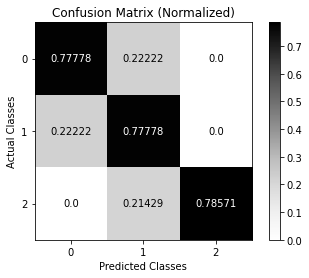

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.7919088319088319


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.78      0.78      0.78        18
Atypical Nevus       0.67      0.78      0.72        18
      Melanoma       1.00      0.79      0.88        14

      accuracy                           0.78        50
     macro avg       0.81      0.78      0.79        50
  weighted avg       0.80      0.78      0.78        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

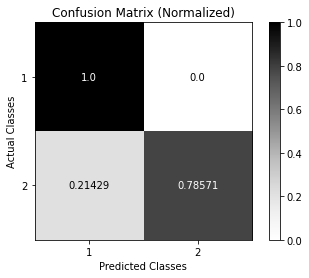

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.92


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.92      1.00      0.96        36
            Melanoma       1.00      0.79      0.88        14

            accuracy                           0.94        50
           macro avg       0.96      0.89      0.92        50
        weighted avg       0.94      0.94      0.94        50



## Inception + classes' balance + gaussian blur

In [ ]:
means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [ ]:
transformations = tt.Compose([
    tt.ToTensor(),
    tt.Resize((299, 299)),
    tt.Normalize(means, stds)
])

In [ ]:
train_images = array_to_tensor(transformations, train_images_array)
val_images = array_to_tensor(transformations, val_images_array)

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
#for now we have 26 items of class 2 and 62 for 1 & 0, so balance all of them
#to have 100 elements.
new_train_images, new_train_target = balance_classes(train_images, list(y_train), 100)

In [ ]:
#new_train_images, new_train_target = add_more_examples(new_train_images, list(new_train_target), augs_for_exp)

In [ ]:
new_train_images = make_it_harder(new_train_images, augs_for_complication)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images, new_train_target)), batch_size = 16, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = 16, shuffle=False)

In [ ]:
best_score = 0

In [ ]:
def objective(trial):
    global best_score
    inception = models.inception_v3(pretrained=True)

    for params in inception.parameters():
        params.requires_grad_(True)

    inception.AuxLogits.fc = nn.Sequential(
        nn.Linear(768, 3, bias=True),
        nn.Softmax())

    inception.fc = nn.Sequential(
        nn.Linear(2048, 3, bias=True),
        nn.Softmax())
    
    inception = inception.to(DEVICE)
    
    lr = trial.suggest_uniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-1)
    gamma = trial.suggest_uniform('gamma', 0.25, 0.75)

    optimizer = torch.optim.Adam(inception.parameters(), lr=lr,
                                            weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, 
                                            gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    history = train(inception, criterion, optimizer, 10, new_train_dataloader,
                val_dataloader, '/content/inception.pth', lr_scheduler, True)
    
    inception.load_state_dict(torch.load('/content/inception.pth'))
    
    loss, acc, val_loss, val_acc = zip(*history)

    if max(val_acc) > best_score:
        best_score = max(val_acc)
        torch.save(inception.state_dict(),
        '/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_balance_2.pth')

    return max(val_acc)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-05-05 19:21:23,197] A new study created in memory with name: no-name-5e08ac83-15a6-4504-a32b-cd6b956defee
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2947240034739176


epoch:  10%|█         | 1/10 [00:12<01:54, 12.70s/it]


Epoch 001 train_loss: 1.2947     val_loss 0.9104 train_acc 0.6133 val_acc 0.6200
loss on train 0.9861953083674113


epoch:  20%|██        | 2/10 [00:25<01:40, 12.54s/it]


Epoch 002 train_loss: 0.9862     val_loss 0.8151 train_acc 0.8433 val_acc 0.7400
loss on train 0.9157077836990356


epoch:  30%|███       | 3/10 [00:37<01:26, 12.35s/it]


Epoch 003 train_loss: 0.9157     val_loss 0.9042 train_acc 0.9033 val_acc 0.6600
loss on train 0.8730707454681397


epoch:  40%|████      | 4/10 [00:49<01:13, 12.23s/it]


Epoch 004 train_loss: 0.8731     val_loss 0.8595 train_acc 0.9233 val_acc 0.6600
loss on train 0.8619248986244201


epoch:  50%|█████     | 5/10 [01:01<01:00, 12.15s/it]


Epoch 005 train_loss: 0.8619     val_loss 0.8958 train_acc 0.9400 val_acc 0.6400
loss on train 0.8627873833974202


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.10s/it]


Epoch 006 train_loss: 0.8628     val_loss 0.9146 train_acc 0.9367 val_acc 0.6000
loss on train 0.8227405818303426


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.12s/it]


Epoch 007 train_loss: 0.8227     val_loss 0.8749 train_acc 0.9633 val_acc 0.6600
loss on train 0.8023507324854533


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.08s/it]


Epoch 008 train_loss: 0.8024     val_loss 0.8343 train_acc 0.9867 val_acc 0.7000
loss on train 0.8101792867978413


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.05s/it]


Epoch 009 train_loss: 0.8102     val_loss 0.8747 train_acc 0.9733 val_acc 0.6600
loss on train 0.8156877398490906


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.15s/it]



Epoch 010 train_loss: 0.8157     val_loss 0.8253 train_acc 0.9833 val_acc 0.7200


[I 2022-05-05 19:23:36,715] Trial 0 finished with value: 0.74 and parameters: {'lr': 0.00022874479342582612, 'weight_decay': 0.015067471369198402, 'gamma': 0.5558391966327745}. Best is trial 0 with value: 0.74.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.347884276707967


epoch:  10%|█         | 1/10 [00:12<01:51, 12.35s/it]


Epoch 001 train_loss: 1.3479     val_loss 0.9147 train_acc 0.5833 val_acc 0.5800
loss on train 0.9754440426826477


epoch:  20%|██        | 2/10 [00:24<01:38, 12.36s/it]


Epoch 002 train_loss: 0.9754     val_loss 0.7973 train_acc 0.8700 val_acc 0.7200
loss on train 0.9098975865046183


epoch:  30%|███       | 3/10 [00:36<01:25, 12.21s/it]


Epoch 003 train_loss: 0.9099     val_loss 0.8483 train_acc 0.8967 val_acc 0.6800
loss on train 0.8651218032836914


epoch:  40%|████      | 4/10 [00:48<01:12, 12.13s/it]


Epoch 004 train_loss: 0.8651     val_loss 0.8231 train_acc 0.9400 val_acc 0.7200
loss on train 0.815673451423645


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.09s/it]


Epoch 005 train_loss: 0.8157     val_loss 0.8176 train_acc 0.9767 val_acc 0.7200
loss on train 0.8159569136301676


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.14s/it]


Epoch 006 train_loss: 0.8160     val_loss 0.8519 train_acc 0.9733 val_acc 0.6600
loss on train 0.7938183387120564


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.21s/it]


Epoch 007 train_loss: 0.7938     val_loss 0.8084 train_acc 0.9867 val_acc 0.7600
loss on train 0.7921386178334554


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.14s/it]


Epoch 008 train_loss: 0.7921     val_loss 0.8598 train_acc 0.9833 val_acc 0.6600
loss on train 0.7823076423009236


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.10s/it]


Epoch 009 train_loss: 0.7823     val_loss 0.8567 train_acc 0.9967 val_acc 0.6800
loss on train 0.781605806350708


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.14s/it]



Epoch 010 train_loss: 0.7816     val_loss 0.8400 train_acc 0.9933 val_acc 0.6800


[I 2022-05-05 19:25:39,336] Trial 1 finished with value: 0.76 and parameters: {'lr': 0.00015274101143701086, 'weight_decay': 0.00027023850332051955, 'gamma': 0.4060557753552042}. Best is trial 1 with value: 0.76.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2340625365575155


epoch:  10%|█         | 1/10 [00:12<01:52, 12.52s/it]


Epoch 001 train_loss: 1.2341     val_loss 0.9133 train_acc 0.6533 val_acc 0.6200
loss on train 1.1127323134740195


epoch:  20%|██        | 2/10 [00:24<01:37, 12.20s/it]


Epoch 002 train_loss: 1.1127     val_loss 1.0569 train_acc 0.7533 val_acc 0.4400
loss on train 1.1576409594217936


epoch:  30%|███       | 3/10 [00:36<01:25, 12.28s/it]


Epoch 003 train_loss: 1.1576     val_loss 0.9793 train_acc 0.7167 val_acc 0.6600
loss on train 1.2671033509572347


epoch:  40%|████      | 4/10 [00:48<01:12, 12.14s/it]


Epoch 004 train_loss: 1.2671     val_loss 1.0155 train_acc 0.6433 val_acc 0.5200
loss on train 1.2088791704177857


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.06s/it]


Epoch 005 train_loss: 1.2089     val_loss 0.9587 train_acc 0.6800 val_acc 0.6200
loss on train 1.1857821702957154


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.14s/it]


Epoch 006 train_loss: 1.1858     val_loss 0.8852 train_acc 0.6967 val_acc 0.7000
loss on train 1.1033819071451823


epoch:  70%|███████   | 7/10 [01:24<00:36, 12.07s/it]


Epoch 007 train_loss: 1.1034     val_loss 0.8726 train_acc 0.7633 val_acc 0.6800
loss on train 1.1737102683385212


epoch:  80%|████████  | 8/10 [01:36<00:24, 12.03s/it]


Epoch 008 train_loss: 1.1737     val_loss 0.9438 train_acc 0.6967 val_acc 0.6000
loss on train 1.0656211964289348


epoch:  90%|█████████ | 9/10 [01:48<00:12, 12.00s/it]


Epoch 009 train_loss: 1.0656     val_loss 0.9362 train_acc 0.8067 val_acc 0.5600
loss on train 1.1319941695531208


epoch: 100%|██████████| 10/10 [02:00<00:00, 12.08s/it]



Epoch 010 train_loss: 1.1320     val_loss 1.0290 train_acc 0.7400 val_acc 0.4600


[I 2022-05-05 19:27:40,928] Trial 2 finished with value: 0.7 and parameters: {'lr': 0.000623793609128045, 'weight_decay': 0.04087534595719496, 'gamma': 0.3964152920632618}. Best is trial 1 with value: 0.76.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.5103367646535237


epoch:  10%|█         | 1/10 [00:12<01:51, 12.43s/it]


Epoch 001 train_loss: 1.5103     val_loss 1.0830 train_acc 0.4000 val_acc 0.3400
loss on train 1.4390114243825276


epoch:  20%|██        | 2/10 [00:24<01:39, 12.38s/it]


Epoch 002 train_loss: 1.4390     val_loss 1.0590 train_acc 0.4933 val_acc 0.4800
loss on train 1.3633064174652099


epoch:  30%|███       | 3/10 [00:37<01:26, 12.36s/it]


Epoch 003 train_loss: 1.3633     val_loss 1.0434 train_acc 0.6300 val_acc 0.5800
loss on train 1.2790607865651449


epoch:  40%|████      | 4/10 [00:49<01:14, 12.36s/it]


Epoch 004 train_loss: 1.2791     val_loss 1.0150 train_acc 0.7967 val_acc 0.6200
loss on train 1.2428974930445353


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.23s/it]


Epoch 005 train_loss: 1.2429     val_loss 0.9888 train_acc 0.7867 val_acc 0.5600
loss on train 1.1833596086502076


epoch:  60%|██████    | 6/10 [01:13<00:49, 12.27s/it]


Epoch 006 train_loss: 1.1834     val_loss 0.9821 train_acc 0.8533 val_acc 0.6600
loss on train 1.1557183249791463


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.19s/it]


Epoch 007 train_loss: 1.1557     val_loss 0.9764 train_acc 0.8600 val_acc 0.6600
loss on train 1.1423715861638386


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.14s/it]


Epoch 008 train_loss: 1.1424     val_loss 0.9722 train_acc 0.8733 val_acc 0.6400
loss on train 1.1159613688786825


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.09s/it]


Epoch 009 train_loss: 1.1160     val_loss 0.9698 train_acc 0.8767 val_acc 0.6400
loss on train 1.0906153885523477


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.19s/it]



Epoch 010 train_loss: 1.0906     val_loss 0.9646 train_acc 0.9233 val_acc 0.6400


[I 2022-05-05 19:29:43,606] Trial 3 finished with value: 0.66 and parameters: {'lr': 1.2917510804272807e-05, 'weight_decay': 0.010801301082790942, 'gamma': 0.29656581052465153}. Best is trial 1 with value: 0.76.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3416515811284384


epoch:  10%|█         | 1/10 [00:12<01:50, 12.27s/it]


Epoch 001 train_loss: 1.3417     val_loss 0.9665 train_acc 0.5667 val_acc 0.5800
loss on train 1.28842068195343


epoch:  20%|██        | 2/10 [00:24<01:36, 12.11s/it]


Epoch 002 train_loss: 1.2884     val_loss 1.0864 train_acc 0.6200 val_acc 0.4200
loss on train 1.2285119120279948


epoch:  30%|███       | 3/10 [00:36<01:24, 12.06s/it]


Epoch 003 train_loss: 1.2285     val_loss 0.9820 train_acc 0.6933 val_acc 0.5400
loss on train 1.2407412465413412


epoch:  40%|████      | 4/10 [00:48<01:12, 12.02s/it]


Epoch 004 train_loss: 1.2407     val_loss 1.1924 train_acc 0.6433 val_acc 0.3600
loss on train 1.2094910192489623


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.39s/it]


Epoch 005 train_loss: 1.2095     val_loss 1.0290 train_acc 0.6867 val_acc 0.5200
loss on train 1.223474817276001


epoch:  60%|██████    | 6/10 [01:13<00:49, 12.33s/it]


Epoch 006 train_loss: 1.2235     val_loss 1.1143 train_acc 0.6667 val_acc 0.4200
loss on train 1.297270180384318


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.20s/it]


Epoch 007 train_loss: 1.2973     val_loss 0.9965 train_acc 0.6033 val_acc 0.4800
loss on train 1.2554286193847657


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.12s/it]


Epoch 008 train_loss: 1.2554     val_loss 0.9487 train_acc 0.6333 val_acc 0.5800
loss on train 1.2986078961690266


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.06s/it]


Epoch 009 train_loss: 1.2986     val_loss 1.0878 train_acc 0.5967 val_acc 0.4200
loss on train 1.2223129781087239


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.13s/it]



Epoch 010 train_loss: 1.2223     val_loss 1.0021 train_acc 0.6567 val_acc 0.4600


[I 2022-05-05 19:31:45,601] Trial 4 finished with value: 0.58 and parameters: {'lr': 0.0009756695774760327, 'weight_decay': 0.0017471798304393791, 'gamma': 0.6779864461923395}. Best is trial 1 with value: 0.76.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2991820176442463


epoch:  10%|█         | 1/10 [00:12<01:53, 12.59s/it]


Epoch 001 train_loss: 1.2992     val_loss 0.8890 train_acc 0.6333 val_acc 0.6400
loss on train 0.9960102367401124


epoch:  20%|██        | 2/10 [00:24<01:39, 12.41s/it]


Epoch 002 train_loss: 0.9960     val_loss 0.8979 train_acc 0.8300 val_acc 0.6800
loss on train 0.9256072425842286


epoch:  30%|███       | 3/10 [00:36<01:25, 12.21s/it]


Epoch 003 train_loss: 0.9256     val_loss 0.9064 train_acc 0.8967 val_acc 0.6200
loss on train 0.92324951171875


epoch:  40%|████      | 4/10 [00:48<01:12, 12.13s/it]


Epoch 004 train_loss: 0.9232     val_loss 0.8953 train_acc 0.8767 val_acc 0.6200
loss on train 0.9121286296844482


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.21s/it]


Epoch 005 train_loss: 0.9121     val_loss 0.7669 train_acc 0.8967 val_acc 0.7800
loss on train 0.8670065474510192


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.15s/it]


Epoch 006 train_loss: 0.8670     val_loss 0.8792 train_acc 0.9367 val_acc 0.6400
loss on train 0.8329591766993205


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.11s/it]


Epoch 007 train_loss: 0.8330     val_loss 0.8403 train_acc 0.9533 val_acc 0.7200
loss on train 0.8077748688062032


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.09s/it]


Epoch 008 train_loss: 0.8078     val_loss 0.8278 train_acc 0.9767 val_acc 0.7000
loss on train 0.7988760622342428


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.07s/it]


Epoch 009 train_loss: 0.7989     val_loss 0.8276 train_acc 0.9867 val_acc 0.7000
loss on train 0.8060245188077291


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.14s/it]



Epoch 010 train_loss: 0.8060     val_loss 0.8266 train_acc 0.9733 val_acc 0.7000


[I 2022-05-05 19:33:48,588] Trial 5 finished with value: 0.78 and parameters: {'lr': 0.00027344287171351646, 'weight_decay': 0.0005751614853489232, 'gamma': 0.40924983396987724}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.320145740509033


epoch:  10%|█         | 1/10 [00:12<01:52, 12.47s/it]


Epoch 001 train_loss: 1.3201     val_loss 1.0717 train_acc 0.5867 val_acc 0.4600
loss on train 1.2863158814112345


epoch:  20%|██        | 2/10 [00:24<01:37, 12.18s/it]


Epoch 002 train_loss: 1.2863     val_loss 1.0976 train_acc 0.6233 val_acc 0.4000
loss on train 1.2407286977767944


epoch:  30%|███       | 3/10 [00:36<01:26, 12.32s/it]


Epoch 003 train_loss: 1.2407     val_loss 0.8993 train_acc 0.6600 val_acc 0.6600
loss on train 1.237389472325643


epoch:  40%|████      | 4/10 [00:48<01:13, 12.19s/it]


Epoch 004 train_loss: 1.2374     val_loss 0.9424 train_acc 0.6467 val_acc 0.6000
loss on train 1.1853308057785035


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.13s/it]


Epoch 005 train_loss: 1.1853     val_loss 0.9981 train_acc 0.6867 val_acc 0.5200
loss on train 1.082957960764567


epoch:  60%|██████    | 6/10 [01:12<00:48, 12.07s/it]


Epoch 006 train_loss: 1.0830     val_loss 0.9783 train_acc 0.7833 val_acc 0.5600
loss on train 1.065991252263387


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.14s/it]


Epoch 007 train_loss: 1.0660     val_loss 0.8437 train_acc 0.7800 val_acc 0.6800
loss on train 0.9535884062449137


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.07s/it]


Epoch 008 train_loss: 0.9536     val_loss 0.9086 train_acc 0.8800 val_acc 0.6200
loss on train 1.0193275165557862


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.14s/it]


Epoch 009 train_loss: 1.0193     val_loss 0.8370 train_acc 0.8267 val_acc 0.7000
loss on train 0.9937820982933044


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.14s/it]



Epoch 010 train_loss: 0.9938     val_loss 0.9028 train_acc 0.8400 val_acc 0.6400


[I 2022-05-05 19:35:50,795] Trial 6 finished with value: 0.7 and parameters: {'lr': 0.00086711602973205, 'weight_decay': 0.0007333391311632301, 'gamma': 0.5192007727402684}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3563373215993246


epoch:  10%|█         | 1/10 [00:12<01:50, 12.28s/it]


Epoch 001 train_loss: 1.3563     val_loss 0.9287 train_acc 0.5400 val_acc 0.6000
loss on train 1.2121757968266804


epoch:  20%|██        | 2/10 [00:24<01:36, 12.11s/it]


Epoch 002 train_loss: 1.2122     val_loss 0.9526 train_acc 0.6767 val_acc 0.5600
loss on train 1.1862476778030395


epoch:  30%|███       | 3/10 [00:36<01:24, 12.05s/it]


Epoch 003 train_loss: 1.1862     val_loss 1.0210 train_acc 0.6733 val_acc 0.5200
loss on train 1.2369168361028036


epoch:  40%|████      | 4/10 [00:48<01:12, 12.02s/it]


Epoch 004 train_loss: 1.2369     val_loss 1.2560 train_acc 0.6633 val_acc 0.2800
loss on train 1.1687403917312622


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.00s/it]


Epoch 005 train_loss: 1.1687     val_loss 1.0986 train_acc 0.7167 val_acc 0.4000
loss on train 1.1408498430252074


epoch:  60%|██████    | 6/10 [01:12<00:47, 11.99s/it]


Epoch 006 train_loss: 1.1408     val_loss 1.0614 train_acc 0.7100 val_acc 0.4200
loss on train 1.0636517016092937


epoch:  70%|███████   | 7/10 [01:24<00:36, 12.08s/it]


Epoch 007 train_loss: 1.0637     val_loss 0.8853 train_acc 0.8000 val_acc 0.6200
loss on train 1.0272628084818523


epoch:  80%|████████  | 8/10 [01:36<00:24, 12.13s/it]


Epoch 008 train_loss: 1.0273     val_loss 0.9059 train_acc 0.8267 val_acc 0.6600
loss on train 0.9857774066925049


epoch:  90%|█████████ | 9/10 [01:48<00:12, 12.08s/it]


Epoch 009 train_loss: 0.9858     val_loss 0.9616 train_acc 0.8533 val_acc 0.5600
loss on train 0.9855788628260295


epoch: 100%|██████████| 10/10 [02:00<00:00, 12.06s/it]



Epoch 010 train_loss: 0.9856     val_loss 0.8845 train_acc 0.8367 val_acc 0.6600


[I 2022-05-05 19:37:52,182] Trial 7 finished with value: 0.66 and parameters: {'lr': 0.000790217676414351, 'weight_decay': 0.0032191417746421686, 'gamma': 0.45951823772618633}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.30344500541687


epoch:  10%|█         | 1/10 [00:12<01:50, 12.32s/it]


Epoch 001 train_loss: 1.3034     val_loss 0.9734 train_acc 0.6133 val_acc 0.5800
loss on train 1.296703782081604


epoch:  20%|██        | 2/10 [00:24<01:36, 12.12s/it]


Epoch 002 train_loss: 1.2967     val_loss 0.9707 train_acc 0.5833 val_acc 0.5800
loss on train 1.294296620686849


epoch:  30%|███       | 3/10 [00:36<01:24, 12.07s/it]


Epoch 003 train_loss: 1.2943     val_loss 0.9967 train_acc 0.6167 val_acc 0.5800
loss on train 1.3382508977254233


epoch:  40%|████      | 4/10 [00:48<01:12, 12.04s/it]


Epoch 004 train_loss: 1.3383     val_loss 1.0786 train_acc 0.6000 val_acc 0.4000
loss on train 1.3442188390096028


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.01s/it]


Epoch 005 train_loss: 1.3442     val_loss 1.3116 train_acc 0.5733 val_acc 0.2400
loss on train 1.3532437976201375


epoch:  60%|██████    | 6/10 [01:12<00:47, 12.00s/it]


Epoch 006 train_loss: 1.3532     val_loss 1.0694 train_acc 0.5900 val_acc 0.4800
loss on train 1.260422952969869


epoch:  70%|███████   | 7/10 [01:24<00:35, 11.98s/it]


Epoch 007 train_loss: 1.2604     val_loss 1.1025 train_acc 0.6400 val_acc 0.4200
loss on train 1.253674856821696


epoch:  80%|████████  | 8/10 [01:36<00:23, 11.97s/it]


Epoch 008 train_loss: 1.2537     val_loss 1.0586 train_acc 0.5967 val_acc 0.4200
loss on train 1.2779367192586264


epoch:  90%|█████████ | 9/10 [01:48<00:12, 12.07s/it]


Epoch 009 train_loss: 1.2779     val_loss 0.9492 train_acc 0.6133 val_acc 0.6000
loss on train 1.2185841290156048


epoch: 100%|██████████| 10/10 [02:00<00:00, 12.08s/it]



Epoch 010 train_loss: 1.2186     val_loss 0.9246 train_acc 0.6500 val_acc 0.6200


[I 2022-05-05 19:39:53,721] Trial 8 finished with value: 0.62 and parameters: {'lr': 0.0009048997671523367, 'weight_decay': 0.003841432848174215, 'gamma': 0.6592838580500162}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2497524913152058


epoch:  10%|█         | 1/10 [00:12<01:50, 12.31s/it]


Epoch 001 train_loss: 1.2498     val_loss 0.8511 train_acc 0.6467 val_acc 0.7200
loss on train 0.9705999358495077


epoch:  20%|██        | 2/10 [00:24<01:37, 12.14s/it]


Epoch 002 train_loss: 0.9706     val_loss 0.8822 train_acc 0.8533 val_acc 0.6600
loss on train 0.9406958810488383


epoch:  30%|███       | 3/10 [00:36<01:24, 12.10s/it]


Epoch 003 train_loss: 0.9407     val_loss 0.9181 train_acc 0.8800 val_acc 0.6600
loss on train 0.9519511127471924


epoch:  40%|████      | 4/10 [00:48<01:12, 12.06s/it]


Epoch 004 train_loss: 0.9520     val_loss 1.0090 train_acc 0.8667 val_acc 0.5200
loss on train 0.9900020869572957


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.05s/it]


Epoch 005 train_loss: 0.9900     val_loss 0.9226 train_acc 0.8333 val_acc 0.6000
loss on train 0.9123507269223531


epoch:  60%|██████    | 6/10 [01:12<00:48, 12.07s/it]


Epoch 006 train_loss: 0.9124     val_loss 0.8629 train_acc 0.9000 val_acc 0.7000
loss on train 0.8530921697616577


epoch:  70%|███████   | 7/10 [01:24<00:36, 12.16s/it]


Epoch 007 train_loss: 0.8531     val_loss 0.8152 train_acc 0.9433 val_acc 0.7400
loss on train 0.8616243116060893


epoch:  80%|████████  | 8/10 [01:36<00:24, 12.12s/it]


Epoch 008 train_loss: 0.8616     val_loss 0.8344 train_acc 0.9200 val_acc 0.7400
loss on train 0.839746158917745


epoch:  90%|█████████ | 9/10 [01:48<00:12, 12.08s/it]


Epoch 009 train_loss: 0.8397     val_loss 0.8205 train_acc 0.9467 val_acc 0.7400
loss on train 0.8119746764500936


epoch: 100%|██████████| 10/10 [02:00<00:00, 12.09s/it]



Epoch 010 train_loss: 0.8120     val_loss 0.8399 train_acc 0.9733 val_acc 0.7000


[I 2022-05-05 19:41:55,456] Trial 9 finished with value: 0.74 and parameters: {'lr': 0.0003857626399050972, 'weight_decay': 0.0012912095914659558, 'gamma': 0.5974068393157304}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2651181062062582


epoch:  10%|█         | 1/10 [00:12<01:51, 12.34s/it]


Epoch 001 train_loss: 1.2651     val_loss 0.9508 train_acc 0.6233 val_acc 0.5800
loss on train 1.0306379667917887


epoch:  20%|██        | 2/10 [00:24<01:38, 12.33s/it]


Epoch 002 train_loss: 1.0306     val_loss 0.9358 train_acc 0.8267 val_acc 0.6400
loss on train 1.0912065108617146


epoch:  30%|███       | 3/10 [00:36<01:25, 12.17s/it]


Epoch 003 train_loss: 1.0912     val_loss 1.1380 train_acc 0.7667 val_acc 0.4000
loss on train 1.0605607064565024


epoch:  40%|████      | 4/10 [00:48<01:12, 12.10s/it]


Epoch 004 train_loss: 1.0606     val_loss 1.0554 train_acc 0.7733 val_acc 0.4800
loss on train 1.0522810204823811


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.07s/it]


Epoch 005 train_loss: 1.0523     val_loss 0.9491 train_acc 0.7933 val_acc 0.5800
loss on train 0.9839909092585246


epoch:  60%|██████    | 6/10 [01:12<00:48, 12.04s/it]


Epoch 006 train_loss: 0.9840     val_loss 0.9443 train_acc 0.8467 val_acc 0.5600
loss on train 0.8993037954966228


epoch:  70%|███████   | 7/10 [01:24<00:36, 12.02s/it]


Epoch 007 train_loss: 0.8993     val_loss 0.9518 train_acc 0.8967 val_acc 0.5800
loss on train 0.8530162946383159


epoch:  80%|████████  | 8/10 [01:36<00:24, 12.12s/it]


Epoch 008 train_loss: 0.8530     val_loss 0.8971 train_acc 0.9367 val_acc 0.6600
loss on train 0.8165751655896505


epoch:  90%|█████████ | 9/10 [01:48<00:12, 12.08s/it]


Epoch 009 train_loss: 0.8166     val_loss 0.9306 train_acc 0.9767 val_acc 0.6400
loss on train 0.8094290391604105


epoch: 100%|██████████| 10/10 [02:00<00:00, 12.09s/it]



Epoch 010 train_loss: 0.8094     val_loss 0.9070 train_acc 0.9767 val_acc 0.6200


[I 2022-05-05 19:43:57,157] Trial 10 finished with value: 0.66 and parameters: {'lr': 0.00048679305431756115, 'weight_decay': 0.00013833416572901487, 'gamma': 0.26820444835320234}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.288200577100118


epoch:  10%|█         | 1/10 [00:12<01:50, 12.29s/it]


Epoch 001 train_loss: 1.2882     val_loss 0.8837 train_acc 0.6333 val_acc 0.6400
loss on train 0.9474059653282165


epoch:  20%|██        | 2/10 [00:24<01:38, 12.31s/it]


Epoch 002 train_loss: 0.9474     val_loss 0.8298 train_acc 0.8833 val_acc 0.7400
loss on train 0.8523760692278544


epoch:  30%|███       | 3/10 [00:36<01:25, 12.17s/it]


Epoch 003 train_loss: 0.8524     val_loss 0.8609 train_acc 0.9600 val_acc 0.6400
loss on train 0.8535377780596415


epoch:  40%|████      | 4/10 [00:48<01:12, 12.10s/it]


Epoch 004 train_loss: 0.8535     val_loss 0.8245 train_acc 0.9400 val_acc 0.7200
loss on train 0.8164881300926209


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.08s/it]


Epoch 005 train_loss: 0.8165     val_loss 0.8585 train_acc 0.9700 val_acc 0.6800
loss on train 0.8126115385691325


epoch:  60%|██████    | 6/10 [01:12<00:48, 12.07s/it]


Epoch 006 train_loss: 0.8126     val_loss 0.8733 train_acc 0.9700 val_acc 0.6800
loss on train 0.7919413566589355


epoch:  70%|███████   | 7/10 [01:24<00:36, 12.06s/it]


Epoch 007 train_loss: 0.7919     val_loss 0.8850 train_acc 0.9967 val_acc 0.6800
loss on train 0.7908328676223755


epoch:  80%|████████  | 8/10 [01:36<00:24, 12.04s/it]


Epoch 008 train_loss: 0.7908     val_loss 0.8119 train_acc 0.9867 val_acc 0.7000
loss on train 0.7906925288836161


epoch:  90%|█████████ | 9/10 [01:48<00:12, 12.03s/it]


Epoch 009 train_loss: 0.7907     val_loss 0.8079 train_acc 0.9900 val_acc 0.7400
loss on train 0.7794497323036194


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.11s/it]



Epoch 010 train_loss: 0.7794     val_loss 0.8097 train_acc 1.0000 val_acc 0.7600


[I 2022-05-05 19:45:59,035] Trial 11 finished with value: 0.76 and parameters: {'lr': 0.00016975177720323097, 'weight_decay': 0.00029108800732351875, 'gamma': 0.3837220381497198}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2645979754130046


epoch:  10%|█         | 1/10 [00:12<01:51, 12.34s/it]


Epoch 001 train_loss: 1.2646     val_loss 0.9135 train_acc 0.6633 val_acc 0.6200
loss on train 0.980345163345337


epoch:  20%|██        | 2/10 [00:24<01:38, 12.36s/it]


Epoch 002 train_loss: 0.9803     val_loss 0.8169 train_acc 0.8667 val_acc 0.7400
loss on train 0.947031847635905


epoch:  30%|███       | 3/10 [00:36<01:25, 12.20s/it]


Epoch 003 train_loss: 0.9470     val_loss 0.8552 train_acc 0.8533 val_acc 0.6800
loss on train 0.8922232039769491


epoch:  40%|████      | 4/10 [00:48<01:12, 12.13s/it]


Epoch 004 train_loss: 0.8922     val_loss 0.8375 train_acc 0.9133 val_acc 0.7000
loss on train 0.8809386126200358


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.10s/it]


Epoch 005 train_loss: 0.8809     val_loss 0.8487 train_acc 0.9200 val_acc 0.6800
loss on train 0.857343053817749


epoch:  60%|██████    | 6/10 [01:12<00:48, 12.06s/it]


Epoch 006 train_loss: 0.8573     val_loss 0.8571 train_acc 0.9333 val_acc 0.6600
loss on train 0.8045389000574747


epoch:  70%|███████   | 7/10 [01:24<00:36, 12.04s/it]


Epoch 007 train_loss: 0.8045     val_loss 0.8757 train_acc 0.9800 val_acc 0.6600
loss on train 0.8087798396746317


epoch:  80%|████████  | 8/10 [01:36<00:24, 12.02s/it]


Epoch 008 train_loss: 0.8088     val_loss 0.8877 train_acc 0.9700 val_acc 0.6600
loss on train 0.7891171423594157


epoch:  90%|█████████ | 9/10 [01:48<00:12, 12.02s/it]


Epoch 009 train_loss: 0.7891     val_loss 0.8818 train_acc 0.9900 val_acc 0.6600
loss on train 0.7960434222221374


epoch: 100%|██████████| 10/10 [02:00<00:00, 12.08s/it]



Epoch 010 train_loss: 0.7960     val_loss 0.8767 train_acc 0.9833 val_acc 0.6600


[I 2022-05-05 19:48:00,584] Trial 12 finished with value: 0.74 and parameters: {'lr': 0.00027443898031029323, 'weight_decay': 0.00037188748939076673, 'gamma': 0.40616130066384437}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.494617722829183


epoch:  10%|█         | 1/10 [00:12<01:51, 12.36s/it]


Epoch 001 train_loss: 1.4946     val_loss 1.0425 train_acc 0.4267 val_acc 0.6000
loss on train 1.3326269976298015


epoch:  20%|██        | 2/10 [00:24<01:38, 12.36s/it]


Epoch 002 train_loss: 1.3326     val_loss 1.0070 train_acc 0.6767 val_acc 0.6800
loss on train 1.1900573205947875


epoch:  30%|███       | 3/10 [00:36<01:25, 12.22s/it]


Epoch 003 train_loss: 1.1901     val_loss 0.9702 train_acc 0.8167 val_acc 0.6200
loss on train 1.0980081303914389


epoch:  40%|████      | 4/10 [00:48<01:12, 12.15s/it]


Epoch 004 train_loss: 1.0980     val_loss 0.9451 train_acc 0.8600 val_acc 0.6600
loss on train 1.0189974848429362


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.10s/it]


Epoch 005 train_loss: 1.0190     val_loss 0.9280 train_acc 0.9067 val_acc 0.6400
loss on train 0.9438935661315918


epoch:  60%|██████    | 6/10 [01:12<00:48, 12.08s/it]


Epoch 006 train_loss: 0.9439     val_loss 0.9253 train_acc 0.9300 val_acc 0.6400
loss on train 0.911136794090271


epoch:  70%|███████   | 7/10 [01:24<00:36, 12.05s/it]


Epoch 007 train_loss: 0.9111     val_loss 0.9186 train_acc 0.9733 val_acc 0.6200
loss on train 0.9086887725194295


epoch:  80%|████████  | 8/10 [01:36<00:24, 12.04s/it]


Epoch 008 train_loss: 0.9087     val_loss 0.9299 train_acc 0.9667 val_acc 0.6000
loss on train 0.8762505197525025


epoch:  90%|█████████ | 9/10 [01:48<00:12, 12.05s/it]


Epoch 009 train_loss: 0.8763     val_loss 0.9272 train_acc 0.9800 val_acc 0.5800
loss on train 0.8656783278783162


epoch: 100%|██████████| 10/10 [02:00<00:00, 12.10s/it]



Epoch 010 train_loss: 0.8657     val_loss 0.9250 train_acc 0.9867 val_acc 0.5400


[I 2022-05-05 19:50:02,331] Trial 13 finished with value: 0.68 and parameters: {'lr': 2.55694268537514e-05, 'weight_decay': 0.00010899198745321203, 'gamma': 0.34711249801031513}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2874961884816487


epoch:  10%|█         | 1/10 [00:12<01:50, 12.30s/it]


Epoch 001 train_loss: 1.2875     val_loss 0.8895 train_acc 0.6500 val_acc 0.6800
loss on train 1.0030247211456298


epoch:  20%|██        | 2/10 [00:24<01:38, 12.34s/it]


Epoch 002 train_loss: 1.0030     val_loss 0.8199 train_acc 0.8433 val_acc 0.7200
loss on train 0.9816968131065369


epoch:  30%|███       | 3/10 [00:36<01:25, 12.18s/it]


Epoch 003 train_loss: 0.9817     val_loss 0.9078 train_acc 0.8433 val_acc 0.6200
loss on train 0.9572952890396118


epoch:  40%|████      | 4/10 [00:48<01:12, 12.12s/it]


Epoch 004 train_loss: 0.9573     val_loss 0.8941 train_acc 0.8667 val_acc 0.6400
loss on train 0.9271341816584269


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.08s/it]


Epoch 005 train_loss: 0.9271     val_loss 0.9828 train_acc 0.8967 val_acc 0.5400
loss on train 0.9203817272186279


epoch:  60%|██████    | 6/10 [01:12<00:48, 12.06s/it]


Epoch 006 train_loss: 0.9204     val_loss 0.8752 train_acc 0.8933 val_acc 0.6600
loss on train 0.8332957458496094


epoch:  70%|███████   | 7/10 [01:24<00:36, 12.06s/it]


Epoch 007 train_loss: 0.8333     val_loss 0.8632 train_acc 0.9567 val_acc 0.6800
loss on train 0.8120107428232829


epoch:  80%|████████  | 8/10 [01:36<00:24, 12.04s/it]


Epoch 008 train_loss: 0.8120     val_loss 0.8975 train_acc 0.9700 val_acc 0.6400
loss on train 0.8238307889302572


epoch:  90%|█████████ | 9/10 [01:48<00:12, 12.03s/it]


Epoch 009 train_loss: 0.8238     val_loss 0.8802 train_acc 0.9633 val_acc 0.6800
loss on train 0.8055711062749227


epoch: 100%|██████████| 10/10 [02:00<00:00, 12.08s/it]



Epoch 010 train_loss: 0.8056     val_loss 0.9207 train_acc 0.9800 val_acc 0.5800


[I 2022-05-05 19:52:03,897] Trial 14 finished with value: 0.72 and parameters: {'lr': 0.0003581388881064001, 'weight_decay': 0.00043346646893501926, 'gamma': 0.45103340433931977}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.336499694188436


epoch:  10%|█         | 1/10 [00:12<01:51, 12.41s/it]


Epoch 001 train_loss: 1.3365     val_loss 0.8660 train_acc 0.5667 val_acc 0.7200
loss on train 0.9825972080230713


epoch:  20%|██        | 2/10 [00:24<01:37, 12.18s/it]


Epoch 002 train_loss: 0.9826     val_loss 0.9032 train_acc 0.8733 val_acc 0.6200
loss on train 0.8781378809611002


epoch:  30%|███       | 3/10 [00:36<01:24, 12.12s/it]


Epoch 003 train_loss: 0.8781     val_loss 0.8742 train_acc 0.9433 val_acc 0.6400
loss on train 0.8461149374643961


epoch:  40%|████      | 4/10 [00:48<01:12, 12.08s/it]


Epoch 004 train_loss: 0.8461     val_loss 0.8566 train_acc 0.9433 val_acc 0.7000
loss on train 0.8076901499430339


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.06s/it]


Epoch 005 train_loss: 0.8077     val_loss 0.8646 train_acc 0.9867 val_acc 0.6600
loss on train 0.8073205097516378


epoch:  60%|██████    | 6/10 [01:12<00:48, 12.05s/it]


Epoch 006 train_loss: 0.8073     val_loss 0.8488 train_acc 0.9733 val_acc 0.7200
loss on train 0.8193884976704915


epoch:  70%|███████   | 7/10 [01:24<00:36, 12.04s/it]


Epoch 007 train_loss: 0.8194     val_loss 0.8646 train_acc 0.9667 val_acc 0.7000
loss on train 0.7952226130167643


epoch:  80%|████████  | 8/10 [01:36<00:24, 12.02s/it]


Epoch 008 train_loss: 0.7952     val_loss 0.8617 train_acc 0.9867 val_acc 0.6600
loss on train 0.7989474678039551


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.49s/it]


Epoch 009 train_loss: 0.7989     val_loss 0.8285 train_acc 0.9833 val_acc 0.7000
loss on train 0.7976608880360921


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.29s/it]



Epoch 010 train_loss: 0.7977     val_loss 0.8372 train_acc 0.9833 val_acc 0.7400


[I 2022-05-05 19:54:07,615] Trial 15 finished with value: 0.74 and parameters: {'lr': 0.0001746151168091936, 'weight_decay': 0.00021323749768623334, 'gamma': 0.7409940959787613}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2997487624486288


epoch:  10%|█         | 1/10 [00:12<01:50, 12.32s/it]


Epoch 001 train_loss: 1.2997     val_loss 0.8616 train_acc 0.6200 val_acc 0.7000
loss on train 1.1379753208160401


epoch:  20%|██        | 2/10 [00:24<01:38, 12.31s/it]


Epoch 002 train_loss: 1.1380     val_loss 0.8447 train_acc 0.7400 val_acc 0.7200
loss on train 1.1240050808588664


epoch:  30%|███       | 3/10 [00:36<01:25, 12.18s/it]


Epoch 003 train_loss: 1.1240     val_loss 0.9156 train_acc 0.7367 val_acc 0.5800
loss on train 1.1083149401346843


epoch:  40%|████      | 4/10 [00:48<01:12, 12.11s/it]


Epoch 004 train_loss: 1.1083     val_loss 0.8845 train_acc 0.7600 val_acc 0.6400
loss on train 0.9955541817347209


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.08s/it]


Epoch 005 train_loss: 0.9956     val_loss 0.9399 train_acc 0.8367 val_acc 0.6200
loss on train 0.9100177478790283


epoch:  60%|██████    | 6/10 [01:12<00:48, 12.06s/it]


Epoch 006 train_loss: 0.9100     val_loss 0.8359 train_acc 0.8867 val_acc 0.7200
loss on train 0.876600116888682


epoch:  70%|███████   | 7/10 [01:24<00:36, 12.06s/it]


Epoch 007 train_loss: 0.8766     val_loss 0.8609 train_acc 0.9200 val_acc 0.6800
loss on train 0.911213420232137


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.19s/it]


Epoch 008 train_loss: 0.9112     val_loss 0.8487 train_acc 0.8900 val_acc 0.7400
loss on train 0.8671894772847494


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.14s/it]


Epoch 009 train_loss: 0.8672     val_loss 0.8980 train_acc 0.9433 val_acc 0.6400
loss on train 0.841867003440857


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.13s/it]



Epoch 010 train_loss: 0.8419     val_loss 0.8769 train_acc 0.9500 val_acc 0.6800


[I 2022-05-05 19:56:09,719] Trial 16 finished with value: 0.74 and parameters: {'lr': 0.0005599132947951708, 'weight_decay': 0.0008845026615110669, 'gamma': 0.3296105245567056}. Best is trial 5 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.416046552658081


epoch:  10%|█         | 1/10 [00:12<01:51, 12.35s/it]


Epoch 001 train_loss: 1.4160     val_loss 0.9640 train_acc 0.5367 val_acc 0.6400
loss on train 1.0820952161153157


epoch:  20%|██        | 2/10 [00:24<01:38, 12.35s/it]


Epoch 002 train_loss: 1.0821     val_loss 0.8776 train_acc 0.8400 val_acc 0.7200
loss on train 0.9072218203544616


epoch:  30%|███       | 3/10 [00:37<01:26, 12.35s/it]


Epoch 003 train_loss: 0.9072     val_loss 0.8487 train_acc 0.9467 val_acc 0.7400
loss on train 0.808795264561971


epoch:  40%|████      | 4/10 [00:49<01:13, 12.24s/it]


Epoch 004 train_loss: 0.8088     val_loss 0.8507 train_acc 0.9933 val_acc 0.7000
loss on train 0.7890494338671367


epoch:  50%|█████     | 5/10 [01:01<01:00, 12.15s/it]


Epoch 005 train_loss: 0.7890     val_loss 0.8451 train_acc 1.0000 val_acc 0.7000
loss on train 0.8064131609598796


epoch:  60%|██████    | 6/10 [01:13<00:49, 12.29s/it]


Epoch 006 train_loss: 0.8064     val_loss 0.7870 train_acc 0.9833 val_acc 0.8000
loss on train 0.7962069964408874


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.21s/it]


Epoch 007 train_loss: 0.7962     val_loss 0.8192 train_acc 0.9900 val_acc 0.7400
loss on train 0.8032309087117513


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.16s/it]


Epoch 008 train_loss: 0.8032     val_loss 0.8318 train_acc 0.9833 val_acc 0.7400
loss on train 0.7991162300109863


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.13s/it]


Epoch 009 train_loss: 0.7991     val_loss 0.8604 train_acc 0.9867 val_acc 0.7000
loss on train 0.7812816691398621


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.18s/it]



Epoch 010 train_loss: 0.7813     val_loss 0.8547 train_acc 0.9967 val_acc 0.7000


[I 2022-05-05 19:58:12,776] Trial 17 finished with value: 0.8 and parameters: {'lr': 8.073975346353234e-05, 'weight_decay': 0.0005414097343790165, 'gamma': 0.48193545588425535}. Best is trial 17 with value: 0.8.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.28975323677063


epoch:  10%|█         | 1/10 [00:12<01:52, 12.48s/it]


Epoch 001 train_loss: 1.2898     val_loss 0.8908 train_acc 0.6033 val_acc 0.6800
loss on train 1.0372232580184937


epoch:  20%|██        | 2/10 [00:24<01:39, 12.40s/it]


Epoch 002 train_loss: 1.0372     val_loss 0.8257 train_acc 0.8067 val_acc 0.7200
loss on train 1.0116541147232057


epoch:  30%|███       | 3/10 [00:36<01:25, 12.23s/it]


Epoch 003 train_loss: 1.0117     val_loss 0.9464 train_acc 0.8167 val_acc 0.5600
loss on train 0.9720176760355631


epoch:  40%|████      | 4/10 [00:48<01:12, 12.14s/it]


Epoch 004 train_loss: 0.9720     val_loss 0.9258 train_acc 0.8567 val_acc 0.5600
loss on train 0.8968402322133382


epoch:  50%|█████     | 5/10 [01:01<01:00, 12.17s/it]


Epoch 005 train_loss: 0.8968     val_loss 0.9082 train_acc 0.9233 val_acc 0.6200
loss on train 0.9072250747680664


epoch:  60%|██████    | 6/10 [01:13<00:48, 12.12s/it]


Epoch 006 train_loss: 0.9072     val_loss 0.9330 train_acc 0.9000 val_acc 0.5800
loss on train 0.8399863608678182


epoch:  70%|███████   | 7/10 [01:25<00:36, 12.09s/it]


Epoch 007 train_loss: 0.8400     val_loss 0.8820 train_acc 0.9567 val_acc 0.6800
loss on train 0.868223967552185


epoch:  80%|████████  | 8/10 [01:37<00:24, 12.07s/it]


Epoch 008 train_loss: 0.8682     val_loss 0.9024 train_acc 0.9300 val_acc 0.6200
loss on train 0.8195960299173991


epoch:  90%|█████████ | 9/10 [01:49<00:12, 12.06s/it]


Epoch 009 train_loss: 0.8196     val_loss 0.8656 train_acc 0.9733 val_acc 0.6600
loss on train 0.8092154804865519


epoch: 100%|██████████| 10/10 [02:01<00:00, 12.17s/it]



Epoch 010 train_loss: 0.8092     val_loss 0.7877 train_acc 0.9800 val_acc 0.8000


[I 2022-05-05 20:00:15,277] Trial 18 finished with value: 0.8 and parameters: {'lr': 0.0003559026666875862, 'weight_decay': 0.008622603359794772, 'gamma': 0.48592546475489656}. Best is trial 17 with value: 0.8.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2696562401453655


epoch:  10%|█         | 1/10 [00:12<01:51, 12.34s/it]


Epoch 001 train_loss: 1.2697     val_loss 0.8999 train_acc 0.6267 val_acc 0.6200
loss on train 1.2089158821105956


epoch:  20%|██        | 2/10 [00:24<01:37, 12.17s/it]


Epoch 002 train_loss: 1.2089     val_loss 0.9530 train_acc 0.6900 val_acc 0.5800
loss on train 1.2106807470321654


epoch:  30%|███       | 3/10 [00:36<01:24, 12.09s/it]


Epoch 003 train_loss: 1.2107     val_loss 0.9655 train_acc 0.6700 val_acc 0.5800
loss on train 1.272290244102478


epoch:  40%|████      | 4/10 [00:48<01:12, 12.04s/it]


Epoch 004 train_loss: 1.2723     val_loss 1.0686 train_acc 0.5900 val_acc 0.4800
loss on train 1.2602321497599285


epoch:  50%|█████     | 5/10 [01:00<01:00, 12.02s/it]


Epoch 005 train_loss: 1.2602     val_loss 1.0869 train_acc 0.6433 val_acc 0.4600
loss on train 1.1782818698883057


epoch:  60%|██████    | 6/10 [01:12<00:47, 12.00s/it]


Epoch 006 train_loss: 1.1783     val_loss 0.9781 train_acc 0.7367 val_acc 0.5200
loss on train 1.1404364856084188


epoch:  70%|███████   | 7/10 [01:24<00:35, 11.99s/it]


Epoch 007 train_loss: 1.1404     val_loss 0.9826 train_acc 0.7233 val_acc 0.5600
loss on train 1.1740612490971882


epoch:  80%|████████  | 8/10 [01:36<00:23, 11.98s/it]


Epoch 008 train_loss: 1.1741     val_loss 1.0217 train_acc 0.7067 val_acc 0.5400
loss on train 1.0233111159006754


epoch:  90%|█████████ | 9/10 [01:48<00:11, 11.97s/it]


Epoch 009 train_loss: 1.0233     val_loss 0.9038 train_acc 0.8200 val_acc 0.6200
loss on train 1.0527279917399088


epoch: 100%|██████████| 10/10 [02:00<00:00, 12.02s/it]



Epoch 010 train_loss: 1.0527     val_loss 0.9301 train_acc 0.7867 val_acc 0.6000


[I 2022-05-05 20:02:16,204] Trial 19 finished with value: 0.62 and parameters: {'lr': 0.0006493692968142009, 'weight_decay': 0.007869197074502341, 'gamma': 0.4992251257925638}. Best is trial 17 with value: 0.8.


In [ ]:
inception_default = models.inception_v3(pretrained=True)

In [ ]:
inception_default.AuxLogits.fc = nn.Sequential(
    nn.Linear(768, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_default.fc = nn.Sequential(
    nn.Linear(2048, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_default.load_state_dict(torch.load('/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_balance_2.pth',
                                             map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
inception_default = inception_default.to(DEVICE)

In [ ]:
print(show_accuracy(inception_default, val_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'Typical Nevus': 0.8333333333333334, 'Atyical Nevus': 0.7777777777777778, 'Melanoma': 0.7857142857142857}


In [ ]:
labels, predicts = get_predictions(inception_default, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


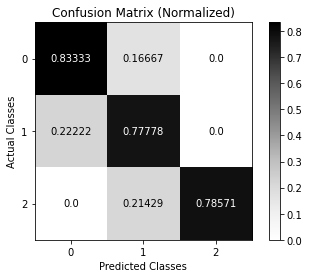

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.8092176386913228


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.79      0.83      0.81        18
Atypical Nevus       0.70      0.78      0.74        18
      Melanoma       1.00      0.79      0.88        14

      accuracy                           0.80        50
     macro avg       0.83      0.80      0.81        50
  weighted avg       0.82      0.80      0.80        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

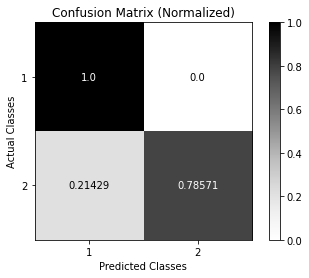

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.92


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.92      1.00      0.96        36
            Melanoma       1.00      0.79      0.88        14

            accuracy                           0.94        50
           macro avg       0.96      0.89      0.92        50
        weighted avg       0.94      0.94      0.94        50



## Inception + classes' balance + $\pi/2$ rotation.

In [ ]:
means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [ ]:
transformations = tt.Compose([
    tt.ToTensor(),
    tt.Resize((299, 299)),
    tt.Normalize(means, stds)
])

In [ ]:
train_images = array_to_tensor(transformations, train_images_array)
val_images = array_to_tensor(transformations, val_images_array)

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
#for now we have 26 items of class 2 and 62 for 1 & 0, so balance all of them
#to have 100 elements.
new_train_images, new_train_target = balance_classes(train_images, list(y_train), 100)

In [ ]:
augmentations = [iaa.geometric.Rotate(90)]
new_train_images, new_train_target = add_more_examples(new_train_images, list(new_train_target), augmentations)

In [ ]:
#new_train_images = make_it_harder(new_train_images, augs_for_complication)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images, new_train_target)), batch_size = 16, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = 16, shuffle=False)

In [ ]:
best_score = 0

In [ ]:
def objective(trial):
    global best_score
    inception = models.inception_v3(pretrained=True)

    for params in inception.parameters():
        params.requires_grad_(True)

    inception.AuxLogits.fc = nn.Sequential(
        nn.Linear(768, 3, bias=True),
        nn.Softmax())

    inception.fc = nn.Sequential(
        nn.Linear(2048, 3, bias=True),
        nn.Softmax())
    
    inception = inception.to(DEVICE)
    
    lr = trial.suggest_uniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-1)
    gamma = trial.suggest_uniform('gamma', 0.25, 0.75)

    optimizer = torch.optim.Adam(inception.parameters(), lr=lr,
                                            weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, 
                                            gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    history = train(inception, criterion, optimizer, 10, new_train_dataloader,
                val_dataloader, '/content/inception.pth', lr_scheduler, True)
    
    inception.load_state_dict(torch.load('/content/inception.pth'))
    
    loss, acc, val_loss, val_acc = zip(*history)

    if max(val_acc) > best_score:
        best_score = max(val_acc)
        torch.save(inception.state_dict(),
        '/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_expansion.pth')

    return max(val_acc)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-04-29 10:33:55,868] A new study created in memory with name: no-name-5667f96d-ddf4-4bf1-9e24-3d23e064e81f
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.1909180575622422


epoch:  10%|█         | 1/10 [00:18<02:47, 18.66s/it]


Epoch 001 train_loss: 1.1909     val_loss 1.0371 train_acc 0.6918 val_acc 0.5000
loss on train 1.2095435841913498


epoch:  20%|██        | 2/10 [00:37<02:28, 18.58s/it]


Epoch 002 train_loss: 1.2095     val_loss 0.9979 train_acc 0.6962 val_acc 0.5800
loss on train 1.241379654856849


epoch:  30%|███       | 3/10 [00:55<02:08, 18.37s/it]


Epoch 003 train_loss: 1.2414     val_loss 1.2200 train_acc 0.6630 val_acc 0.2400
loss on train 1.2790000539132602


epoch:  40%|████      | 4/10 [01:13<01:49, 18.24s/it]


Epoch 004 train_loss: 1.2790     val_loss 1.0358 train_acc 0.6164 val_acc 0.4400
loss on train 1.2484483687153412


epoch:  50%|█████     | 5/10 [01:31<01:30, 18.14s/it]


Epoch 005 train_loss: 1.2484     val_loss 1.0267 train_acc 0.6452 val_acc 0.4400
loss on train 1.2874076966435841


epoch:  60%|██████    | 6/10 [01:49<01:12, 18.08s/it]


Epoch 006 train_loss: 1.2874     val_loss 0.9413 train_acc 0.6098 val_acc 0.5600
loss on train 1.2163343022509319


epoch:  70%|███████   | 7/10 [02:07<00:54, 18.01s/it]


Epoch 007 train_loss: 1.2163     val_loss 0.9671 train_acc 0.6563 val_acc 0.5600
loss on train 1.1681756801457204


epoch:  80%|████████  | 8/10 [02:25<00:35, 17.99s/it]


Epoch 008 train_loss: 1.1682     val_loss 1.0145 train_acc 0.7095 val_acc 0.5200
loss on train 1.2276250290500617


epoch:  90%|█████████ | 9/10 [02:43<00:18, 18.05s/it]


Epoch 009 train_loss: 1.2276     val_loss 0.9229 train_acc 0.6519 val_acc 0.6200
loss on train 1.1790092276892483


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.12s/it]



Epoch 010 train_loss: 1.1790     val_loss 1.0666 train_acc 0.7162 val_acc 0.4600


[I 2022-04-29 10:36:59,566] Trial 0 finished with value: 0.62 and parameters: {'lr': 0.0006215427775291541, 'weight_decay': 0.04127577481079085, 'gamma': 0.4753573343455959}. Best is trial 0 with value: 0.62.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2098814330978562


epoch:  10%|█         | 1/10 [00:18<02:46, 18.52s/it]


Epoch 001 train_loss: 1.2099     val_loss 0.8329 train_acc 0.6940 val_acc 0.7200
loss on train 1.073519480466314


epoch:  20%|██        | 2/10 [00:36<02:25, 18.25s/it]


Epoch 002 train_loss: 1.0735     val_loss 0.9046 train_acc 0.7871 val_acc 0.6600
loss on train 0.9498084199402126


epoch:  30%|███       | 3/10 [00:54<02:07, 18.15s/it]


Epoch 003 train_loss: 0.9498     val_loss 0.9461 train_acc 0.8647 val_acc 0.6000
loss on train 0.9707766039144173


epoch:  40%|████      | 4/10 [01:12<01:48, 18.11s/it]


Epoch 004 train_loss: 0.9708     val_loss 0.8725 train_acc 0.8537 val_acc 0.6800
loss on train 1.003938920217713


epoch:  50%|█████     | 5/10 [01:31<01:30, 18.19s/it]


Epoch 005 train_loss: 1.0039     val_loss 0.8250 train_acc 0.8337 val_acc 0.7400
loss on train 0.9303439952053146


epoch:  60%|██████    | 6/10 [01:49<01:12, 18.13s/it]


Epoch 006 train_loss: 0.9303     val_loss 0.8169 train_acc 0.8869 val_acc 0.7200
loss on train 0.8485334400591459


epoch:  70%|███████   | 7/10 [02:07<00:54, 18.10s/it]


Epoch 007 train_loss: 0.8485     val_loss 0.8850 train_acc 0.9446 val_acc 0.6600
loss on train 0.8519042162038799


epoch:  80%|████████  | 8/10 [02:25<00:36, 18.09s/it]


Epoch 008 train_loss: 0.8519     val_loss 0.8337 train_acc 0.9379 val_acc 0.6800
loss on train 0.8341787896240894


epoch:  90%|█████████ | 9/10 [02:43<00:18, 18.08s/it]


Epoch 009 train_loss: 0.8342     val_loss 0.8065 train_acc 0.9623 val_acc 0.7400
loss on train 0.8410357059766342


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.12s/it]



Epoch 010 train_loss: 0.8410     val_loss 0.7893 train_acc 0.9579 val_acc 0.7400


[I 2022-04-29 10:40:02,083] Trial 1 finished with value: 0.74 and parameters: {'lr': 0.00035414497989995347, 'weight_decay': 0.0027986942749617066, 'gamma': 0.32133638071343035}. Best is trial 1 with value: 0.74.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2712964215987008


epoch:  10%|█         | 1/10 [00:18<02:46, 18.49s/it]


Epoch 001 train_loss: 1.2713     val_loss 0.8994 train_acc 0.6851 val_acc 0.6000
loss on train 0.9160725457176665


epoch:  20%|██        | 2/10 [00:36<02:27, 18.45s/it]


Epoch 002 train_loss: 0.9161     val_loss 0.8854 train_acc 0.9246 val_acc 0.6200
loss on train 0.8610918426725129


epoch:  30%|███       | 3/10 [00:54<02:07, 18.27s/it]


Epoch 003 train_loss: 0.8611     val_loss 0.8932 train_acc 0.9468 val_acc 0.6000
loss on train 0.8397591883221646


epoch:  40%|████      | 4/10 [01:13<01:49, 18.33s/it]


Epoch 004 train_loss: 0.8398     val_loss 0.8615 train_acc 0.9512 val_acc 0.7000
loss on train 0.825198372557528


epoch:  50%|█████     | 5/10 [01:31<01:31, 18.24s/it]


Epoch 005 train_loss: 0.8252     val_loss 0.9552 train_acc 0.9690 val_acc 0.5600
loss on train 0.8554045035939524


epoch:  60%|██████    | 6/10 [01:49<01:12, 18.17s/it]


Epoch 006 train_loss: 0.8554     val_loss 0.8748 train_acc 0.9446 val_acc 0.6800
loss on train 0.8035964032763124


epoch:  70%|███████   | 7/10 [02:07<00:54, 18.14s/it]


Epoch 007 train_loss: 0.8036     val_loss 0.8931 train_acc 0.9823 val_acc 0.6400
loss on train 0.7959267141549392


epoch:  80%|████████  | 8/10 [02:25<00:36, 18.12s/it]


Epoch 008 train_loss: 0.7959     val_loss 0.8289 train_acc 0.9845 val_acc 0.7000
loss on train 0.7869354367520487


epoch:  90%|█████████ | 9/10 [02:44<00:18, 18.21s/it]


Epoch 009 train_loss: 0.7869     val_loss 0.7811 train_acc 0.9933 val_acc 0.7600
loss on train 0.7992154605637104


epoch: 100%|██████████| 10/10 [03:02<00:00, 18.21s/it]



Epoch 010 train_loss: 0.7992     val_loss 0.8996 train_acc 0.9823 val_acc 0.6600


[I 2022-04-29 10:43:05,433] Trial 2 finished with value: 0.76 and parameters: {'lr': 0.0001244757943555313, 'weight_decay': 0.0001931400855483129, 'gamma': 0.625666097311059}. Best is trial 2 with value: 0.76.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2099119723503975


epoch:  10%|█         | 1/10 [00:18<02:45, 18.42s/it]


Epoch 001 train_loss: 1.2099     val_loss 0.9990 train_acc 0.7095 val_acc 0.5000
loss on train 1.069651867492236


epoch:  20%|██        | 2/10 [00:36<02:27, 18.41s/it]


Epoch 002 train_loss: 1.0697     val_loss 0.9311 train_acc 0.7805 val_acc 0.6000
loss on train 1.0423207639854921


epoch:  30%|███       | 3/10 [00:54<02:07, 18.23s/it]


Epoch 003 train_loss: 1.0423     val_loss 0.9606 train_acc 0.8160 val_acc 0.6000
loss on train 1.1315302798594709


epoch:  40%|████      | 4/10 [01:12<01:48, 18.15s/it]


Epoch 004 train_loss: 1.1315     val_loss 0.9317 train_acc 0.7517 val_acc 0.5800
loss on train 1.1041787006373944


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.08s/it]


Epoch 005 train_loss: 1.1042     val_loss 1.0054 train_acc 0.7539 val_acc 0.5600
loss on train 1.1307648748093329


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.04s/it]


Epoch 006 train_loss: 1.1308     val_loss 1.0365 train_acc 0.7583 val_acc 0.5000
loss on train 1.0937434416388196


epoch:  70%|███████   | 7/10 [02:07<00:54, 18.12s/it]


Epoch 007 train_loss: 1.0937     val_loss 0.8856 train_acc 0.7738 val_acc 0.6200
loss on train 1.0874205075716497


epoch:  80%|████████  | 8/10 [02:25<00:36, 18.06s/it]


Epoch 008 train_loss: 1.0874     val_loss 1.0006 train_acc 0.7761 val_acc 0.5600
loss on train 1.1181690069101338


epoch:  90%|█████████ | 9/10 [02:42<00:18, 18.02s/it]


Epoch 009 train_loss: 1.1182     val_loss 0.9623 train_acc 0.7494 val_acc 0.5600
loss on train 1.1501938469394084


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.12s/it]



Epoch 010 train_loss: 1.1502     val_loss 0.8950 train_acc 0.7295 val_acc 0.6400


[I 2022-04-29 10:46:07,560] Trial 3 finished with value: 0.64 and parameters: {'lr': 0.00041320197418578204, 'weight_decay': 0.04807952761868484, 'gamma': 0.6542197858449842}. Best is trial 2 with value: 0.76.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2741140417936372


epoch:  10%|█         | 1/10 [00:18<02:45, 18.39s/it]


Epoch 001 train_loss: 1.2741     val_loss 0.9103 train_acc 0.6364 val_acc 0.6000
loss on train 1.1715031003211924


epoch:  20%|██        | 2/10 [00:36<02:25, 18.18s/it]


Epoch 002 train_loss: 1.1715     val_loss 1.0079 train_acc 0.7361 val_acc 0.5600
loss on train 1.2230317201424068


epoch:  30%|███       | 3/10 [00:54<02:06, 18.09s/it]


Epoch 003 train_loss: 1.2230     val_loss 1.0671 train_acc 0.6807 val_acc 0.4200
loss on train 1.279145282546591


epoch:  40%|████      | 4/10 [01:12<01:48, 18.03s/it]


Epoch 004 train_loss: 1.2791     val_loss 1.0784 train_acc 0.6208 val_acc 0.4000
loss on train 1.306675986545842


epoch:  50%|█████     | 5/10 [01:30<01:29, 18.00s/it]


Epoch 005 train_loss: 1.3067     val_loss 1.0844 train_acc 0.5698 val_acc 0.3600
loss on train 1.2091411238499068


epoch:  60%|██████    | 6/10 [01:48<01:11, 17.95s/it]


Epoch 006 train_loss: 1.2091     val_loss 0.9746 train_acc 0.6984 val_acc 0.5600
loss on train 1.1859109835191206


epoch:  70%|███████   | 7/10 [02:06<00:53, 17.94s/it]


Epoch 007 train_loss: 1.1859     val_loss 1.0009 train_acc 0.6741 val_acc 0.5400
loss on train 1.1719596200930307


epoch:  80%|████████  | 8/10 [02:23<00:35, 17.92s/it]


Epoch 008 train_loss: 1.1720     val_loss 0.9424 train_acc 0.7118 val_acc 0.5600
loss on train 1.2171764418714062


epoch:  90%|█████████ | 9/10 [02:41<00:17, 17.90s/it]


Epoch 009 train_loss: 1.2172     val_loss 1.0564 train_acc 0.6674 val_acc 0.4200
loss on train 1.2003419423050468


epoch: 100%|██████████| 10/10 [02:59<00:00, 17.97s/it]



Epoch 010 train_loss: 1.2003     val_loss 0.9904 train_acc 0.6984 val_acc 0.5400


[I 2022-04-29 10:49:08,015] Trial 4 finished with value: 0.6 and parameters: {'lr': 0.0005955653371787792, 'weight_decay': 0.07733088477882562, 'gamma': 0.5229019819460533}. Best is trial 2 with value: 0.76.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2337507641236163


epoch:  10%|█         | 1/10 [00:18<02:44, 18.32s/it]


Epoch 001 train_loss: 1.2338     val_loss 0.9782 train_acc 0.6851 val_acc 0.5600
loss on train 1.341029516609175


epoch:  20%|██        | 2/10 [00:36<02:26, 18.31s/it]


Epoch 002 train_loss: 1.3410     val_loss 0.9918 train_acc 0.5920 val_acc 0.6200
loss on train 1.307423964836645


epoch:  30%|███       | 3/10 [00:54<02:07, 18.15s/it]


Epoch 003 train_loss: 1.3074     val_loss 1.0401 train_acc 0.5809 val_acc 0.4600
loss on train 1.317652871497719


epoch:  40%|████      | 4/10 [01:12<01:48, 18.06s/it]


Epoch 004 train_loss: 1.3177     val_loss 1.0287 train_acc 0.5920 val_acc 0.4600
loss on train 1.3084013002146109


epoch:  50%|█████     | 5/10 [01:30<01:29, 17.99s/it]


Epoch 005 train_loss: 1.3084     val_loss 1.0053 train_acc 0.5920 val_acc 0.5200
loss on train 1.247733950350607


epoch:  60%|██████    | 6/10 [01:48<01:11, 17.94s/it]


Epoch 006 train_loss: 1.2477     val_loss 0.9572 train_acc 0.6430 val_acc 0.5400
loss on train 1.2789401040637571


epoch:  70%|███████   | 7/10 [02:06<00:54, 18.01s/it]


Epoch 007 train_loss: 1.2789     val_loss 0.9208 train_acc 0.6164 val_acc 0.6400
loss on train 1.2168250892749117


epoch:  80%|████████  | 8/10 [02:24<00:35, 17.95s/it]


Epoch 008 train_loss: 1.2168     val_loss 1.1479 train_acc 0.6718 val_acc 0.3600
loss on train 1.2982837371445548


epoch:  90%|█████████ | 9/10 [02:42<00:17, 17.91s/it]


Epoch 009 train_loss: 1.2983     val_loss 0.9444 train_acc 0.6186 val_acc 0.6200
loss on train 1.2201641168932693


epoch: 100%|██████████| 10/10 [02:59<00:00, 17.98s/it]



Epoch 010 train_loss: 1.2202     val_loss 0.9623 train_acc 0.6763 val_acc 0.6000


[I 2022-04-29 10:52:08,587] Trial 5 finished with value: 0.64 and parameters: {'lr': 0.0008665241528427806, 'weight_decay': 0.03658150583554778, 'gamma': 0.533971491528837}. Best is trial 2 with value: 0.76.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2221576046785072


epoch:  10%|█         | 1/10 [00:18<02:45, 18.37s/it]


Epoch 001 train_loss: 1.2222     val_loss 0.9088 train_acc 0.6807 val_acc 0.6400
loss on train 1.1652219229421172


epoch:  20%|██        | 2/10 [00:36<02:25, 18.18s/it]


Epoch 002 train_loss: 1.1652     val_loss 0.9253 train_acc 0.7095 val_acc 0.5800
loss on train 1.217942968440426


epoch:  30%|███       | 3/10 [00:54<02:06, 18.10s/it]


Epoch 003 train_loss: 1.2179     val_loss 0.9700 train_acc 0.6630 val_acc 0.5800
loss on train 1.1927041505234204


epoch:  40%|████      | 4/10 [01:12<01:48, 18.06s/it]


Epoch 004 train_loss: 1.1927     val_loss 0.9130 train_acc 0.6829 val_acc 0.6000
loss on train 1.1732731198524424


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.03s/it]


Epoch 005 train_loss: 1.1733     val_loss 0.9839 train_acc 0.7118 val_acc 0.5000
loss on train 1.2022823576387969


epoch:  60%|██████    | 6/10 [01:48<01:11, 18.00s/it]


Epoch 006 train_loss: 1.2023     val_loss 0.9561 train_acc 0.6807 val_acc 0.5800
loss on train 1.1703449709716762


epoch:  70%|███████   | 7/10 [02:06<00:53, 17.96s/it]


Epoch 007 train_loss: 1.1703     val_loss 0.8968 train_acc 0.7228 val_acc 0.6400
loss on train 1.116359863471562


epoch:  80%|████████  | 8/10 [02:24<00:35, 17.95s/it]


Epoch 008 train_loss: 1.1164     val_loss 0.9595 train_acc 0.7605 val_acc 0.5800
loss on train 1.0906291277604199


epoch:  90%|█████████ | 9/10 [02:42<00:17, 17.95s/it]


Epoch 009 train_loss: 1.0906     val_loss 1.0894 train_acc 0.7716 val_acc 0.4000
loss on train 1.16013787220957


epoch: 100%|██████████| 10/10 [03:00<00:00, 18.00s/it]



Epoch 010 train_loss: 1.1601     val_loss 0.9316 train_acc 0.7251 val_acc 0.6200


[I 2022-04-29 10:55:09,382] Trial 6 finished with value: 0.64 and parameters: {'lr': 0.0004737817896819314, 'weight_decay': 0.03326009328227741, 'gamma': 0.5158729603335208}. Best is trial 2 with value: 0.76.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2307816281286945


epoch:  10%|█         | 1/10 [00:18<02:45, 18.34s/it]


Epoch 001 train_loss: 1.2308     val_loss 0.8642 train_acc 0.7029 val_acc 0.7200
loss on train 0.9223062393406278


epoch:  20%|██        | 2/10 [00:36<02:26, 18.36s/it]


Epoch 002 train_loss: 0.9223     val_loss 0.8367 train_acc 0.9091 val_acc 0.7400
loss on train 0.8637011590395164


epoch:  30%|███       | 3/10 [00:54<02:07, 18.21s/it]


Epoch 003 train_loss: 0.8637     val_loss 0.8100 train_acc 0.9490 val_acc 0.7400
loss on train 0.8543437928159591


epoch:  40%|████      | 4/10 [01:12<01:48, 18.15s/it]


Epoch 004 train_loss: 0.8543     val_loss 0.8105 train_acc 0.9424 val_acc 0.7400
loss on train 0.8383726296562313


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.10s/it]


Epoch 005 train_loss: 0.8384     val_loss 0.8627 train_acc 0.9601 val_acc 0.7000
loss on train 0.8048800816821418


epoch:  60%|██████    | 6/10 [01:49<01:12, 18.21s/it]


Epoch 006 train_loss: 0.8049     val_loss 0.7894 train_acc 0.9845 val_acc 0.7600
loss on train 0.7981552419535601


epoch:  70%|███████   | 7/10 [02:07<00:54, 18.15s/it]


Epoch 007 train_loss: 0.7982     val_loss 0.8467 train_acc 0.9845 val_acc 0.7000
loss on train 0.7948189627569161


epoch:  80%|████████  | 8/10 [02:25<00:36, 18.11s/it]


Epoch 008 train_loss: 0.7948     val_loss 0.8326 train_acc 0.9889 val_acc 0.7000
loss on train 0.7888345919268623


epoch:  90%|█████████ | 9/10 [02:43<00:18, 18.08s/it]


Epoch 009 train_loss: 0.7888     val_loss 0.8031 train_acc 0.9933 val_acc 0.7600
loss on train 0.7965626198542356


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.13s/it]



Epoch 010 train_loss: 0.7966     val_loss 0.7863 train_acc 0.9911 val_acc 0.7400


[I 2022-04-29 10:58:11,493] Trial 7 finished with value: 0.76 and parameters: {'lr': 0.00013759654190056866, 'weight_decay': 0.012025043227574639, 'gamma': 0.28097057454417806}. Best is trial 2 with value: 0.76.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2660296354484135


epoch:  10%|█         | 1/10 [00:18<02:44, 18.33s/it]


Epoch 001 train_loss: 1.2660     val_loss 0.8777 train_acc 0.6718 val_acc 0.7000
loss on train 0.922272623113941


epoch:  20%|██        | 2/10 [00:36<02:25, 18.16s/it]


Epoch 002 train_loss: 0.9223     val_loss 0.8613 train_acc 0.9135 val_acc 0.6800
loss on train 0.8471835420824207


epoch:  30%|███       | 3/10 [00:54<02:07, 18.27s/it]


Epoch 003 train_loss: 0.8472     val_loss 0.7923 train_acc 0.9579 val_acc 0.8200
loss on train 0.8348263878780036


epoch:  40%|████      | 4/10 [01:12<01:49, 18.17s/it]


Epoch 004 train_loss: 0.8348     val_loss 0.8298 train_acc 0.9690 val_acc 0.7200
loss on train 0.8403370734593292


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.12s/it]


Epoch 005 train_loss: 0.8403     val_loss 0.8514 train_acc 0.9490 val_acc 0.6600
loss on train 0.8147295340730452


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.09s/it]


Epoch 006 train_loss: 0.8147     val_loss 0.8232 train_acc 0.9778 val_acc 0.7200
loss on train 0.7954982910346562


epoch:  70%|███████   | 7/10 [02:06<00:54, 18.09s/it]


Epoch 007 train_loss: 0.7955     val_loss 0.8186 train_acc 0.9889 val_acc 0.7200
loss on train 0.7948201175803884


epoch:  80%|████████  | 8/10 [02:24<00:36, 18.07s/it]


Epoch 008 train_loss: 0.7948     val_loss 0.8559 train_acc 0.9933 val_acc 0.7000
loss on train 0.7962142205291207


epoch:  90%|█████████ | 9/10 [02:42<00:18, 18.05s/it]


Epoch 009 train_loss: 0.7962     val_loss 0.8407 train_acc 0.9867 val_acc 0.7000
loss on train 0.7885301292867724


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.10s/it]



Epoch 010 train_loss: 0.7885     val_loss 0.8533 train_acc 0.9911 val_acc 0.7000


[I 2022-04-29 11:01:13,816] Trial 8 finished with value: 0.82 and parameters: {'lr': 0.00011587199982075568, 'weight_decay': 0.00013840505013205728, 'gamma': 0.5652965614151251}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3721025632384611


epoch:  10%|█         | 1/10 [00:18<02:46, 18.48s/it]


Epoch 001 train_loss: 1.3721     val_loss 1.1746 train_acc 0.5499 val_acc 0.3800
loss on train 1.3997726747043382


epoch:  20%|██        | 2/10 [00:36<02:25, 18.18s/it]


Epoch 002 train_loss: 1.3998     val_loss 1.2489 train_acc 0.5011 val_acc 0.3000
loss on train 1.3246382599130702


epoch:  30%|███       | 3/10 [00:54<02:07, 18.21s/it]


Epoch 003 train_loss: 1.3246     val_loss 0.9352 train_acc 0.5366 val_acc 0.6000
loss on train 1.2419773969311936


epoch:  40%|████      | 4/10 [01:12<01:49, 18.22s/it]


Epoch 004 train_loss: 1.2420     val_loss 0.9052 train_acc 0.6497 val_acc 0.6600
loss on train 1.2658920388528354


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.11s/it]


Epoch 005 train_loss: 1.2659     val_loss 0.9702 train_acc 0.6364 val_acc 0.5800
loss on train 1.2830900014636257


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.01s/it]


Epoch 006 train_loss: 1.2831     val_loss 0.9108 train_acc 0.6208 val_acc 0.6000
loss on train 1.1629830326579362


epoch:  70%|███████   | 7/10 [02:06<00:53, 17.97s/it]


Epoch 007 train_loss: 1.1630     val_loss 0.9938 train_acc 0.7140 val_acc 0.5600
loss on train 1.1017917890242093


epoch:  80%|████████  | 8/10 [02:24<00:35, 17.92s/it]


Epoch 008 train_loss: 1.1018     val_loss 0.9104 train_acc 0.7627 val_acc 0.6200
loss on train 1.0962856162149468


epoch:  90%|█████████ | 9/10 [02:42<00:17, 17.89s/it]


Epoch 009 train_loss: 1.0963     val_loss 0.9757 train_acc 0.7650 val_acc 0.5800
loss on train 1.0734860004976954


epoch: 100%|██████████| 10/10 [03:00<00:00, 18.00s/it]



Epoch 010 train_loss: 1.0735     val_loss 0.9150 train_acc 0.7805 val_acc 0.5800


[I 2022-04-29 11:04:14,646] Trial 9 finished with value: 0.66 and parameters: {'lr': 0.0009728281651015012, 'weight_decay': 0.0003359859939070669, 'gamma': 0.2898413883751669}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.4810515401632982


epoch:  10%|█         | 1/10 [00:18<02:45, 18.35s/it]


Epoch 001 train_loss: 1.4811     val_loss 1.0504 train_acc 0.4545 val_acc 0.5800
loss on train 1.3134629966943068


epoch:  20%|██        | 2/10 [00:36<02:26, 18.34s/it]


Epoch 002 train_loss: 1.3135     val_loss 0.9976 train_acc 0.7627 val_acc 0.6400
loss on train 1.1635123282472732


epoch:  30%|███       | 3/10 [00:54<02:07, 18.21s/it]


Epoch 003 train_loss: 1.1635     val_loss 0.9511 train_acc 0.8692 val_acc 0.6400
loss on train 1.047111299772749


epoch:  40%|████      | 4/10 [01:12<01:48, 18.13s/it]


Epoch 004 train_loss: 1.0471     val_loss 0.9152 train_acc 0.9246 val_acc 0.6400
loss on train 0.9711244177659705


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.08s/it]


Epoch 005 train_loss: 0.9711     val_loss 0.9130 train_acc 0.9424 val_acc 0.6200
loss on train 0.913734416210995


epoch:  60%|██████    | 6/10 [01:49<01:12, 18.18s/it]


Epoch 006 train_loss: 0.9137     val_loss 0.8985 train_acc 0.9579 val_acc 0.6600
loss on train 0.8766216034371149


epoch:  70%|███████   | 7/10 [02:07<00:54, 18.14s/it]


Epoch 007 train_loss: 0.8766     val_loss 0.8970 train_acc 0.9823 val_acc 0.6600
loss on train 0.8517620912412318


epoch:  80%|████████  | 8/10 [02:25<00:36, 18.11s/it]


Epoch 008 train_loss: 0.8518     val_loss 0.8911 train_acc 0.9845 val_acc 0.6400
loss on train 0.8351501493390542


epoch:  90%|█████████ | 9/10 [02:43<00:18, 18.09s/it]


Epoch 009 train_loss: 0.8352     val_loss 0.8909 train_acc 0.9933 val_acc 0.6400
loss on train 0.8208144868821103


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.16s/it]



Epoch 010 train_loss: 0.8208     val_loss 0.9021 train_acc 0.9956 val_acc 0.6800


[I 2022-04-29 11:07:17,001] Trial 10 finished with value: 0.68 and parameters: {'lr': 1.8526617315989293e-05, 'weight_decay': 0.0008651909303300072, 'gamma': 0.7200818315355016}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2132048880445983


epoch:  10%|█         | 1/10 [00:18<02:44, 18.30s/it]


Epoch 001 train_loss: 1.2132     val_loss 0.8459 train_acc 0.6785 val_acc 0.6600
loss on train 0.9327067842504666


epoch:  20%|██        | 2/10 [00:36<02:27, 18.40s/it]


Epoch 002 train_loss: 0.9327     val_loss 0.8407 train_acc 0.8936 val_acc 0.7400
loss on train 0.9039957417617087


epoch:  30%|███       | 3/10 [00:54<02:07, 18.24s/it]


Epoch 003 train_loss: 0.9040     val_loss 0.8469 train_acc 0.9002 val_acc 0.6800
loss on train 0.8995671166548972


epoch:  40%|████      | 4/10 [01:12<01:48, 18.15s/it]


Epoch 004 train_loss: 0.8996     val_loss 0.9880 train_acc 0.9069 val_acc 0.5600
loss on train 0.8521673412386436


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.10s/it]


Epoch 005 train_loss: 0.8522     val_loss 0.8280 train_acc 0.9512 val_acc 0.7200
loss on train 0.8395865949453113


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.08s/it]


Epoch 006 train_loss: 0.8396     val_loss 0.9060 train_acc 0.9512 val_acc 0.6200
loss on train 0.8665490866764686


epoch:  70%|███████   | 7/10 [02:06<00:54, 18.06s/it]


Epoch 007 train_loss: 0.8665     val_loss 0.9013 train_acc 0.9290 val_acc 0.6600
loss on train 0.8147606958042491


epoch:  80%|████████  | 8/10 [02:24<00:36, 18.05s/it]


Epoch 008 train_loss: 0.8148     val_loss 0.9111 train_acc 0.9734 val_acc 0.6200
loss on train 0.8032334466731205


epoch:  90%|█████████ | 9/10 [02:42<00:18, 18.03s/it]


Epoch 009 train_loss: 0.8032     val_loss 0.9119 train_acc 0.9845 val_acc 0.6000
loss on train 0.7889535472028272


epoch: 100%|██████████| 10/10 [03:00<00:00, 18.10s/it]



Epoch 010 train_loss: 0.7890     val_loss 0.8402 train_acc 0.9933 val_acc 0.7000


[I 2022-04-29 11:10:18,704] Trial 11 finished with value: 0.74 and parameters: {'lr': 0.00021559517325151352, 'weight_decay': 0.0001037748112182723, 'gamma': 0.6289411272079637}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.1961864552846768


epoch:  10%|█         | 1/10 [00:18<02:44, 18.32s/it]


Epoch 001 train_loss: 1.1962     val_loss 0.8705 train_acc 0.7251 val_acc 0.7000
loss on train 0.944147453207663


epoch:  20%|██        | 2/10 [00:36<02:25, 18.15s/it]


Epoch 002 train_loss: 0.9441     val_loss 0.8529 train_acc 0.8758 val_acc 0.6600
loss on train 0.9002204308753003


epoch:  30%|███       | 3/10 [00:54<02:06, 18.08s/it]


Epoch 003 train_loss: 0.9002     val_loss 0.9434 train_acc 0.9091 val_acc 0.5800
loss on train 0.8922823892200072


epoch:  40%|████      | 4/10 [01:12<01:48, 18.07s/it]


Epoch 004 train_loss: 0.8923     val_loss 0.8775 train_acc 0.9113 val_acc 0.6400
loss on train 0.9227739992797243


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.06s/it]


Epoch 005 train_loss: 0.9228     val_loss 0.8393 train_acc 0.8869 val_acc 0.7000
loss on train 0.8974977193809137


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.19s/it]


Epoch 006 train_loss: 0.8975     val_loss 0.8550 train_acc 0.9069 val_acc 0.7200
loss on train 0.8140154677854144


epoch:  70%|███████   | 7/10 [02:07<00:54, 18.24s/it]


Epoch 007 train_loss: 0.8140     val_loss 0.8086 train_acc 0.9734 val_acc 0.7600
loss on train 0.7982054034252124


epoch:  80%|████████  | 8/10 [02:25<00:36, 18.18s/it]


Epoch 008 train_loss: 0.7982     val_loss 0.8217 train_acc 0.9845 val_acc 0.7000
loss on train 0.8239459157518696


epoch:  90%|█████████ | 9/10 [02:43<00:18, 18.29s/it]


Epoch 009 train_loss: 0.8239     val_loss 0.7642 train_acc 0.9645 val_acc 0.7800
loss on train 0.8023168066652809


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.18s/it]



Epoch 010 train_loss: 0.8023     val_loss 0.8397 train_acc 0.9800 val_acc 0.7200


[I 2022-04-29 11:13:21,300] Trial 12 finished with value: 0.78 and parameters: {'lr': 0.000246487244048228, 'weight_decay': 0.00019349519208082975, 'gamma': 0.6139313814797438}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2125996155643675


epoch:  10%|█         | 1/10 [00:18<02:45, 18.38s/it]


Epoch 001 train_loss: 1.2126     val_loss 0.8350 train_acc 0.6896 val_acc 0.7000
loss on train 0.909960360854798


epoch:  20%|██        | 2/10 [00:36<02:25, 18.18s/it]


Epoch 002 train_loss: 0.9100     val_loss 0.9035 train_acc 0.9069 val_acc 0.6400
loss on train 0.9175346608701144


epoch:  30%|███       | 3/10 [00:54<02:06, 18.13s/it]


Epoch 003 train_loss: 0.9175     val_loss 0.9168 train_acc 0.8914 val_acc 0.6400
loss on train 0.8894644129831352


epoch:  40%|████      | 4/10 [01:12<01:48, 18.10s/it]


Epoch 004 train_loss: 0.8895     val_loss 0.8766 train_acc 0.9135 val_acc 0.6600
loss on train 0.8300495918204145


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.07s/it]


Epoch 005 train_loss: 0.8300     val_loss 0.8609 train_acc 0.9601 val_acc 0.6800
loss on train 0.8125146598350711


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.06s/it]


Epoch 006 train_loss: 0.8125     val_loss 0.8352 train_acc 0.9734 val_acc 0.7000
loss on train 0.8130446447765748


epoch:  70%|███████   | 7/10 [02:07<00:54, 18.18s/it]


Epoch 007 train_loss: 0.8130     val_loss 0.7984 train_acc 0.9778 val_acc 0.7600
loss on train 0.8095794305568789


epoch:  80%|████████  | 8/10 [02:25<00:36, 18.14s/it]


Epoch 008 train_loss: 0.8096     val_loss 0.8279 train_acc 0.9756 val_acc 0.7400
loss on train 0.8070162796392674


epoch:  90%|█████████ | 9/10 [02:43<00:18, 18.11s/it]


Epoch 009 train_loss: 0.8070     val_loss 0.8038 train_acc 0.9778 val_acc 0.7600
loss on train 0.8106224655840719


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.12s/it]



Epoch 010 train_loss: 0.8106     val_loss 0.8099 train_acc 0.9756 val_acc 0.7400


[I 2022-04-29 11:16:23,351] Trial 13 finished with value: 0.76 and parameters: {'lr': 0.0002455214764807693, 'weight_decay': 0.000743870305941391, 'gamma': 0.4180631910104086}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.201567968085177


epoch:  10%|█         | 1/10 [00:18<02:46, 18.45s/it]


Epoch 001 train_loss: 1.2016     val_loss 0.8509 train_acc 0.7162 val_acc 0.6800
loss on train 1.0248993793770902


epoch:  20%|██        | 2/10 [00:36<02:27, 18.43s/it]


Epoch 002 train_loss: 1.0249     val_loss 0.8469 train_acc 0.8293 val_acc 0.7000
loss on train 0.9829892528030666


epoch:  30%|███       | 3/10 [00:55<02:09, 18.45s/it]


Epoch 003 train_loss: 0.9830     val_loss 0.7935 train_acc 0.8492 val_acc 0.7600
loss on train 0.9638554970599595


epoch:  40%|████      | 4/10 [01:13<01:49, 18.31s/it]


Epoch 004 train_loss: 0.9639     val_loss 0.9511 train_acc 0.8448 val_acc 0.6000
loss on train 0.9661324650643934


epoch:  50%|█████     | 5/10 [01:31<01:31, 18.22s/it]


Epoch 005 train_loss: 0.9661     val_loss 0.8654 train_acc 0.8581 val_acc 0.6800
loss on train 0.9034431896558622


epoch:  60%|██████    | 6/10 [01:49<01:12, 18.15s/it]


Epoch 006 train_loss: 0.9034     val_loss 0.8222 train_acc 0.9024 val_acc 0.7200
loss on train 0.8904780707179575


epoch:  70%|███████   | 7/10 [02:07<00:54, 18.11s/it]


Epoch 007 train_loss: 0.8905     val_loss 0.8046 train_acc 0.9091 val_acc 0.7400
loss on train 0.8493889810769363


epoch:  80%|████████  | 8/10 [02:25<00:36, 18.09s/it]


Epoch 008 train_loss: 0.8494     val_loss 0.8493 train_acc 0.9490 val_acc 0.7000
loss on train 0.8320584823181254


epoch:  90%|█████████ | 9/10 [02:43<00:18, 18.07s/it]


Epoch 009 train_loss: 0.8321     val_loss 0.8115 train_acc 0.9490 val_acc 0.7400
loss on train 0.8175391870697427


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.20s/it]



Epoch 010 train_loss: 0.8175     val_loss 0.7517 train_acc 0.9645 val_acc 0.8000


[I 2022-04-29 11:19:26,132] Trial 14 finished with value: 0.8 and parameters: {'lr': 0.0003071280785005464, 'weight_decay': 0.0016764353183257353, 'gamma': 0.5819174406802713}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.4437515976159376


epoch:  10%|█         | 1/10 [00:18<02:45, 18.36s/it]


Epoch 001 train_loss: 1.4438     val_loss 1.0014 train_acc 0.5255 val_acc 0.6400
loss on train 1.1310878902211157


epoch:  20%|██        | 2/10 [00:36<02:25, 18.17s/it]


Epoch 002 train_loss: 1.1311     val_loss 0.9113 train_acc 0.8426 val_acc 0.5800
loss on train 0.9334763888509204


epoch:  30%|███       | 3/10 [00:54<02:06, 18.12s/it]


Epoch 003 train_loss: 0.9335     val_loss 0.9031 train_acc 0.9246 val_acc 0.6400
loss on train 0.8387506071585509


epoch:  40%|████      | 4/10 [01:12<01:48, 18.08s/it]


Epoch 004 train_loss: 0.8388     val_loss 0.9277 train_acc 0.9911 val_acc 0.6000
loss on train 0.821718812781797


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.07s/it]


Epoch 005 train_loss: 0.8217     val_loss 0.9326 train_acc 0.9778 val_acc 0.5800
loss on train 0.7926230866734575


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.07s/it]


Epoch 006 train_loss: 0.7926     val_loss 0.8893 train_acc 0.9956 val_acc 0.6400
loss on train 0.8030877542865779


epoch:  70%|███████   | 7/10 [02:07<00:54, 18.19s/it]


Epoch 007 train_loss: 0.8031     val_loss 0.8553 train_acc 0.9911 val_acc 0.7200
loss on train 0.7959840176110786


epoch:  80%|████████  | 8/10 [02:25<00:36, 18.16s/it]


Epoch 008 train_loss: 0.7960     val_loss 0.8537 train_acc 0.9956 val_acc 0.7200
loss on train 0.7987030995658655


epoch:  90%|█████████ | 9/10 [02:43<00:18, 18.15s/it]


Epoch 009 train_loss: 0.7987     val_loss 0.8637 train_acc 0.9911 val_acc 0.7000
loss on train 0.790127901174541


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.13s/it]



Epoch 010 train_loss: 0.7901     val_loss 0.8711 train_acc 0.9956 val_acc 0.6600


[I 2022-04-29 11:22:28,205] Trial 15 finished with value: 0.72 and parameters: {'lr': 4.369334623206356e-05, 'weight_decay': 0.00384362393137535, 'gamma': 0.4198564426913075}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.169449412637698


epoch:  10%|█         | 1/10 [00:18<02:45, 18.38s/it]


Epoch 001 train_loss: 1.1694     val_loss 0.9721 train_acc 0.7140 val_acc 0.5600
loss on train 1.0261127668579508


epoch:  20%|██        | 2/10 [00:36<02:27, 18.38s/it]


Epoch 002 train_loss: 1.0261     val_loss 0.8346 train_acc 0.8160 val_acc 0.7000
loss on train 0.9790526723650237


epoch:  30%|███       | 3/10 [00:54<02:07, 18.24s/it]


Epoch 003 train_loss: 0.9791     val_loss 0.8551 train_acc 0.8492 val_acc 0.7000
loss on train 0.9897467016909445


epoch:  40%|████      | 4/10 [01:12<01:48, 18.15s/it]


Epoch 004 train_loss: 0.9897     val_loss 0.9347 train_acc 0.8359 val_acc 0.5800
loss on train 1.0305081217357694


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.11s/it]


Epoch 005 train_loss: 1.0305     val_loss 0.9820 train_acc 0.8027 val_acc 0.5200
loss on train 0.9339806354230893


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.07s/it]


Epoch 006 train_loss: 0.9340     val_loss 0.9468 train_acc 0.8914 val_acc 0.6000
loss on train 0.8546779005067576


epoch:  70%|███████   | 7/10 [02:06<00:54, 18.07s/it]


Epoch 007 train_loss: 0.8547     val_loss 0.9014 train_acc 0.9446 val_acc 0.6200
loss on train 0.8650928262596385


epoch:  80%|████████  | 8/10 [02:25<00:36, 18.19s/it]


Epoch 008 train_loss: 0.8651     val_loss 0.8355 train_acc 0.9335 val_acc 0.7200
loss on train 0.8216723460051543


epoch:  90%|█████████ | 9/10 [02:43<00:18, 18.27s/it]


Epoch 009 train_loss: 0.8217     val_loss 0.8197 train_acc 0.9690 val_acc 0.7400
loss on train 0.8752560982947339


epoch: 100%|██████████| 10/10 [03:01<00:00, 18.19s/it]



Epoch 010 train_loss: 0.8753     val_loss 0.8312 train_acc 0.9224 val_acc 0.7200


[I 2022-04-29 11:25:30,914] Trial 16 finished with value: 0.74 and parameters: {'lr': 0.00037227475194086224, 'weight_decay': 0.0027315414798931895, 'gamma': 0.7440308205242596}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2583763847858573


epoch:  10%|█         | 1/10 [00:18<02:45, 18.41s/it]


Epoch 001 train_loss: 1.2584     val_loss 1.0097 train_acc 0.6585 val_acc 0.5000
loss on train 1.1865623121515345


epoch:  20%|██        | 2/10 [00:36<02:27, 18.38s/it]


Epoch 002 train_loss: 1.1866     val_loss 0.9028 train_acc 0.6896 val_acc 0.6400
loss on train 1.1221087319887926


epoch:  30%|███       | 3/10 [00:55<02:08, 18.35s/it]


Epoch 003 train_loss: 1.1221     val_loss 0.9312 train_acc 0.7406 val_acc 0.6600
loss on train 1.2024111065790553


epoch:  40%|████      | 4/10 [01:13<01:49, 18.19s/it]


Epoch 004 train_loss: 1.2024     val_loss 0.9416 train_acc 0.6984 val_acc 0.6400
loss on train 1.1399870643065932


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.10s/it]


Epoch 005 train_loss: 1.1400     val_loss 0.9035 train_acc 0.7339 val_acc 0.6600
loss on train 1.055231972174211


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.06s/it]


Epoch 006 train_loss: 1.0552     val_loss 0.8890 train_acc 0.7805 val_acc 0.6600
loss on train 1.058644713821538


epoch:  70%|███████   | 7/10 [02:06<00:54, 18.03s/it]


Epoch 007 train_loss: 1.0586     val_loss 0.8948 train_acc 0.7827 val_acc 0.6000
loss on train 1.0026004914433888


epoch:  80%|████████  | 8/10 [02:24<00:36, 18.01s/it]


Epoch 008 train_loss: 1.0026     val_loss 0.9058 train_acc 0.8315 val_acc 0.6600
loss on train 1.0035508477238488


epoch:  90%|█████████ | 9/10 [02:42<00:17, 17.99s/it]


Epoch 009 train_loss: 1.0036     val_loss 0.8895 train_acc 0.8514 val_acc 0.6600
loss on train 0.9627948912178598


epoch: 100%|██████████| 10/10 [03:00<00:00, 18.08s/it]



Epoch 010 train_loss: 0.9628     val_loss 0.9082 train_acc 0.8670 val_acc 0.6400


[I 2022-04-29 11:28:32,473] Trial 17 finished with value: 0.66 and parameters: {'lr': 0.000675946504761754, 'weight_decay': 0.001103622515126821, 'gamma': 0.5717922375927473}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.193027126419042


epoch:  10%|█         | 1/10 [00:18<02:45, 18.36s/it]


Epoch 001 train_loss: 1.1930     val_loss 0.8614 train_acc 0.6984 val_acc 0.7200
loss on train 0.9694906741446772


epoch:  20%|██        | 2/10 [00:36<02:25, 18.19s/it]


Epoch 002 train_loss: 0.9695     val_loss 0.9709 train_acc 0.8603 val_acc 0.5800
loss on train 0.9524816237637843


epoch:  30%|███       | 3/10 [00:54<02:06, 18.11s/it]


Epoch 003 train_loss: 0.9525     val_loss 0.8298 train_acc 0.8780 val_acc 0.7200
loss on train 0.9867339845242892


epoch:  40%|████      | 4/10 [01:12<01:48, 18.10s/it]


Epoch 004 train_loss: 0.9867     val_loss 0.8914 train_acc 0.8404 val_acc 0.6800
loss on train 0.9101333668385271


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.09s/it]


Epoch 005 train_loss: 0.9101     val_loss 0.8698 train_acc 0.8980 val_acc 0.6800
loss on train 0.8932219579848905


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.07s/it]


Epoch 006 train_loss: 0.8932     val_loss 0.8459 train_acc 0.9180 val_acc 0.6800
loss on train 0.8595113037959435


epoch:  70%|███████   | 7/10 [02:06<00:54, 18.05s/it]


Epoch 007 train_loss: 0.8595     val_loss 0.8606 train_acc 0.9379 val_acc 0.6600
loss on train 0.8128726302652296


epoch:  80%|████████  | 8/10 [02:24<00:36, 18.04s/it]


Epoch 008 train_loss: 0.8129     val_loss 0.8262 train_acc 0.9800 val_acc 0.7000
loss on train 0.8814903592851897


epoch:  90%|█████████ | 9/10 [02:42<00:18, 18.04s/it]


Epoch 009 train_loss: 0.8815     val_loss 0.9060 train_acc 0.9224 val_acc 0.6200
loss on train 0.8473390650061969


epoch: 100%|██████████| 10/10 [03:00<00:00, 18.07s/it]



Epoch 010 train_loss: 0.8473     val_loss 0.8741 train_acc 0.9490 val_acc 0.6600


[I 2022-04-29 11:31:33,971] Trial 18 finished with value: 0.72 and parameters: {'lr': 0.00030708497120224135, 'weight_decay': 0.008158855501159846, 'gamma': 0.45728635674429735}. Best is trial 8 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2074937075046108


epoch:  10%|█         | 1/10 [00:18<02:45, 18.40s/it]


Epoch 001 train_loss: 1.2075     val_loss 0.8313 train_acc 0.6851 val_acc 0.7600
loss on train 0.9422349966814672


epoch:  20%|██        | 2/10 [00:36<02:25, 18.22s/it]


Epoch 002 train_loss: 0.9422     val_loss 0.8561 train_acc 0.8803 val_acc 0.6800
loss on train 0.8787486711785428


epoch:  30%|███       | 3/10 [00:54<02:07, 18.16s/it]


Epoch 003 train_loss: 0.8787     val_loss 0.8731 train_acc 0.9357 val_acc 0.6600
loss on train 0.841921470646319


epoch:  40%|████      | 4/10 [01:12<01:48, 18.10s/it]


Epoch 004 train_loss: 0.8419     val_loss 0.8624 train_acc 0.9557 val_acc 0.6400
loss on train 0.8335590049327081


epoch:  50%|█████     | 5/10 [01:30<01:30, 18.08s/it]


Epoch 005 train_loss: 0.8336     val_loss 0.8611 train_acc 0.9534 val_acc 0.6800
loss on train 0.8266320355451292


epoch:  60%|██████    | 6/10 [01:48<01:12, 18.06s/it]


Epoch 006 train_loss: 0.8266     val_loss 0.8231 train_acc 0.9645 val_acc 0.7200
loss on train 0.8194678083491695


epoch:  70%|███████   | 7/10 [02:06<00:54, 18.05s/it]


Epoch 007 train_loss: 0.8195     val_loss 0.8376 train_acc 0.9667 val_acc 0.7400
loss on train 0.8220603933884141


epoch:  80%|████████  | 8/10 [02:24<00:36, 18.05s/it]


Epoch 008 train_loss: 0.8221     val_loss 0.8081 train_acc 0.9667 val_acc 0.7200
loss on train 0.8211248680916171


epoch:  90%|█████████ | 9/10 [02:42<00:18, 18.05s/it]


Epoch 009 train_loss: 0.8211     val_loss 0.8601 train_acc 0.9645 val_acc 0.6800
loss on train 0.8023131134240432


epoch: 100%|██████████| 10/10 [03:00<00:00, 18.09s/it]



Epoch 010 train_loss: 0.8023     val_loss 0.7945 train_acc 0.9800 val_acc 0.7400


[I 2022-04-29 11:34:35,582] Trial 19 finished with value: 0.76 and parameters: {'lr': 0.00016828771809620943, 'weight_decay': 0.00044070467646073756, 'gamma': 0.672115998984351}. Best is trial 8 with value: 0.82.


In [ ]:
inception_class_exp = models.inception_v3(pretrained=True)

In [ ]:
inception_class_exp.AuxLogits.fc = nn.Sequential(
    nn.Linear(768, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_class_exp.fc = nn.Sequential(
    nn.Linear(2048, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_class_exp.load_state_dict(torch.load('/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_expansion.pth'))

<All keys matched successfully>

In [ ]:
inception_class_exp = inception_class_exp.to(DEVICE)

In [ ]:
print(show_accuracy(inception_class_exp, val_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'Typical Nevus': 0.6666666666666666, 'Atyical Nevus': 0.8888888888888888, 'Melanoma': 0.9285714285714286}


In [ ]:
labels, predicts = get_predictions(inception_class_exp, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


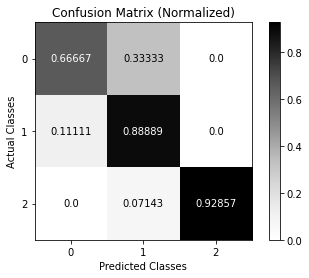

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.831150255947004


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.86      0.67      0.75        18
Atypical Nevus       0.70      0.89      0.78        18
      Melanoma       1.00      0.93      0.96        14

      accuracy                           0.82        50
     macro avg       0.85      0.83      0.83        50
  weighted avg       0.84      0.82      0.82        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

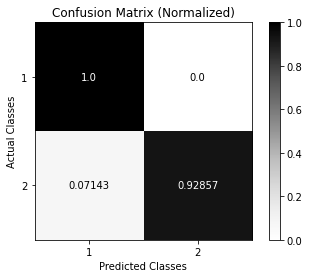

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.9746321664129884


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.97      1.00      0.99        36
            Melanoma       1.00      0.93      0.96        14

            accuracy                           0.98        50
           macro avg       0.99      0.96      0.97        50
        weighted avg       0.98      0.98      0.98        50



## Inception + classes' balance + $\pi/2$ rotation + gaussian blur. 

In [ ]:
means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [ ]:
transformations = tt.Compose([
    tt.ToTensor(),
    tt.Resize((299, 299)),
    tt.Normalize(means, stds)
])

In [ ]:
train_images = array_to_tensor(transformations, train_images_array)
val_images = array_to_tensor(transformations, val_images_array)

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
#for now we have 26 items of class 2 and 62 for 1 & 0, so balance all of them
#to have 100 elements.
new_train_images, new_train_target = balance_classes(train_images, list(y_train), 100)

In [ ]:
augmentations = [iaa.geometric.Rotate(90)]
new_train_images, new_train_target = add_more_examples(new_train_images, list(new_train_target), augmentations)

In [ ]:
new_train_images = make_it_harder(new_train_images, augs_for_complication)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images, new_train_target)), batch_size = 16, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = 16, shuffle=False)

In [ ]:
best_score = 0

In [ ]:
def objective(trial):
    global best_score
    inception = models.inception_v3(pretrained=True)

    for params in inception.parameters():
        params.requires_grad_(True)

    inception.AuxLogits.fc = nn.Sequential(
        nn.Linear(768, 3, bias=True),
        nn.Softmax())

    inception.fc = nn.Sequential(
        nn.Linear(2048, 3, bias=True),
        nn.Softmax())
    
    inception = inception.to(DEVICE)
    
    lr = trial.suggest_uniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-1)
    gamma = trial.suggest_uniform('gamma', 0.25, 0.75)

    optimizer = torch.optim.Adam(inception.parameters(), lr=lr,
                                            weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, 
                                            gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    history = train(inception, criterion, optimizer, 10, new_train_dataloader,
                val_dataloader, '/content/inception.pth', lr_scheduler, True)
    
    inception.load_state_dict(torch.load('/content/inception.pth'))
    
    loss, acc, val_loss, val_acc = zip(*history)

    if max(val_acc) > best_score:
        best_score = max(val_acc)
        torch.save(inception.state_dict(),
        '/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_expansion_2.pth')

    return max(val_acc)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-04-29 11:55:15,913] A new study created in memory with name: no-name-4a51eeeb-ff18-4cd9-86f4-29d44b2d16ba
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3826891556220562


epoch:  10%|█         | 1/10 [00:19<02:52, 19.14s/it]


Epoch 001 train_loss: 1.3827     val_loss 0.9137 train_acc 0.5792 val_acc 0.7000
loss on train 1.0612167882815877


epoch:  20%|██        | 2/10 [00:37<02:31, 18.88s/it]


Epoch 002 train_loss: 1.0612     val_loss 0.8940 train_acc 0.8395 val_acc 0.6800
loss on train 0.9373436509399249


epoch:  30%|███       | 3/10 [00:56<02:11, 18.80s/it]


Epoch 003 train_loss: 0.9373     val_loss 0.8770 train_acc 0.9132 val_acc 0.7000
loss on train 0.8660721308238595


epoch:  40%|████      | 4/10 [01:15<01:53, 18.97s/it]


Epoch 004 train_loss: 0.8661     val_loss 0.8230 train_acc 0.9566 val_acc 0.7400
loss on train 0.9055061904054919


epoch:  50%|█████     | 5/10 [01:34<01:34, 18.94s/it]


Epoch 005 train_loss: 0.9055     val_loss 0.8712 train_acc 0.9089 val_acc 0.7200
loss on train 0.870313773186243


epoch:  60%|██████    | 6/10 [01:53<01:15, 18.85s/it]


Epoch 006 train_loss: 0.8703     val_loss 0.8464 train_acc 0.9414 val_acc 0.7000
loss on train 0.8424562246835672


epoch:  70%|███████   | 7/10 [02:12<00:56, 18.79s/it]


Epoch 007 train_loss: 0.8425     val_loss 0.8704 train_acc 0.9696 val_acc 0.6800
loss on train 0.8408256220972719


epoch:  80%|████████  | 8/10 [02:30<00:37, 18.75s/it]


Epoch 008 train_loss: 0.8408     val_loss 0.9022 train_acc 0.9501 val_acc 0.6200
loss on train 0.8603159078031196


epoch:  90%|█████████ | 9/10 [02:49<00:18, 18.73s/it]


Epoch 009 train_loss: 0.8603     val_loss 0.8597 train_acc 0.9523 val_acc 0.7200
loss on train 0.870332489820468


epoch: 100%|██████████| 10/10 [03:08<00:00, 18.83s/it]



Epoch 010 train_loss: 0.8703     val_loss 0.8331 train_acc 0.9436 val_acc 0.7200


[I 2022-04-29 11:58:25,544] Trial 0 finished with value: 0.74 and parameters: {'lr': 0.0001397023393273738, 'weight_decay': 0.07325897994195285, 'gamma': 0.6033188532552903}. Best is trial 0 with value: 0.74.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.4226975606475631


epoch:  10%|█         | 1/10 [00:19<02:52, 19.18s/it]


Epoch 001 train_loss: 1.4227     val_loss 1.2369 train_acc 0.4946 val_acc 0.2800
loss on train 1.4345023187277375


epoch:  20%|██        | 2/10 [00:38<02:31, 19.00s/it]


Epoch 002 train_loss: 1.4345     val_loss 1.0337 train_acc 0.4794 val_acc 0.5200
loss on train 1.4009132395597446


epoch:  30%|███       | 3/10 [00:56<02:11, 18.77s/it]


Epoch 003 train_loss: 1.4009     val_loss 1.1096 train_acc 0.5119 val_acc 0.3000
loss on train 1.3082133244537222


epoch:  40%|████      | 4/10 [01:14<01:51, 18.64s/it]


Epoch 004 train_loss: 1.3082     val_loss 1.0790 train_acc 0.6052 val_acc 0.3600
loss on train 1.2980396044228444


epoch:  50%|█████     | 5/10 [01:33<01:32, 18.55s/it]


Epoch 005 train_loss: 1.2980     val_loss 1.1480 train_acc 0.6334 val_acc 0.3200
loss on train 1.398042703140325


epoch:  60%|██████    | 6/10 [01:51<01:13, 18.50s/it]


Epoch 006 train_loss: 1.3980     val_loss 1.0873 train_acc 0.5293 val_acc 0.4600
loss on train 1.309835201488917


epoch:  70%|███████   | 7/10 [02:10<00:55, 18.44s/it]


Epoch 007 train_loss: 1.3098     val_loss 1.0353 train_acc 0.5640 val_acc 0.4800
loss on train 1.2826550045654728


epoch:  80%|████████  | 8/10 [02:28<00:37, 18.52s/it]


Epoch 008 train_loss: 1.2827     val_loss 0.9102 train_acc 0.5770 val_acc 0.6400
loss on train 1.241853078120184


epoch:  90%|█████████ | 9/10 [02:47<00:18, 18.44s/it]


Epoch 009 train_loss: 1.2419     val_loss 0.9800 train_acc 0.6421 val_acc 0.5000
loss on train 1.2306349815360378


epoch: 100%|██████████| 10/10 [03:05<00:00, 18.53s/it]



Epoch 010 train_loss: 1.2306     val_loss 0.9873 train_acc 0.6638 val_acc 0.5400


[I 2022-04-29 12:01:31,715] Trial 1 finished with value: 0.64 and parameters: {'lr': 0.0009920833522870673, 'weight_decay': 0.020112883288564632, 'gamma': 0.7118716351717391}. Best is trial 0 with value: 0.74.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2686990352101026


epoch:  10%|█         | 1/10 [00:18<02:50, 18.93s/it]


Epoch 001 train_loss: 1.2687     val_loss 0.8987 train_acc 0.6052 val_acc 0.6800
loss on train 1.080307706059189


epoch:  20%|██        | 2/10 [00:37<02:29, 18.72s/it]


Epoch 002 train_loss: 1.0803     val_loss 0.9736 train_acc 0.7852 val_acc 0.5800
loss on train 1.1483500645114129


epoch:  30%|███       | 3/10 [00:56<02:10, 18.65s/it]


Epoch 003 train_loss: 1.1484     val_loss 0.9032 train_acc 0.7310 val_acc 0.6200
loss on train 1.088368887497908


epoch:  40%|████      | 4/10 [01:14<01:52, 18.75s/it]


Epoch 004 train_loss: 1.0884     val_loss 0.8762 train_acc 0.7787 val_acc 0.7400
loss on train 1.1777424145158615


epoch:  50%|█████     | 5/10 [01:33<01:33, 18.67s/it]


Epoch 005 train_loss: 1.1777     val_loss 0.9387 train_acc 0.7137 val_acc 0.6000
loss on train 1.1227740054533952


epoch:  60%|██████    | 6/10 [01:52<01:14, 18.61s/it]


Epoch 006 train_loss: 1.1228     val_loss 0.8958 train_acc 0.7397 val_acc 0.6600
loss on train 1.0530104836259127


epoch:  70%|███████   | 7/10 [02:10<00:55, 18.56s/it]


Epoch 007 train_loss: 1.0530     val_loss 0.8941 train_acc 0.7939 val_acc 0.6600
loss on train 0.9894522058731046


epoch:  80%|████████  | 8/10 [02:28<00:37, 18.54s/it]


Epoch 008 train_loss: 0.9895     val_loss 0.8759 train_acc 0.8438 val_acc 0.6200
loss on train 1.012624072925129


epoch:  90%|█████████ | 9/10 [02:47<00:18, 18.51s/it]


Epoch 009 train_loss: 1.0126     val_loss 0.8816 train_acc 0.8308 val_acc 0.6800
loss on train 1.0266395321119892


epoch: 100%|██████████| 10/10 [03:05<00:00, 18.58s/it]



Epoch 010 train_loss: 1.0266     val_loss 0.9193 train_acc 0.8200 val_acc 0.6200


[I 2022-04-29 12:04:38,293] Trial 2 finished with value: 0.74 and parameters: {'lr': 0.00040966502432442916, 'weight_decay': 0.0275901076719012, 'gamma': 0.6280189597493654}. Best is trial 0 with value: 0.74.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2241019085534484


epoch:  10%|█         | 1/10 [00:18<02:50, 18.90s/it]


Epoch 001 train_loss: 1.2241     val_loss 0.8107 train_acc 0.6725 val_acc 0.7400
loss on train 1.0993764845254363


epoch:  20%|██        | 2/10 [00:37<02:29, 18.68s/it]


Epoch 002 train_loss: 1.0994     val_loss 0.9554 train_acc 0.7657 val_acc 0.5400
loss on train 1.0557260800338877


epoch:  30%|███       | 3/10 [00:56<02:10, 18.63s/it]


Epoch 003 train_loss: 1.0557     val_loss 0.9979 train_acc 0.7983 val_acc 0.5200
loss on train 1.1443638219750625


epoch:  40%|████      | 4/10 [01:14<01:51, 18.58s/it]


Epoch 004 train_loss: 1.1444     val_loss 0.9638 train_acc 0.7332 val_acc 0.5600
loss on train 1.117179015194775


epoch:  50%|█████     | 5/10 [01:32<01:32, 18.54s/it]


Epoch 005 train_loss: 1.1172     val_loss 0.9874 train_acc 0.7679 val_acc 0.5600
loss on train 1.0416465612399086


epoch:  60%|██████    | 6/10 [01:51<01:14, 18.52s/it]


Epoch 006 train_loss: 1.0416     val_loss 0.9621 train_acc 0.7939 val_acc 0.6000
loss on train 1.0099893632524701


epoch:  70%|███████   | 7/10 [02:09<00:55, 18.50s/it]


Epoch 007 train_loss: 1.0100     val_loss 0.9648 train_acc 0.8178 val_acc 0.5600
loss on train 0.9614156637171085


epoch:  80%|████████  | 8/10 [02:28<00:36, 18.49s/it]


Epoch 008 train_loss: 0.9614     val_loss 0.9242 train_acc 0.8655 val_acc 0.6600
loss on train 0.9489103628084096


epoch:  90%|█████████ | 9/10 [02:46<00:18, 18.48s/it]


Epoch 009 train_loss: 0.9489     val_loss 0.9270 train_acc 0.8764 val_acc 0.6000
loss on train 0.9572674250654439


epoch: 100%|██████████| 10/10 [03:05<00:00, 18.54s/it]



Epoch 010 train_loss: 0.9573     val_loss 0.9017 train_acc 0.8655 val_acc 0.6000


[I 2022-04-29 12:07:44,394] Trial 3 finished with value: 0.74 and parameters: {'lr': 0.00038447806580861843, 'weight_decay': 0.040343683531324614, 'gamma': 0.44613771988853096}. Best is trial 0 with value: 0.74.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.319511923769291


epoch:  10%|█         | 1/10 [00:18<02:49, 18.85s/it]


Epoch 001 train_loss: 1.3195     val_loss 0.9526 train_acc 0.5944 val_acc 0.5400
loss on train 1.2598374611384957


epoch:  20%|██        | 2/10 [00:37<02:30, 18.84s/it]


Epoch 002 train_loss: 1.2598     val_loss 0.9206 train_acc 0.6421 val_acc 0.6600
loss on train 1.249128784119695


epoch:  30%|███       | 3/10 [00:56<02:10, 18.69s/it]


Epoch 003 train_loss: 1.2491     val_loss 0.9853 train_acc 0.6551 val_acc 0.5800
loss on train 1.2495413912609705


epoch:  40%|████      | 4/10 [01:14<01:51, 18.61s/it]


Epoch 004 train_loss: 1.2495     val_loss 1.0075 train_acc 0.6443 val_acc 0.5400
loss on train 1.238840345188232


epoch:  50%|█████     | 5/10 [01:33<01:32, 18.60s/it]


Epoch 005 train_loss: 1.2388     val_loss 0.9342 train_acc 0.6638 val_acc 0.5600
loss on train 1.254033034897678


epoch:  60%|██████    | 6/10 [01:51<01:14, 18.55s/it]


Epoch 006 train_loss: 1.2540     val_loss 1.0108 train_acc 0.6508 val_acc 0.5200
loss on train 1.1931024502776968


epoch:  70%|███████   | 7/10 [02:10<00:55, 18.53s/it]


Epoch 007 train_loss: 1.1931     val_loss 0.9210 train_acc 0.6833 val_acc 0.6400
loss on train 1.1760251353981697


epoch:  80%|████████  | 8/10 [02:28<00:37, 18.50s/it]


Epoch 008 train_loss: 1.1760     val_loss 0.8966 train_acc 0.6811 val_acc 0.6600
loss on train 1.1704130539925135


epoch:  90%|█████████ | 9/10 [02:47<00:18, 18.48s/it]


Epoch 009 train_loss: 1.1704     val_loss 0.9876 train_acc 0.7137 val_acc 0.5400
loss on train 1.1406586139165915


epoch: 100%|██████████| 10/10 [03:05<00:00, 18.55s/it]



Epoch 010 train_loss: 1.1407     val_loss 0.9929 train_acc 0.7223 val_acc 0.5400


[I 2022-04-29 12:10:50,638] Trial 4 finished with value: 0.66 and parameters: {'lr': 0.0008736038810956886, 'weight_decay': 0.0025686024681524857, 'gamma': 0.5809549465094132}. Best is trial 0 with value: 0.74.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2282684123438505


epoch:  10%|█         | 1/10 [00:18<02:50, 18.90s/it]


Epoch 001 train_loss: 1.2283     val_loss 1.0975 train_acc 0.6790 val_acc 0.4200
loss on train 1.2707195132001103


epoch:  20%|██        | 2/10 [00:37<02:31, 18.88s/it]


Epoch 002 train_loss: 1.2707     val_loss 0.9883 train_acc 0.6117 val_acc 0.5600
loss on train 1.179618153809984


epoch:  30%|███       | 3/10 [00:56<02:12, 18.87s/it]


Epoch 003 train_loss: 1.1796     val_loss 0.9557 train_acc 0.7007 val_acc 0.6000
loss on train 1.2095220337203683


epoch:  40%|████      | 4/10 [01:15<01:52, 18.70s/it]


Epoch 004 train_loss: 1.2095     val_loss 1.0191 train_acc 0.6963 val_acc 0.4800
loss on train 1.2168537034388478


epoch:  50%|█████     | 5/10 [01:33<01:32, 18.60s/it]


Epoch 005 train_loss: 1.2169     val_loss 1.0406 train_acc 0.6833 val_acc 0.5200
loss on train 1.1923689374178972


epoch:  60%|██████    | 6/10 [01:51<01:14, 18.54s/it]


Epoch 006 train_loss: 1.1924     val_loss 0.9561 train_acc 0.6898 val_acc 0.6000
loss on train 1.0552851163384196


epoch:  70%|███████   | 7/10 [02:10<00:55, 18.49s/it]


Epoch 007 train_loss: 1.0553     val_loss 1.0697 train_acc 0.8091 val_acc 0.4200
loss on train 1.102048023145266


epoch:  80%|████████  | 8/10 [02:28<00:36, 18.47s/it]


Epoch 008 train_loss: 1.1020     val_loss 0.9494 train_acc 0.7744 val_acc 0.5600
loss on train 1.206172957984072


epoch:  90%|█████████ | 9/10 [02:47<00:18, 18.54s/it]


Epoch 009 train_loss: 1.2062     val_loss 0.9262 train_acc 0.6768 val_acc 0.6400
loss on train 1.1737122967548328


epoch: 100%|██████████| 10/10 [03:05<00:00, 18.58s/it]



Epoch 010 train_loss: 1.1737     val_loss 0.9261 train_acc 0.7007 val_acc 0.5800


[I 2022-04-29 12:13:57,180] Trial 5 finished with value: 0.64 and parameters: {'lr': 0.0005974259611301221, 'weight_decay': 0.018207594705942902, 'gamma': 0.5092433390373807}. Best is trial 0 with value: 0.74.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3492487790527674


epoch:  10%|█         | 1/10 [00:18<02:49, 18.84s/it]


Epoch 001 train_loss: 1.3492     val_loss 0.9172 train_acc 0.5770 val_acc 0.6000
loss on train 1.240721136784088


epoch:  20%|██        | 2/10 [00:37<02:29, 18.64s/it]


Epoch 002 train_loss: 1.2407     val_loss 1.0644 train_acc 0.6529 val_acc 0.4800
loss on train 1.259561494994836


epoch:  30%|███       | 3/10 [00:55<02:10, 18.58s/it]


Epoch 003 train_loss: 1.2596     val_loss 1.0129 train_acc 0.6486 val_acc 0.4800
loss on train 1.2120664605866802


epoch:  40%|████      | 4/10 [01:14<01:51, 18.54s/it]


Epoch 004 train_loss: 1.2121     val_loss 1.0003 train_acc 0.6768 val_acc 0.5800
loss on train 1.1969981775366563


epoch:  50%|█████     | 5/10 [01:32<01:32, 18.53s/it]


Epoch 005 train_loss: 1.1970     val_loss 1.0186 train_acc 0.7007 val_acc 0.5000
loss on train 1.159764988303443


epoch:  60%|██████    | 6/10 [01:51<01:14, 18.50s/it]


Epoch 006 train_loss: 1.1598     val_loss 0.9446 train_acc 0.7332 val_acc 0.6000
loss on train 1.1120029835276903


epoch:  70%|███████   | 7/10 [02:09<00:55, 18.50s/it]


Epoch 007 train_loss: 1.1120     val_loss 0.9624 train_acc 0.7527 val_acc 0.5600
loss on train 1.0711795507956483


epoch:  80%|████████  | 8/10 [02:28<00:37, 18.51s/it]


Epoch 008 train_loss: 1.0712     val_loss 1.0352 train_acc 0.7722 val_acc 0.5400
loss on train 1.0655961049611553


epoch:  90%|█████████ | 9/10 [02:47<00:18, 18.63s/it]


Epoch 009 train_loss: 1.0656     val_loss 0.8986 train_acc 0.7831 val_acc 0.6200
loss on train 1.0495131080424709


epoch: 100%|██████████| 10/10 [03:05<00:00, 18.58s/it]



Epoch 010 train_loss: 1.0495     val_loss 0.9319 train_acc 0.7939 val_acc 0.6000


[I 2022-04-29 12:17:03,713] Trial 6 finished with value: 0.62 and parameters: {'lr': 0.0009462136874909604, 'weight_decay': 0.001093653554107799, 'gamma': 0.37214802979456185}. Best is trial 0 with value: 0.74.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.264551955552008


epoch:  10%|█         | 1/10 [00:18<02:50, 18.92s/it]


Epoch 001 train_loss: 1.2646     val_loss 0.8636 train_acc 0.6312 val_acc 0.7000
loss on train 1.2723784692375366


epoch:  20%|██        | 2/10 [00:37<02:29, 18.71s/it]


Epoch 002 train_loss: 1.2724     val_loss 1.0958 train_acc 0.6421 val_acc 0.4400
loss on train 1.3194571043043488


epoch:  30%|███       | 3/10 [00:56<02:10, 18.62s/it]


Epoch 003 train_loss: 1.3195     val_loss 1.0659 train_acc 0.5705 val_acc 0.4600
loss on train 1.3197574527558433


epoch:  40%|████      | 4/10 [01:14<01:51, 18.57s/it]


Epoch 004 train_loss: 1.3198     val_loss 0.9761 train_acc 0.5857 val_acc 0.5400
loss on train 1.2471589033619184


epoch:  50%|█████     | 5/10 [01:32<01:32, 18.52s/it]


Epoch 005 train_loss: 1.2472     val_loss 0.9862 train_acc 0.6464 val_acc 0.5400
loss on train 1.2236469603929498


epoch:  60%|██████    | 6/10 [01:51<01:13, 18.49s/it]


Epoch 006 train_loss: 1.2236     val_loss 0.8975 train_acc 0.6551 val_acc 0.6600
loss on train 1.2649660702641254


epoch:  70%|███████   | 7/10 [02:09<00:55, 18.46s/it]


Epoch 007 train_loss: 1.2650     val_loss 0.9390 train_acc 0.6204 val_acc 0.6400
loss on train 1.1965807249644316


epoch:  80%|████████  | 8/10 [02:28<00:36, 18.43s/it]


Epoch 008 train_loss: 1.1966     val_loss 0.9286 train_acc 0.6833 val_acc 0.5600
loss on train 1.2036506550430992


epoch:  90%|█████████ | 9/10 [02:46<00:18, 18.42s/it]


Epoch 009 train_loss: 1.2037     val_loss 1.1070 train_acc 0.6768 val_acc 0.3400
loss on train 1.219436718429764


epoch: 100%|██████████| 10/10 [03:04<00:00, 18.49s/it]



Epoch 010 train_loss: 1.2194     val_loss 1.1933 train_acc 0.6703 val_acc 0.3200


[I 2022-04-29 12:20:09,408] Trial 7 finished with value: 0.7 and parameters: {'lr': 0.0007686187785703368, 'weight_decay': 0.01025674425596132, 'gamma': 0.46878066557599596}. Best is trial 0 with value: 0.74.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2735330013804735


epoch:  10%|█         | 1/10 [00:18<02:49, 18.85s/it]


Epoch 001 train_loss: 1.2735     val_loss 0.8428 train_acc 0.6139 val_acc 0.7200
loss on train 1.0002973053822548


epoch:  20%|██        | 2/10 [00:37<02:29, 18.70s/it]


Epoch 002 train_loss: 1.0003     val_loss 0.9281 train_acc 0.8373 val_acc 0.6200
loss on train 0.9694653883931952


epoch:  30%|███       | 3/10 [00:56<02:10, 18.64s/it]


Epoch 003 train_loss: 0.9695     val_loss 0.8888 train_acc 0.8547 val_acc 0.6400
loss on train 0.9420011757252791


epoch:  40%|████      | 4/10 [01:14<01:51, 18.60s/it]


Epoch 004 train_loss: 0.9420     val_loss 0.9504 train_acc 0.8720 val_acc 0.5800
loss on train 0.9289788405962466


epoch:  50%|█████     | 5/10 [01:33<01:32, 18.58s/it]


Epoch 005 train_loss: 0.9290     val_loss 0.8893 train_acc 0.8872 val_acc 0.6600
loss on train 0.8876224598501872


epoch:  60%|██████    | 6/10 [01:51<01:14, 18.58s/it]


Epoch 006 train_loss: 0.8876     val_loss 0.8371 train_acc 0.9219 val_acc 0.6800
loss on train 0.8332316247087755


epoch:  70%|███████   | 7/10 [02:10<00:55, 18.57s/it]


Epoch 007 train_loss: 0.8332     val_loss 0.8484 train_acc 0.9610 val_acc 0.6800
loss on train 0.82806869016035


epoch:  80%|████████  | 8/10 [02:29<00:37, 18.67s/it]


Epoch 008 train_loss: 0.8281     val_loss 0.7991 train_acc 0.9610 val_acc 0.7800
loss on train 0.8161033539347948


epoch:  90%|█████████ | 9/10 [02:47<00:18, 18.64s/it]


Epoch 009 train_loss: 0.8161     val_loss 0.8178 train_acc 0.9740 val_acc 0.7400
loss on train 0.8362621949448245


epoch: 100%|██████████| 10/10 [03:06<00:00, 18.63s/it]



Epoch 010 train_loss: 0.8363     val_loss 0.8637 train_acc 0.9501 val_acc 0.6800


[I 2022-04-29 12:23:16,917] Trial 8 finished with value: 0.78 and parameters: {'lr': 0.0002699744325687359, 'weight_decay': 0.004094128721347584, 'gamma': 0.40670708055009674}. Best is trial 8 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3093054532487585


epoch:  10%|█         | 1/10 [00:19<02:51, 19.02s/it]


Epoch 001 train_loss: 1.3093     val_loss 1.0352 train_acc 0.6226 val_acc 0.5400
loss on train 1.1970571240737484


epoch:  20%|██        | 2/10 [00:37<02:31, 18.94s/it]


Epoch 002 train_loss: 1.1971     val_loss 0.9746 train_acc 0.6941 val_acc 0.6000
loss on train 1.2598416417384612


epoch:  30%|███       | 3/10 [00:56<02:11, 18.74s/it]


Epoch 003 train_loss: 1.2598     val_loss 0.9860 train_acc 0.6356 val_acc 0.6000
loss on train 1.27944492311126


epoch:  40%|████      | 4/10 [01:14<01:51, 18.62s/it]


Epoch 004 train_loss: 1.2794     val_loss 1.0028 train_acc 0.6312 val_acc 0.5400
loss on train 1.2894554034748202


epoch:  50%|█████     | 5/10 [01:33<01:32, 18.54s/it]


Epoch 005 train_loss: 1.2895     val_loss 0.9793 train_acc 0.6204 val_acc 0.6000
loss on train 1.2512104025114643


epoch:  60%|██████    | 6/10 [01:52<01:14, 18.61s/it]


Epoch 006 train_loss: 1.2512     val_loss 0.9241 train_acc 0.6356 val_acc 0.6200
loss on train 1.226964755585809


epoch:  70%|███████   | 7/10 [02:10<00:55, 18.55s/it]


Epoch 007 train_loss: 1.2270     val_loss 0.9414 train_acc 0.6529 val_acc 0.5800
loss on train 1.1542079402154024


epoch:  80%|████████  | 8/10 [02:28<00:37, 18.51s/it]


Epoch 008 train_loss: 1.1542     val_loss 0.9119 train_acc 0.7245 val_acc 0.6200
loss on train 1.1849096612661365


epoch:  90%|█████████ | 9/10 [02:47<00:18, 18.49s/it]


Epoch 009 train_loss: 1.1849     val_loss 0.9312 train_acc 0.7072 val_acc 0.6200
loss on train 1.2032200798812502


epoch: 100%|██████████| 10/10 [03:05<00:00, 18.57s/it]



Epoch 010 train_loss: 1.2032     val_loss 0.9440 train_acc 0.6725 val_acc 0.5600


[I 2022-04-29 12:26:23,538] Trial 9 finished with value: 0.62 and parameters: {'lr': 0.0005594438959384569, 'weight_decay': 0.024648706781586607, 'gamma': 0.4673840307385577}. Best is trial 8 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.4823824392223566


epoch:  10%|█         | 1/10 [00:18<02:50, 18.95s/it]


Epoch 001 train_loss: 1.4824     val_loss 1.0412 train_acc 0.4664 val_acc 0.4800
loss on train 1.3121491037066744


epoch:  20%|██        | 2/10 [00:37<02:31, 18.96s/it]


Epoch 002 train_loss: 1.3121     val_loss 0.9793 train_acc 0.7289 val_acc 0.6400
loss on train 1.1555752942981017


epoch:  30%|███       | 3/10 [00:56<02:11, 18.81s/it]


Epoch 003 train_loss: 1.1556     val_loss 0.9416 train_acc 0.8221 val_acc 0.6200
loss on train 1.0540650149488138


epoch:  40%|████      | 4/10 [01:15<01:52, 18.74s/it]


Epoch 004 train_loss: 1.0541     val_loss 0.9216 train_acc 0.8872 val_acc 0.6200
loss on train 0.9633603711448885


epoch:  50%|█████     | 5/10 [01:34<01:34, 18.90s/it]


Epoch 005 train_loss: 0.9634     val_loss 0.9097 train_acc 0.9241 val_acc 0.6600
loss on train 0.9128437786971152


epoch:  60%|██████    | 6/10 [01:52<01:15, 18.81s/it]


Epoch 006 train_loss: 0.9128     val_loss 0.9048 train_acc 0.9566 val_acc 0.6600
loss on train 0.8810267321716937


epoch:  70%|███████   | 7/10 [02:11<00:56, 18.73s/it]


Epoch 007 train_loss: 0.8810     val_loss 0.9024 train_acc 0.9631 val_acc 0.6600
loss on train 0.8495250995919399


epoch:  80%|████████  | 8/10 [02:30<00:37, 18.70s/it]


Epoch 008 train_loss: 0.8495     val_loss 0.9067 train_acc 0.9870 val_acc 0.6400
loss on train 0.8458905273042376


epoch:  90%|█████████ | 9/10 [02:48<00:18, 18.68s/it]


Epoch 009 train_loss: 0.8459     val_loss 0.9035 train_acc 0.9848 val_acc 0.6400
loss on train 0.840600344596871


epoch: 100%|██████████| 10/10 [03:07<00:00, 18.75s/it]



Epoch 010 train_loss: 0.8406     val_loss 0.8959 train_acc 0.9935 val_acc 0.6600


[I 2022-04-29 12:29:31,779] Trial 10 finished with value: 0.66 and parameters: {'lr': 2.2549741520384934e-05, 'weight_decay': 0.00011003476104913189, 'gamma': 0.27390996643252674}. Best is trial 8 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3894634345089794


epoch:  10%|█         | 1/10 [00:18<02:50, 18.94s/it]


Epoch 001 train_loss: 1.3895     val_loss 0.9111 train_acc 0.5358 val_acc 0.6800
loss on train 1.0629020132884028


epoch:  20%|██        | 2/10 [00:37<02:29, 18.74s/it]


Epoch 002 train_loss: 1.0629     val_loss 0.9375 train_acc 0.8243 val_acc 0.6000
loss on train 0.9022689700902413


epoch:  30%|███       | 3/10 [00:56<02:10, 18.66s/it]


Epoch 003 train_loss: 0.9023     val_loss 0.8768 train_acc 0.9393 val_acc 0.6600
loss on train 0.9445535275527557


epoch:  40%|████      | 4/10 [01:14<01:51, 18.62s/it]


Epoch 004 train_loss: 0.9446     val_loss 0.9207 train_acc 0.8959 val_acc 0.6000
loss on train 0.9192282958299632


epoch:  50%|█████     | 5/10 [01:33<01:33, 18.72s/it]


Epoch 005 train_loss: 0.9192     val_loss 0.8353 train_acc 0.9089 val_acc 0.7000
loss on train 0.8922141882188925


epoch:  60%|██████    | 6/10 [01:52<01:15, 18.79s/it]


Epoch 006 train_loss: 0.8922     val_loss 0.7873 train_acc 0.9176 val_acc 0.7400
loss on train 0.8294413281107673


epoch:  70%|███████   | 7/10 [02:11<00:56, 18.71s/it]


Epoch 007 train_loss: 0.8294     val_loss 0.8420 train_acc 0.9718 val_acc 0.7000
loss on train 0.8231728489383441


epoch:  80%|████████  | 8/10 [02:29<00:37, 18.67s/it]


Epoch 008 train_loss: 0.8232     val_loss 0.8781 train_acc 0.9740 val_acc 0.6600
loss on train 0.8252519917332946


epoch:  90%|█████████ | 9/10 [02:48<00:18, 18.63s/it]


Epoch 009 train_loss: 0.8253     val_loss 0.8507 train_acc 0.9653 val_acc 0.7000
loss on train 0.8203845480517555


epoch: 100%|██████████| 10/10 [03:06<00:00, 18.67s/it]



Epoch 010 train_loss: 0.8204     val_loss 0.8412 train_acc 0.9761 val_acc 0.7000


[I 2022-04-29 12:32:39,248] Trial 11 finished with value: 0.74 and parameters: {'lr': 0.000154331904038163, 'weight_decay': 0.08326886837160273, 'gamma': 0.35436862335005875}. Best is trial 8 with value: 0.78.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2555260901337333


epoch:  10%|█         | 1/10 [00:18<02:50, 18.91s/it]


Epoch 001 train_loss: 1.2555     val_loss 0.8581 train_acc 0.6659 val_acc 0.6800
loss on train 0.9972409838709552


epoch:  20%|██        | 2/10 [00:37<02:29, 18.73s/it]


Epoch 002 train_loss: 0.9972     val_loss 0.8629 train_acc 0.8221 val_acc 0.6800
loss on train 0.9060087250525418


epoch:  30%|███       | 3/10 [00:56<02:11, 18.84s/it]


Epoch 003 train_loss: 0.9060     val_loss 0.8063 train_acc 0.9024 val_acc 0.7600
loss on train 0.864846417547048


epoch:  40%|████      | 4/10 [01:15<01:53, 18.87s/it]


Epoch 004 train_loss: 0.8648     val_loss 0.7944 train_acc 0.9284 val_acc 0.8000
loss on train 0.8705195586748599


epoch:  50%|█████     | 5/10 [01:33<01:33, 18.77s/it]


Epoch 005 train_loss: 0.8705     val_loss 0.8992 train_acc 0.9328 val_acc 0.6200
loss on train 0.8844021628580486


epoch:  60%|██████    | 6/10 [01:52<01:14, 18.70s/it]


Epoch 006 train_loss: 0.8844     val_loss 0.8784 train_acc 0.9197 val_acc 0.6400
loss on train 0.812235085669412


epoch:  70%|███████   | 7/10 [02:11<00:55, 18.65s/it]


Epoch 007 train_loss: 0.8122     val_loss 0.8165 train_acc 0.9718 val_acc 0.7200
loss on train 0.8038142875580364


epoch:  80%|████████  | 8/10 [02:29<00:37, 18.63s/it]


Epoch 008 train_loss: 0.8038     val_loss 0.7899 train_acc 0.9805 val_acc 0.7600
loss on train 0.8010081781999666


epoch:  90%|█████████ | 9/10 [02:48<00:18, 18.59s/it]


Epoch 009 train_loss: 0.8010     val_loss 0.8151 train_acc 0.9805 val_acc 0.7400
loss on train 0.8061982115282154


epoch: 100%|██████████| 10/10 [03:06<00:00, 18.68s/it]



Epoch 010 train_loss: 0.8062     val_loss 0.8335 train_acc 0.9761 val_acc 0.7400


[I 2022-04-29 12:35:47,332] Trial 12 finished with value: 0.8 and parameters: {'lr': 0.0002425744753066917, 'weight_decay': 0.000503261062310206, 'gamma': 0.5959122322915864}. Best is trial 12 with value: 0.8.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2399328900521334


epoch:  10%|█         | 1/10 [00:18<02:50, 18.95s/it]


Epoch 001 train_loss: 1.2399     val_loss 0.8391 train_acc 0.6508 val_acc 0.7000
loss on train 1.0361988746163127


epoch:  20%|██        | 2/10 [00:37<02:31, 18.92s/it]


Epoch 002 train_loss: 1.0362     val_loss 0.8506 train_acc 0.8134 val_acc 0.7200
loss on train 0.9537820332479581


epoch:  30%|███       | 3/10 [00:56<02:11, 18.76s/it]


Epoch 003 train_loss: 0.9538     val_loss 0.8303 train_acc 0.8568 val_acc 0.7200
loss on train 0.916141572071001


epoch:  40%|████      | 4/10 [01:14<01:52, 18.67s/it]


Epoch 004 train_loss: 0.9161     val_loss 0.9224 train_acc 0.8894 val_acc 0.6000
loss on train 0.9146701482785239


epoch:  50%|█████     | 5/10 [01:33<01:33, 18.63s/it]


Epoch 005 train_loss: 0.9147     val_loss 0.8586 train_acc 0.8980 val_acc 0.6800
loss on train 0.850246034837338


epoch:  60%|██████    | 6/10 [01:52<01:14, 18.60s/it]


Epoch 006 train_loss: 0.8502     val_loss 0.8361 train_acc 0.9479 val_acc 0.7200
loss on train 0.8333645667274707


epoch:  70%|███████   | 7/10 [02:10<00:56, 18.70s/it]


Epoch 007 train_loss: 0.8334     val_loss 0.8089 train_acc 0.9588 val_acc 0.7600
loss on train 0.8357088161135444


epoch:  80%|████████  | 8/10 [02:29<00:37, 18.65s/it]


Epoch 008 train_loss: 0.8357     val_loss 0.8352 train_acc 0.9588 val_acc 0.7000
loss on train 0.8242962975822664


epoch:  90%|█████████ | 9/10 [02:48<00:18, 18.61s/it]


Epoch 009 train_loss: 0.8243     val_loss 0.8297 train_acc 0.9588 val_acc 0.7400
loss on train 0.8198220604412467


epoch: 100%|██████████| 10/10 [03:06<00:00, 18.66s/it]



Epoch 010 train_loss: 0.8198     val_loss 0.9021 train_acc 0.9675 val_acc 0.6600


[I 2022-04-29 12:38:54,724] Trial 13 finished with value: 0.76 and parameters: {'lr': 0.0002710451957487341, 'weight_decay': 0.00045227606772120564, 'gamma': 0.7091420369768061}. Best is trial 12 with value: 0.8.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2348161796168495


epoch:  10%|█         | 1/10 [00:18<02:50, 18.91s/it]


Epoch 001 train_loss: 1.2348     val_loss 0.9622 train_acc 0.6703 val_acc 0.6000
loss on train 1.0130446720019857


epoch:  20%|██        | 2/10 [00:37<02:31, 18.93s/it]


Epoch 002 train_loss: 1.0130     val_loss 0.8349 train_acc 0.8330 val_acc 0.7000
loss on train 0.997149920127397


epoch:  30%|███       | 3/10 [00:56<02:11, 18.75s/it]


Epoch 003 train_loss: 0.9971     val_loss 0.8557 train_acc 0.8395 val_acc 0.7000
loss on train 1.020611073603599


epoch:  40%|████      | 4/10 [01:15<01:52, 18.83s/it]


Epoch 004 train_loss: 1.0206     val_loss 0.8567 train_acc 0.8200 val_acc 0.7200
loss on train 0.9355398300154348


epoch:  50%|█████     | 5/10 [01:33<01:33, 18.72s/it]


Epoch 005 train_loss: 0.9355     val_loss 0.8779 train_acc 0.8829 val_acc 0.6800
loss on train 0.9109427049723726


epoch:  60%|██████    | 6/10 [01:52<01:14, 18.66s/it]


Epoch 006 train_loss: 0.9109     val_loss 0.9033 train_acc 0.8915 val_acc 0.6400
loss on train 0.862317227748366


epoch:  70%|███████   | 7/10 [02:11<00:55, 18.64s/it]


Epoch 007 train_loss: 0.8623     val_loss 0.8730 train_acc 0.9306 val_acc 0.6600
loss on train 0.864412638215336


epoch:  80%|████████  | 8/10 [02:29<00:37, 18.62s/it]


Epoch 008 train_loss: 0.8644     val_loss 0.8457 train_acc 0.9328 val_acc 0.7000
loss on train 0.8419866294250571


epoch:  90%|█████████ | 9/10 [02:48<00:18, 18.61s/it]


Epoch 009 train_loss: 0.8420     val_loss 0.8753 train_acc 0.9458 val_acc 0.6800
loss on train 0.8412610439830126


epoch: 100%|██████████| 10/10 [03:06<00:00, 18.68s/it]



Epoch 010 train_loss: 0.8413     val_loss 0.8846 train_acc 0.9544 val_acc 0.6400


[I 2022-04-29 12:42:02,285] Trial 14 finished with value: 0.72 and parameters: {'lr': 0.0002834577456185716, 'weight_decay': 0.005002720414765631, 'gamma': 0.5585605998296626}. Best is trial 12 with value: 0.8.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2354853833316464


epoch:  10%|█         | 1/10 [00:18<02:50, 18.96s/it]


Epoch 001 train_loss: 1.2355     val_loss 0.8657 train_acc 0.6811 val_acc 0.6800
loss on train 0.9979257756872446


epoch:  20%|██        | 2/10 [00:37<02:31, 18.95s/it]


Epoch 002 train_loss: 0.9979     val_loss 0.7596 train_acc 0.8373 val_acc 0.8000
loss on train 0.9447547360252662


epoch:  30%|███       | 3/10 [00:56<02:11, 18.78s/it]


Epoch 003 train_loss: 0.9448     val_loss 0.9081 train_acc 0.8590 val_acc 0.6200
loss on train 0.9298058573698015


epoch:  40%|████      | 4/10 [01:15<01:52, 18.71s/it]


Epoch 004 train_loss: 0.9298     val_loss 0.7913 train_acc 0.8872 val_acc 0.7600
loss on train 0.900455488558705


epoch:  50%|█████     | 5/10 [01:33<01:33, 18.67s/it]


Epoch 005 train_loss: 0.9005     val_loss 0.9211 train_acc 0.9046 val_acc 0.6200
loss on train 0.8610270356925087


epoch:  60%|██████    | 6/10 [01:52<01:14, 18.65s/it]


Epoch 006 train_loss: 0.8610     val_loss 0.8694 train_acc 0.9349 val_acc 0.6600
loss on train 0.8086954156126738


epoch:  70%|███████   | 7/10 [02:10<00:55, 18.63s/it]


Epoch 007 train_loss: 0.8087     val_loss 0.7943 train_acc 0.9783 val_acc 0.7400
loss on train 0.8039077118265396


epoch:  80%|████████  | 8/10 [02:29<00:37, 18.63s/it]


Epoch 008 train_loss: 0.8039     val_loss 0.8525 train_acc 0.9805 val_acc 0.6600
loss on train 0.8041218926487672


epoch:  90%|█████████ | 9/10 [02:48<00:18, 18.61s/it]


Epoch 009 train_loss: 0.8041     val_loss 0.7736 train_acc 0.9783 val_acc 0.7800
loss on train 0.8174384878928128


epoch: 100%|██████████| 10/10 [03:06<00:00, 18.66s/it]



Epoch 010 train_loss: 0.8174     val_loss 0.9050 train_acc 0.9631 val_acc 0.5800


[I 2022-04-29 12:45:09,685] Trial 15 finished with value: 0.8 and parameters: {'lr': 0.00024952118852663083, 'weight_decay': 0.00040099349968074637, 'gamma': 0.3869973788814694}. Best is trial 12 with value: 0.8.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.4869855438033825


epoch:  10%|█         | 1/10 [00:18<02:50, 18.97s/it]


Epoch 001 train_loss: 1.4870     val_loss 1.0299 train_acc 0.4295 val_acc 0.5400
loss on train 1.304947978503792


epoch:  20%|██        | 2/10 [00:37<02:31, 18.98s/it]


Epoch 002 train_loss: 1.3049     val_loss 0.9648 train_acc 0.6768 val_acc 0.6200
loss on train 1.1612960457026054


epoch:  30%|███       | 3/10 [00:57<02:13, 19.00s/it]


Epoch 003 train_loss: 1.1613     val_loss 0.9202 train_acc 0.7766 val_acc 0.6800
loss on train 1.0557860094657947


epoch:  40%|████      | 4/10 [01:15<01:53, 18.88s/it]


Epoch 004 train_loss: 1.0558     val_loss 0.9021 train_acc 0.8764 val_acc 0.6600
loss on train 0.968500161765713


epoch:  50%|█████     | 5/10 [01:34<01:33, 18.78s/it]


Epoch 005 train_loss: 0.9685     val_loss 0.8934 train_acc 0.9306 val_acc 0.6200
loss on train 0.9226691982751296


epoch:  60%|██████    | 6/10 [01:52<01:14, 18.74s/it]


Epoch 006 train_loss: 0.9227     val_loss 0.8843 train_acc 0.9631 val_acc 0.6400
loss on train 0.8723158301086591


epoch:  70%|███████   | 7/10 [02:11<00:56, 18.71s/it]


Epoch 007 train_loss: 0.8723     val_loss 0.8852 train_acc 0.9848 val_acc 0.6400
loss on train 0.8873274780147247


epoch:  80%|████████  | 8/10 [02:30<00:37, 18.68s/it]


Epoch 008 train_loss: 0.8873     val_loss 0.8860 train_acc 0.9675 val_acc 0.6600
loss on train 0.8562306821216988


epoch:  90%|█████████ | 9/10 [02:48<00:18, 18.66s/it]


Epoch 009 train_loss: 0.8562     val_loss 0.8771 train_acc 0.9783 val_acc 0.6800
loss on train 0.8494394955562666


epoch: 100%|██████████| 10/10 [03:07<00:00, 18.74s/it]



Epoch 010 train_loss: 0.8494     val_loss 0.8847 train_acc 0.9848 val_acc 0.6000


[I 2022-04-29 12:48:17,873] Trial 16 finished with value: 0.68 and parameters: {'lr': 2.1982250044740373e-05, 'weight_decay': 0.00025561125600030883, 'gamma': 0.27179382901071214}. Best is trial 12 with value: 0.8.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.236060533244284


epoch:  10%|█         | 1/10 [00:18<02:49, 18.88s/it]


Epoch 001 train_loss: 1.2361     val_loss 0.9678 train_acc 0.6551 val_acc 0.5600
loss on train 1.0992529092279795


epoch:  20%|██        | 2/10 [00:37<02:31, 18.92s/it]


Epoch 002 train_loss: 1.0993     val_loss 0.8963 train_acc 0.7679 val_acc 0.6400
loss on train 1.1178907409407313


epoch:  30%|███       | 3/10 [00:56<02:12, 18.98s/it]


Epoch 003 train_loss: 1.1179     val_loss 0.8448 train_acc 0.7332 val_acc 0.7000
loss on train 1.0895844770357046


epoch:  40%|████      | 4/10 [01:15<01:52, 18.81s/it]


Epoch 004 train_loss: 1.0896     val_loss 1.0231 train_acc 0.7570 val_acc 0.5200
loss on train 1.0195589375857934


epoch:  50%|█████     | 5/10 [01:33<01:33, 18.72s/it]


Epoch 005 train_loss: 1.0196     val_loss 0.8998 train_acc 0.8308 val_acc 0.6600
loss on train 0.9389416484925855


epoch:  60%|██████    | 6/10 [01:52<01:15, 18.77s/it]


Epoch 006 train_loss: 0.9389     val_loss 0.8190 train_acc 0.8633 val_acc 0.7200
loss on train 0.9008488593029097


epoch:  70%|███████   | 7/10 [02:11<00:56, 18.70s/it]


Epoch 007 train_loss: 0.9008     val_loss 0.8918 train_acc 0.9176 val_acc 0.6600
loss on train 0.8517429991554542


epoch:  80%|████████  | 8/10 [02:29<00:37, 18.65s/it]


Epoch 008 train_loss: 0.8517     val_loss 0.8507 train_acc 0.9458 val_acc 0.7200
loss on train 0.8846528804224639


epoch:  90%|█████████ | 9/10 [02:48<00:18, 18.61s/it]


Epoch 009 train_loss: 0.8847     val_loss 0.8461 train_acc 0.9154 val_acc 0.7000
loss on train 0.8483762055829394


epoch: 100%|██████████| 10/10 [03:07<00:00, 18.74s/it]



Epoch 010 train_loss: 0.8484     val_loss 0.8158 train_acc 0.9544 val_acc 0.7400


[I 2022-04-29 12:51:26,036] Trial 17 finished with value: 0.74 and parameters: {'lr': 0.00046145601690757837, 'weight_decay': 0.0007483779333315963, 'gamma': 0.6427652212271987}. Best is trial 12 with value: 0.8.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2751973603656133


epoch:  10%|█         | 1/10 [00:18<02:49, 18.87s/it]


Epoch 001 train_loss: 1.2752     val_loss 0.8651 train_acc 0.6616 val_acc 0.6800
loss on train 0.9825971347649547


epoch:  20%|██        | 2/10 [00:37<02:29, 18.70s/it]


Epoch 002 train_loss: 0.9826     val_loss 0.8761 train_acc 0.8547 val_acc 0.6800
loss on train 0.8838985501556231


epoch:  30%|███       | 3/10 [00:56<02:10, 18.64s/it]


Epoch 003 train_loss: 0.8839     val_loss 0.8544 train_acc 0.9328 val_acc 0.6600
loss on train 0.863810756330635


epoch:  40%|████      | 4/10 [01:14<01:51, 18.60s/it]


Epoch 004 train_loss: 0.8638     val_loss 0.8868 train_acc 0.9371 val_acc 0.6600
loss on train 0.8519903500271464


epoch:  50%|█████     | 5/10 [01:33<01:32, 18.59s/it]


Epoch 005 train_loss: 0.8520     val_loss 0.8633 train_acc 0.9458 val_acc 0.6800
loss on train 0.830436164282925


epoch:  60%|██████    | 6/10 [01:52<01:14, 18.69s/it]


Epoch 006 train_loss: 0.8304     val_loss 0.8144 train_acc 0.9631 val_acc 0.7600
loss on train 0.8006557776974494


epoch:  70%|███████   | 7/10 [02:10<00:55, 18.65s/it]


Epoch 007 train_loss: 0.8007     val_loss 0.8226 train_acc 0.9783 val_acc 0.7200
loss on train 0.8008996069819188


epoch:  80%|████████  | 8/10 [02:29<00:37, 18.61s/it]


Epoch 008 train_loss: 0.8009     val_loss 0.8441 train_acc 0.9826 val_acc 0.6600
loss on train 0.791966765925062


epoch:  90%|█████████ | 9/10 [02:47<00:18, 18.60s/it]


Epoch 009 train_loss: 0.7920     val_loss 0.9207 train_acc 0.9870 val_acc 0.6200
loss on train 0.7879764643253319


epoch: 100%|██████████| 10/10 [03:06<00:00, 18.62s/it]



Epoch 010 train_loss: 0.7880     val_loss 0.8755 train_acc 0.9935 val_acc 0.6600


[I 2022-04-29 12:54:33,069] Trial 18 finished with value: 0.76 and parameters: {'lr': 0.00015607967538767932, 'weight_decay': 0.00011406560312863915, 'gamma': 0.5174588384515273}. Best is trial 12 with value: 0.8.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.307951393199846


epoch:  10%|█         | 1/10 [00:18<02:49, 18.85s/it]


Epoch 001 train_loss: 1.3080     val_loss 1.1113 train_acc 0.5987 val_acc 0.4200
loss on train 1.2434071385162255


epoch:  20%|██        | 2/10 [00:37<02:30, 18.86s/it]


Epoch 002 train_loss: 1.2434     val_loss 0.8422 train_acc 0.6443 val_acc 0.7400
loss on train 1.2258043571046013


epoch:  30%|███       | 3/10 [00:56<02:10, 18.69s/it]


Epoch 003 train_loss: 1.2258     val_loss 0.9802 train_acc 0.6638 val_acc 0.5600
loss on train 1.114119897178352


epoch:  40%|████      | 4/10 [01:14<01:51, 18.62s/it]


Epoch 004 train_loss: 1.1141     val_loss 0.9737 train_acc 0.7592 val_acc 0.5600
loss on train 1.1011920513144802


epoch:  50%|█████     | 5/10 [01:33<01:33, 18.60s/it]


Epoch 005 train_loss: 1.1012     val_loss 1.0120 train_acc 0.7614 val_acc 0.5600
loss on train 1.0696666625988975


epoch:  60%|██████    | 6/10 [01:51<01:14, 18.58s/it]


Epoch 006 train_loss: 1.0697     val_loss 0.9485 train_acc 0.7874 val_acc 0.6000
loss on train 1.0067335850763217


epoch:  70%|███████   | 7/10 [02:10<00:55, 18.55s/it]


Epoch 007 train_loss: 1.0067     val_loss 0.8755 train_acc 0.8265 val_acc 0.6800
loss on train 0.9669099019561569


epoch:  80%|████████  | 8/10 [02:28<00:37, 18.54s/it]


Epoch 008 train_loss: 0.9669     val_loss 0.9251 train_acc 0.8568 val_acc 0.6200
loss on train 0.9578276334770848


epoch:  90%|█████████ | 9/10 [02:47<00:18, 18.52s/it]


Epoch 009 train_loss: 0.9578     val_loss 0.8922 train_acc 0.8720 val_acc 0.6600
loss on train 0.8972561550760993


epoch: 100%|██████████| 10/10 [03:05<00:00, 18.58s/it]



Epoch 010 train_loss: 0.8973     val_loss 0.8711 train_acc 0.9089 val_acc 0.6800


[I 2022-04-29 12:57:39,645] Trial 19 finished with value: 0.74 and parameters: {'lr': 0.0006922119134887381, 'weight_decay': 0.001908404855760029, 'gamma': 0.32591363827827735}. Best is trial 12 with value: 0.8.


In [ ]:
inception_class_exp_2 = models.inception_v3(pretrained=True)

In [ ]:
inception_class_exp_2.AuxLogits.fc = nn.Sequential(
    nn.Linear(768, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_class_exp_2.fc = nn.Sequential(
    nn.Linear(2048, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_class_exp_2.load_state_dict(torch.load('/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_expansion_2.pth',
                                                 map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
inception_class_exp_2 = inception_class_exp_2.to(DEVICE)

In [ ]:
print(show_accuracy(inception_class_exp_2, val_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'Typical Nevus': 0.9444444444444444, 'Atyical Nevus': 0.6111111111111112, 'Melanoma': 0.8571428571428571}


In [ ]:
labels, predicts = get_predictions(inception_class_exp_2, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


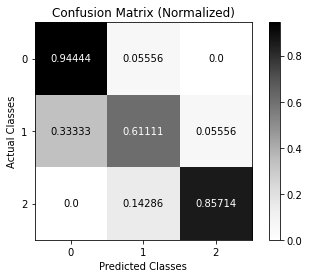

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.8018857271906054


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.74      0.94      0.83        18
Atypical Nevus       0.79      0.61      0.69        18
      Melanoma       0.92      0.86      0.89        14

      accuracy                           0.80        50
     macro avg       0.82      0.80      0.80        50
  weighted avg       0.81      0.80      0.79        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

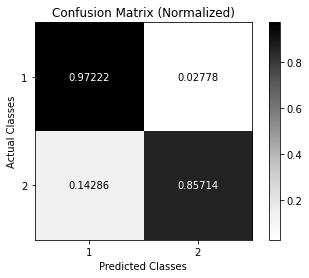

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.9238964992389651


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.95      0.97      0.96        36
            Melanoma       0.92      0.86      0.89        14

            accuracy                           0.94        50
           macro avg       0.93      0.91      0.92        50
        weighted avg       0.94      0.94      0.94        50



## Inception + classes' balance + $\pi/2$, $\pi$ rotation + gaussian blur. 

In [ ]:
means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [ ]:
transformations = tt.Compose([
    tt.ToTensor(),
    tt.Resize((299, 299)),
    tt.Normalize(means, stds)
])

In [ ]:
train_images = array_to_tensor(transformations, train_images_array)
val_images = array_to_tensor(transformations, val_images_array)

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
#for now we have 26 items of class 2 and 62 for 1 & 0, so balance all of them
#to have 100 elements.
new_train_images, new_train_target = balance_classes(train_images, list(y_train), 100)

In [ ]:
augmentations = [iaa.geometric.Rotate(90), iaa.geometric.Rotate(180)]
new_train_images, new_train_target = add_more_examples(new_train_images, list(new_train_target), augmentations)

In [ ]:
new_train_images = make_it_harder(new_train_images, augs_for_complication)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images, new_train_target)), batch_size = 16, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = 16, shuffle=False)

In [ ]:
best_score = 0

In [ ]:
def objective(trial):
    global best_score
    inception = models.inception_v3(pretrained=True)

    for params in inception.parameters():
        params.requires_grad_(True)

    inception.AuxLogits.fc = nn.Sequential(
        nn.Linear(768, 3, bias=True),
        nn.Softmax())

    inception.fc = nn.Sequential(
        nn.Linear(2048, 3, bias=True),
        nn.Softmax())
    
    inception = inception.to(DEVICE)
    
    lr = trial.suggest_uniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-1)
    gamma = trial.suggest_uniform('gamma', 0.25, 0.75)

    optimizer = torch.optim.AdamW(inception.parameters(), lr=lr,
                                            weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, 
                                            gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    history = train(inception, criterion, optimizer, 15, new_train_dataloader,
                val_dataloader, '/content/inception.pth', lr_scheduler, True)
    
    inception.load_state_dict(torch.load('/content/inception.pth'))
    
    loss, acc, val_loss, val_acc = zip(*history)

    if max(val_acc) > best_score:
        best_score = max(val_acc)
        torch.save(inception.state_dict(),
        '/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_expansion_3.pth')

    return max(val_acc)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-05-02 15:03:39,261] A new study created in memory with name: no-name-ada7feb1-f881-44a7-9c84-1e0d23fe0b76
epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2234236646342922


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.97s/it]


Epoch 001 train_loss: 1.2234     val_loss 0.8612 train_acc 0.6757 val_acc 0.7000
loss on train 0.9994807243347168


epoch:  13%|█▎        | 2/15 [00:24<02:39, 12.25s/it]


Epoch 002 train_loss: 0.9995     val_loss 0.9965 train_acc 0.8361 val_acc 0.5000
loss on train 0.8846482505669465


epoch:  20%|██        | 3/15 [00:36<02:26, 12.18s/it]


Epoch 003 train_loss: 0.8846     val_loss 0.8727 train_acc 0.9240 val_acc 0.6600
loss on train 0.8650953850230655


epoch:  27%|██▋       | 4/15 [00:49<02:19, 12.64s/it]


Epoch 004 train_loss: 0.8651     val_loss 0.8406 train_acc 0.9307 val_acc 0.7000
loss on train 0.8625524221239863


epoch:  33%|███▎      | 5/15 [01:02<02:07, 12.78s/it]


Epoch 005 train_loss: 0.8626     val_loss 0.8764 train_acc 0.9375 val_acc 0.6600
loss on train 0.8354629374839164


epoch:  40%|████      | 6/15 [01:15<01:53, 12.64s/it]


Epoch 006 train_loss: 0.8355     val_loss 0.8756 train_acc 0.9527 val_acc 0.6600
loss on train 0.8133356700072417


epoch:  47%|████▋     | 7/15 [01:26<01:38, 12.32s/it]


Epoch 007 train_loss: 0.8133     val_loss 0.8849 train_acc 0.9713 val_acc 0.6400
loss on train 0.7884811259604789


epoch:  53%|█████▎    | 8/15 [01:38<01:24, 12.13s/it]


Epoch 008 train_loss: 0.7885     val_loss 0.8759 train_acc 0.9899 val_acc 0.6800
loss on train 0.7863789136345322


epoch:  60%|██████    | 9/15 [01:50<01:12, 12.01s/it]


Epoch 009 train_loss: 0.7864     val_loss 0.8449 train_acc 0.9932 val_acc 0.7000
loss on train 0.7864040732383728


epoch:  67%|██████▋   | 10/15 [02:02<00:59, 11.92s/it]


Epoch 010 train_loss: 0.7864     val_loss 0.9039 train_acc 0.9916 val_acc 0.6400
loss on train 0.7841452521246832


epoch:  73%|███████▎  | 11/15 [02:13<00:47, 11.86s/it]


Epoch 011 train_loss: 0.7841     val_loss 0.8660 train_acc 0.9949 val_acc 0.6800
loss on train 0.7814646347148998


epoch:  80%|████████  | 12/15 [02:25<00:35, 11.90s/it]


Epoch 012 train_loss: 0.7815     val_loss 0.8790 train_acc 0.9932 val_acc 0.6800
loss on train 0.7848128112586769


epoch:  87%|████████▋ | 13/15 [02:37<00:23, 11.84s/it]


Epoch 013 train_loss: 0.7848     val_loss 0.8705 train_acc 0.9932 val_acc 0.6800
loss on train 0.779028515557985


epoch:  93%|█████████▎| 14/15 [02:49<00:11, 11.88s/it]


Epoch 014 train_loss: 0.7790     val_loss 0.8534 train_acc 0.9966 val_acc 0.7200
loss on train 0.7766466849559063


epoch: 100%|██████████| 15/15 [03:01<00:00, 12.09s/it]



Epoch 015 train_loss: 0.7766     val_loss 0.8646 train_acc 0.9966 val_acc 0.6800


[I 2022-05-02 15:06:41,241] Trial 0 finished with value: 0.72 and parameters: {'lr': 0.00021320736642807734, 'weight_decay': 0.0003154368359719464, 'gamma': 0.5597730073107997}. Best is trial 0 with value: 0.72.
epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2504480851663125


epoch:   7%|▋         | 1/15 [00:12<02:48, 12.04s/it]


Epoch 001 train_loss: 1.2504     val_loss 0.9075 train_acc 0.6520 val_acc 0.7200
loss on train 1.190657834748964


epoch:  13%|█▎        | 2/15 [00:23<02:34, 11.86s/it]


Epoch 002 train_loss: 1.1907     val_loss 0.9767 train_acc 0.6875 val_acc 0.6000
loss on train 1.231684394784876


epoch:  20%|██        | 3/15 [00:35<02:21, 11.82s/it]


Epoch 003 train_loss: 1.2317     val_loss 0.8698 train_acc 0.6503 val_acc 0.6600
loss on train 1.1759227900891691


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.79s/it]


Epoch 004 train_loss: 1.1759     val_loss 0.8865 train_acc 0.7044 val_acc 0.7000
loss on train 1.2020024125640456


epoch:  33%|███▎      | 5/15 [00:58<01:57, 11.75s/it]


Epoch 005 train_loss: 1.2020     val_loss 0.9781 train_acc 0.6807 val_acc 0.5600
loss on train 1.0889190854252995


epoch:  40%|████      | 6/15 [01:10<01:46, 11.80s/it]


Epoch 006 train_loss: 1.0889     val_loss 0.8516 train_acc 0.7551 val_acc 0.7000
loss on train 1.0133235825074685


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.76s/it]


Epoch 007 train_loss: 1.0133     val_loss 0.8664 train_acc 0.8311 val_acc 0.6800
loss on train 0.9793055154181816


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.73s/it]


Epoch 008 train_loss: 0.9793     val_loss 0.8503 train_acc 0.8463 val_acc 0.7000
loss on train 0.9878755405142501


epoch:  60%|██████    | 9/15 [01:46<01:11, 11.86s/it]


Epoch 009 train_loss: 0.9879     val_loss 0.8162 train_acc 0.8361 val_acc 0.7400
loss on train 0.9211751560907107


epoch:  67%|██████▋   | 10/15 [01:58<00:59, 11.81s/it]


Epoch 010 train_loss: 0.9212     val_loss 0.8368 train_acc 0.9037 val_acc 0.7000
loss on train 0.8846455490266955


epoch:  73%|███████▎  | 11/15 [02:10<00:47, 11.86s/it]


Epoch 011 train_loss: 0.8846     val_loss 0.7753 train_acc 0.9206 val_acc 0.8000
loss on train 0.8785201842720444


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.81s/it]


Epoch 012 train_loss: 0.8785     val_loss 0.8395 train_acc 0.9189 val_acc 0.7000
loss on train 0.8724861853831524


epoch:  87%|████████▋ | 13/15 [02:33<00:23, 11.77s/it]


Epoch 013 train_loss: 0.8725     val_loss 0.8155 train_acc 0.9257 val_acc 0.7200
loss on train 0.8689792027344575


epoch:  93%|█████████▎| 14/15 [02:45<00:11, 11.75s/it]


Epoch 014 train_loss: 0.8690     val_loss 0.7822 train_acc 0.9274 val_acc 0.7800
loss on train 0.8628804023201401


epoch: 100%|██████████| 15/15 [02:57<00:00, 11.80s/it]



Epoch 015 train_loss: 0.8629     val_loss 0.7996 train_acc 0.9341 val_acc 0.7600


[I 2022-05-02 15:09:39,229] Trial 1 finished with value: 0.8 and parameters: {'lr': 0.0007909562139197482, 'weight_decay': 0.02118195459180038, 'gamma': 0.36185123315203266}. Best is trial 1 with value: 0.8.
epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.253500777321893


epoch:   7%|▋         | 1/15 [00:12<02:48, 12.01s/it]


Epoch 001 train_loss: 1.2535     val_loss 0.8857 train_acc 0.6520 val_acc 0.6600
loss on train 1.1569980205716313


epoch:  13%|█▎        | 2/15 [00:23<02:35, 11.98s/it]


Epoch 002 train_loss: 1.1570     val_loss 0.8540 train_acc 0.7095 val_acc 0.7000
loss on train 1.0923213668771692


epoch:  20%|██        | 3/15 [00:35<02:22, 11.85s/it]


Epoch 003 train_loss: 1.0923     val_loss 1.0480 train_acc 0.7669 val_acc 0.4600
loss on train 1.080631304431606


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.78s/it]


Epoch 004 train_loss: 1.0806     val_loss 0.9258 train_acc 0.7686 val_acc 0.6200
loss on train 1.1105219286841315


epoch:  33%|███▎      | 5/15 [00:59<01:57, 11.76s/it]


Epoch 005 train_loss: 1.1105     val_loss 0.9133 train_acc 0.7534 val_acc 0.6400
loss on train 1.0778368034878292


epoch:  40%|████      | 6/15 [01:10<01:45, 11.74s/it]


Epoch 006 train_loss: 1.0778     val_loss 0.8595 train_acc 0.7753 val_acc 0.7000
loss on train 0.9647422900071015


epoch:  47%|████▋     | 7/15 [01:22<01:33, 11.73s/it]


Epoch 007 train_loss: 0.9647     val_loss 0.9113 train_acc 0.8564 val_acc 0.6200
loss on train 0.9547371928756302


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.72s/it]


Epoch 008 train_loss: 0.9547     val_loss 0.8745 train_acc 0.8666 val_acc 0.6800
loss on train 0.9073903206232432


epoch:  60%|██████    | 9/15 [01:45<01:10, 11.72s/it]


Epoch 009 train_loss: 0.9074     val_loss 0.8794 train_acc 0.9020 val_acc 0.6600
loss on train 0.9197309774321478


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.72s/it]


Epoch 010 train_loss: 0.9197     val_loss 0.9176 train_acc 0.8986 val_acc 0.6200
loss on train 0.8674543177759325


epoch:  73%|███████▎  | 11/15 [02:09<00:47, 11.79s/it]


Epoch 011 train_loss: 0.8675     val_loss 0.8049 train_acc 0.9375 val_acc 0.7200
loss on train 0.8415391702909727


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.76s/it]


Epoch 012 train_loss: 0.8415     val_loss 0.8203 train_acc 0.9578 val_acc 0.7000
loss on train 0.8199794679074675


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.75s/it]


Epoch 013 train_loss: 0.8200     val_loss 0.8271 train_acc 0.9730 val_acc 0.7000
loss on train 0.8175686903902002


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.74s/it]


Epoch 014 train_loss: 0.8176     val_loss 0.8677 train_acc 0.9747 val_acc 0.6600
loss on train 0.8228490223755708


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.76s/it]
[I 2022-05-02 15:12:36,208] Trial 2 finished with value: 0.72 and parameters: {'lr': 0.0005800555685608888, 'weight_decay': 0.09990910660576757, 'gamma': 0.35029607143367064}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 0.8228     val_loss 0.9048 train_acc 0.9662 val_acc 0.6000


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2856851042927921


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.98s/it]


Epoch 001 train_loss: 1.2857     val_loss 0.9430 train_acc 0.6284 val_acc 0.5800
loss on train 1.2938346331183974


epoch:  13%|█▎        | 2/15 [00:23<02:33, 11.82s/it]


Epoch 002 train_loss: 1.2938     val_loss 0.9544 train_acc 0.6064 val_acc 0.5800
loss on train 1.3001083038948678


epoch:  20%|██        | 3/15 [00:35<02:21, 11.76s/it]


Epoch 003 train_loss: 1.3001     val_loss 0.9765 train_acc 0.6132 val_acc 0.5600
loss on train 1.237848069216754


epoch:  27%|██▋       | 4/15 [00:47<02:08, 11.72s/it]


Epoch 004 train_loss: 1.2378     val_loss 1.0936 train_acc 0.6453 val_acc 0.4400
loss on train 1.1667669673223753


epoch:  33%|███▎      | 5/15 [00:58<01:57, 11.71s/it]


Epoch 005 train_loss: 1.1668     val_loss 1.0837 train_acc 0.7111 val_acc 0.4200
loss on train 1.1492543011098295


epoch:  40%|████      | 6/15 [01:10<01:46, 11.79s/it]


Epoch 006 train_loss: 1.1493     val_loss 0.9163 train_acc 0.7213 val_acc 0.6000
loss on train 1.0931089826532312


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.84s/it]


Epoch 007 train_loss: 1.0931     val_loss 0.8303 train_acc 0.7618 val_acc 0.7200
loss on train 1.1012239617270392


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.78s/it]


Epoch 008 train_loss: 1.1012     val_loss 0.9884 train_acc 0.7568 val_acc 0.5400
loss on train 1.046903692387246


epoch:  60%|██████    | 9/15 [01:45<01:10, 11.75s/it]


Epoch 009 train_loss: 1.0469     val_loss 0.9511 train_acc 0.7939 val_acc 0.5600
loss on train 1.0547283114613712


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.72s/it]


Epoch 010 train_loss: 1.0547     val_loss 0.9771 train_acc 0.7922 val_acc 0.5800
loss on train 0.9940403007172249


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.70s/it]


Epoch 011 train_loss: 0.9940     val_loss 0.8848 train_acc 0.8429 val_acc 0.6600
loss on train 0.9924334948127335


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.77s/it]


Epoch 012 train_loss: 0.9924     val_loss 0.8185 train_acc 0.8463 val_acc 0.7600
loss on train 0.9326446281897055


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.74s/it]


Epoch 013 train_loss: 0.9326     val_loss 0.8564 train_acc 0.8818 val_acc 0.7000
loss on train 0.9340107440948486


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.73s/it]


Epoch 014 train_loss: 0.9340     val_loss 0.8769 train_acc 0.8801 val_acc 0.6600
loss on train 0.9122358302812319


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.75s/it]
[I 2022-05-02 15:15:33,020] Trial 3 finished with value: 0.76 and parameters: {'lr': 0.0008884779307449675, 'weight_decay': 0.005977241169937266, 'gamma': 0.5142559248282039}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 0.9122     val_loss 0.8331 train_acc 0.9037 val_acc 0.7200


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3379550141257208


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.95s/it]


Epoch 001 train_loss: 1.3380     val_loss 1.1301 train_acc 0.5760 val_acc 0.3800
loss on train 1.3769808782113564


epoch:  13%|█▎        | 2/15 [00:23<02:35, 11.94s/it]


Epoch 002 train_loss: 1.3770     val_loss 1.0754 train_acc 0.5253 val_acc 0.4600
loss on train 1.267918180774998


epoch:  20%|██        | 3/15 [00:35<02:23, 11.94s/it]


Epoch 003 train_loss: 1.2679     val_loss 0.9539 train_acc 0.6267 val_acc 0.5600
loss on train 1.3192727050265751


epoch:  27%|██▋       | 4/15 [00:47<02:11, 11.94s/it]


Epoch 004 train_loss: 1.3193     val_loss 1.0126 train_acc 0.5895 val_acc 0.6000
loss on train 1.2650129021825016


epoch:  33%|███▎      | 5/15 [00:59<01:58, 11.84s/it]


Epoch 005 train_loss: 1.2650     val_loss 1.0651 train_acc 0.6233 val_acc 0.4000
loss on train 1.2275690001410406


epoch:  40%|████      | 6/15 [01:11<01:45, 11.78s/it]


Epoch 006 train_loss: 1.2276     val_loss 0.9920 train_acc 0.6689 val_acc 0.5000
loss on train 1.2340626168895412


epoch:  47%|████▋     | 7/15 [01:22<01:33, 11.74s/it]


Epoch 007 train_loss: 1.2341     val_loss 0.9998 train_acc 0.6622 val_acc 0.5400
loss on train 1.2146437586964787


epoch:  53%|█████▎    | 8/15 [01:34<01:21, 11.71s/it]


Epoch 008 train_loss: 1.2146     val_loss 0.9775 train_acc 0.6639 val_acc 0.5800
loss on train 1.166347772688479


epoch:  60%|██████    | 9/15 [01:46<01:10, 11.68s/it]


Epoch 009 train_loss: 1.1663     val_loss 0.9691 train_acc 0.7078 val_acc 0.5600
loss on train 1.1441198941823598


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.67s/it]


Epoch 010 train_loss: 1.1441     val_loss 0.9698 train_acc 0.7162 val_acc 0.5400
loss on train 1.0919308452992826


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.65s/it]


Epoch 011 train_loss: 1.0919     val_loss 0.9289 train_acc 0.7669 val_acc 0.5800
loss on train 1.058454682698121


epoch:  80%|████████  | 12/15 [02:20<00:34, 11.65s/it]


Epoch 012 train_loss: 1.0585     val_loss 0.9165 train_acc 0.7956 val_acc 0.6000
loss on train 1.0208399762978424


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.74s/it]


Epoch 013 train_loss: 1.0208     val_loss 0.9078 train_acc 0.8159 val_acc 0.6400
loss on train 1.0077589444212012


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.71s/it]


Epoch 014 train_loss: 1.0078     val_loss 0.9571 train_acc 0.8328 val_acc 0.5600
loss on train 1.0218151936659943


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.75s/it]
[I 2022-05-02 15:18:29,781] Trial 4 finished with value: 0.64 and parameters: {'lr': 0.0009660447526856383, 'weight_decay': 0.017845679692269946, 'gamma': 0.3784238820859966}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 1.0218     val_loss 0.9216 train_acc 0.8209 val_acc 0.6000


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3478048765981518


epoch:   7%|▋         | 1/15 [00:12<02:47, 11.99s/it]


Epoch 001 train_loss: 1.3478     val_loss 1.1125 train_acc 0.5456 val_acc 0.4000
loss on train 1.3102457845533215


epoch:  13%|█▎        | 2/15 [00:23<02:33, 11.81s/it]


Epoch 002 train_loss: 1.3102     val_loss 1.1378 train_acc 0.5929 val_acc 0.3800
loss on train 1.3256316958247005


epoch:  20%|██        | 3/15 [00:35<02:20, 11.74s/it]


Epoch 003 train_loss: 1.3256     val_loss 1.1804 train_acc 0.5608 val_acc 0.3400
loss on train 1.3005009341884304


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.80s/it]


Epoch 004 train_loss: 1.3005     val_loss 0.8941 train_acc 0.5946 val_acc 0.6200
loss on train 1.2826362300563503


epoch:  33%|███▎      | 5/15 [00:58<01:57, 11.75s/it]


Epoch 005 train_loss: 1.2826     val_loss 1.0122 train_acc 0.5929 val_acc 0.5400
loss on train 1.2349126822239644


epoch:  40%|████      | 6/15 [01:10<01:45, 11.70s/it]


Epoch 006 train_loss: 1.2349     val_loss 1.1501 train_acc 0.6605 val_acc 0.3600
loss on train 1.2324939805108148


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.77s/it]


Epoch 007 train_loss: 1.2325     val_loss 0.8628 train_acc 0.6537 val_acc 0.7000
loss on train 1.1955940046825924


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.72s/it]


Epoch 008 train_loss: 1.1956     val_loss 0.9199 train_acc 0.6791 val_acc 0.6000
loss on train 1.163526731568414


epoch:  60%|██████    | 9/15 [01:45<01:10, 11.69s/it]


Epoch 009 train_loss: 1.1635     val_loss 0.9440 train_acc 0.7044 val_acc 0.5600
loss on train 1.1124422211904783


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.67s/it]


Epoch 010 train_loss: 1.1124     val_loss 0.9067 train_acc 0.7517 val_acc 0.6400
loss on train 1.0833599970147416


epoch:  73%|███████▎  | 11/15 [02:08<00:46, 11.66s/it]


Epoch 011 train_loss: 1.0834     val_loss 0.8479 train_acc 0.7736 val_acc 0.7000
loss on train 1.0613130765992242


epoch:  80%|████████  | 12/15 [02:20<00:34, 11.66s/it]


Epoch 012 train_loss: 1.0613     val_loss 0.9308 train_acc 0.7787 val_acc 0.5800
loss on train 1.1127135495881777


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.65s/it]


Epoch 013 train_loss: 1.1127     val_loss 0.8819 train_acc 0.7432 val_acc 0.6600
loss on train 1.1204886017618954


epoch:  93%|█████████▎| 14/15 [02:43<00:11, 11.65s/it]


Epoch 014 train_loss: 1.1205     val_loss 0.9092 train_acc 0.7449 val_acc 0.6200
loss on train 1.1329403342427433


epoch: 100%|██████████| 15/15 [02:55<00:00, 11.70s/it]
[I 2022-05-02 15:21:25,836] Trial 5 finished with value: 0.7 and parameters: {'lr': 0.0009515757482041715, 'weight_decay': 0.021601073753662266, 'gamma': 0.7335880665256966}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 1.1329     val_loss 1.0093 train_acc 0.7230 val_acc 0.5400


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3294853261999182


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.96s/it]


Epoch 001 train_loss: 1.3295     val_loss 0.9535 train_acc 0.5608 val_acc 0.6000
loss on train 1.2412192434877962


epoch:  13%|█▎        | 2/15 [00:23<02:33, 11.80s/it]


Epoch 002 train_loss: 1.2412     val_loss 1.0419 train_acc 0.6605 val_acc 0.4400
loss on train 1.2213483501125026


epoch:  20%|██        | 3/15 [00:35<02:22, 11.86s/it]


Epoch 003 train_loss: 1.2213     val_loss 0.8376 train_acc 0.6503 val_acc 0.7400
loss on train 1.1920239506541073


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.79s/it]


Epoch 004 train_loss: 1.1920     val_loss 1.0483 train_acc 0.6892 val_acc 0.4600
loss on train 1.2309684753417969


epoch:  33%|███▎      | 5/15 [00:58<01:57, 11.74s/it]


Epoch 005 train_loss: 1.2310     val_loss 0.9865 train_acc 0.6605 val_acc 0.5600
loss on train 1.1472696388089978


epoch:  40%|████      | 6/15 [01:10<01:45, 11.71s/it]


Epoch 006 train_loss: 1.1473     val_loss 0.8667 train_acc 0.7196 val_acc 0.7000
loss on train 1.11345055457708


epoch:  47%|████▋     | 7/15 [01:22<01:33, 11.69s/it]


Epoch 007 train_loss: 1.1135     val_loss 0.9511 train_acc 0.7416 val_acc 0.5600
loss on train 1.0839370038058307


epoch:  53%|█████▎    | 8/15 [01:33<01:21, 11.68s/it]


Epoch 008 train_loss: 1.0839     val_loss 0.8812 train_acc 0.7686 val_acc 0.6600
loss on train 1.0975130619229496


epoch:  60%|██████    | 9/15 [01:45<01:10, 11.67s/it]


Epoch 009 train_loss: 1.0975     val_loss 0.9308 train_acc 0.7449 val_acc 0.6400
loss on train 1.0760165275754154


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.67s/it]


Epoch 010 train_loss: 1.0760     val_loss 0.8654 train_acc 0.7770 val_acc 0.7000
loss on train 1.0364705501375973


epoch:  73%|███████▎  | 11/15 [02:08<00:46, 11.67s/it]


Epoch 011 train_loss: 1.0365     val_loss 0.8381 train_acc 0.8125 val_acc 0.7000
loss on train 0.9813511291065732


epoch:  80%|████████  | 12/15 [02:20<00:34, 11.66s/it]


Epoch 012 train_loss: 0.9814     val_loss 0.9327 train_acc 0.8497 val_acc 0.6000
loss on train 0.949444181210286


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.73s/it]


Epoch 013 train_loss: 0.9494     val_loss 0.8037 train_acc 0.8699 val_acc 0.7600
loss on train 0.94570432482539


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.70s/it]


Epoch 014 train_loss: 0.9457     val_loss 0.8989 train_acc 0.8784 val_acc 0.6400
loss on train 0.9321384703790819


epoch: 100%|██████████| 15/15 [02:55<00:00, 11.71s/it]
[I 2022-05-02 15:24:22,114] Trial 6 finished with value: 0.76 and parameters: {'lr': 0.0008816855927083372, 'weight_decay': 0.03472002576011919, 'gamma': 0.49505771810404314}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 0.9321     val_loss 0.8642 train_acc 0.8784 val_acc 0.6800


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2148971638164006


epoch:   7%|▋         | 1/15 [00:12<02:48, 12.04s/it]


Epoch 001 train_loss: 1.2149     val_loss 1.0316 train_acc 0.6672 val_acc 0.4800
loss on train 1.1699053194071796


epoch:  13%|█▎        | 2/15 [00:24<02:36, 12.01s/it]


Epoch 002 train_loss: 1.1699     val_loss 0.9448 train_acc 0.6959 val_acc 0.5800
loss on train 1.0389871017352954


epoch:  20%|██        | 3/15 [00:35<02:22, 11.87s/it]


Epoch 003 train_loss: 1.0390     val_loss 0.9710 train_acc 0.8074 val_acc 0.5800
loss on train 1.098422516036678


epoch:  27%|██▋       | 4/15 [00:47<02:11, 11.91s/it]


Epoch 004 train_loss: 1.0984     val_loss 0.8860 train_acc 0.7601 val_acc 0.6400
loss on train 1.0818405747413635


epoch:  33%|███▎      | 5/15 [00:59<01:58, 11.83s/it]


Epoch 005 train_loss: 1.0818     val_loss 0.9554 train_acc 0.7686 val_acc 0.5800
loss on train 1.0090933345459603


epoch:  40%|████      | 6/15 [01:11<01:46, 11.87s/it]


Epoch 006 train_loss: 1.0091     val_loss 0.8229 train_acc 0.8294 val_acc 0.7200
loss on train 0.954168318091212


epoch:  47%|████▋     | 7/15 [01:23<01:34, 11.82s/it]


Epoch 007 train_loss: 0.9542     val_loss 0.8889 train_acc 0.8699 val_acc 0.6600
loss on train 0.9643090770051286


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.78s/it]


Epoch 008 train_loss: 0.9643     val_loss 0.8437 train_acc 0.8632 val_acc 0.7000
loss on train 0.876331221412968


epoch:  60%|██████    | 9/15 [01:46<01:10, 11.75s/it]


Epoch 009 train_loss: 0.8763     val_loss 0.9432 train_acc 0.9172 val_acc 0.5600
loss on train 0.8613623364551647


epoch:  67%|██████▋   | 10/15 [01:58<00:58, 11.74s/it]


Epoch 010 train_loss: 0.8614     val_loss 0.8335 train_acc 0.9307 val_acc 0.7000
loss on train 0.8388734121580381


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.72s/it]


Epoch 011 train_loss: 0.8389     val_loss 0.8381 train_acc 0.9544 val_acc 0.7000
loss on train 0.8019907055674372


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.72s/it]


Epoch 012 train_loss: 0.8020     val_loss 0.8409 train_acc 0.9831 val_acc 0.7000
loss on train 0.806269030313234


epoch:  87%|████████▋ | 13/15 [02:33<00:23, 11.71s/it]


Epoch 013 train_loss: 0.8063     val_loss 0.8244 train_acc 0.9730 val_acc 0.7200
loss on train 0.7980559726019163


epoch:  93%|█████████▎| 14/15 [02:45<00:11, 11.79s/it]


Epoch 014 train_loss: 0.7981     val_loss 0.8054 train_acc 0.9831 val_acc 0.7400
loss on train 0.8080109019537229


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.80s/it]
[I 2022-05-02 15:27:19,624] Trial 7 finished with value: 0.74 and parameters: {'lr': 0.000549161911830457, 'weight_decay': 0.004519032152968201, 'gamma': 0.32302695459844777}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 0.8080     val_loss 0.8200 train_acc 0.9747 val_acc 0.7400


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.1988112298217979


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.98s/it]


Epoch 001 train_loss: 1.1988     val_loss 0.8439 train_acc 0.6909 val_acc 0.7000
loss on train 0.9677261581292024


epoch:  13%|█▎        | 2/15 [00:23<02:33, 11.83s/it]


Epoch 002 train_loss: 0.9677     val_loss 0.8743 train_acc 0.8598 val_acc 0.6800
loss on train 0.980912530744398


epoch:  20%|██        | 3/15 [00:35<02:21, 11.79s/it]


Epoch 003 train_loss: 0.9809     val_loss 0.9267 train_acc 0.8446 val_acc 0.6000
loss on train 0.9410866466728417


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.77s/it]


Epoch 004 train_loss: 0.9411     val_loss 0.9163 train_acc 0.8733 val_acc 0.6400
loss on train 0.9167310112231487


epoch:  33%|███▎      | 5/15 [00:58<01:57, 11.75s/it]


Epoch 005 train_loss: 0.9167     val_loss 0.8451 train_acc 0.8919 val_acc 0.7000
loss on train 0.843203249815348


epoch:  40%|████      | 6/15 [01:10<01:46, 11.83s/it]


Epoch 006 train_loss: 0.8432     val_loss 0.8190 train_acc 0.9561 val_acc 0.7400
loss on train 0.8265075023109848


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.80s/it]


Epoch 007 train_loss: 0.8265     val_loss 0.8486 train_acc 0.9611 val_acc 0.7000
loss on train 0.8088215637851406


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.77s/it]


Epoch 008 train_loss: 0.8088     val_loss 0.8387 train_acc 0.9764 val_acc 0.7000
loss on train 0.7932862558880368


epoch:  60%|██████    | 9/15 [01:46<01:10, 11.76s/it]


Epoch 009 train_loss: 0.7933     val_loss 0.8450 train_acc 0.9848 val_acc 0.7000
loss on train 0.7862890346630199


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.75s/it]


Epoch 010 train_loss: 0.7863     val_loss 0.8117 train_acc 0.9916 val_acc 0.7400
loss on train 0.7836564585969255


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.74s/it]


Epoch 011 train_loss: 0.7837     val_loss 0.8147 train_acc 0.9932 val_acc 0.7200
loss on train 0.7782889491802937


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.73s/it]


Epoch 012 train_loss: 0.7783     val_loss 0.8156 train_acc 0.9983 val_acc 0.7200
loss on train 0.7806100394274738


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.73s/it]


Epoch 013 train_loss: 0.7806     val_loss 0.8371 train_acc 0.9949 val_acc 0.7000
loss on train 0.7804366366283314


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.73s/it]


Epoch 014 train_loss: 0.7804     val_loss 0.8269 train_acc 0.9949 val_acc 0.7000
loss on train 0.7773953482911393


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.76s/it]



Epoch 015 train_loss: 0.7774     val_loss 0.8087 train_acc 0.9983 val_acc 0.7400


[I 2022-05-02 15:30:16,654] Trial 8 finished with value: 0.74 and parameters: {'lr': 0.0002710561790786392, 'weight_decay': 0.00013142172467393685, 'gamma': 0.2947425267190236}. Best is trial 1 with value: 0.8.
epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2099772740054775


epoch:   7%|▋         | 1/15 [00:12<02:48, 12.00s/it]


Epoch 001 train_loss: 1.2100     val_loss 0.9085 train_acc 0.6909 val_acc 0.6200
loss on train 0.9844558480623606


epoch:  13%|█▎        | 2/15 [00:23<02:35, 11.99s/it]


Epoch 002 train_loss: 0.9845     val_loss 0.7629 train_acc 0.8378 val_acc 0.8000
loss on train 0.9019840118047353


epoch:  20%|██        | 3/15 [00:35<02:22, 11.87s/it]


Epoch 003 train_loss: 0.9020     val_loss 0.9578 train_acc 0.9155 val_acc 0.5600
loss on train 0.9009019764694007


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.82s/it]


Epoch 004 train_loss: 0.9009     val_loss 0.8672 train_acc 0.9054 val_acc 0.6600
loss on train 0.8836624316267065


epoch:  33%|███▎      | 5/15 [00:59<01:57, 11.78s/it]


Epoch 005 train_loss: 0.8837     val_loss 0.8393 train_acc 0.9206 val_acc 0.7400
loss on train 0.8487127391067711


epoch:  40%|████      | 6/15 [01:10<01:45, 11.75s/it]


Epoch 006 train_loss: 0.8487     val_loss 0.8238 train_acc 0.9443 val_acc 0.7200
loss on train 0.8323968391160708


epoch:  47%|████▋     | 7/15 [01:22<01:33, 11.74s/it]


Epoch 007 train_loss: 0.8324     val_loss 0.8233 train_acc 0.9561 val_acc 0.7000
loss on train 0.8081439942926973


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.73s/it]


Epoch 008 train_loss: 0.8081     val_loss 0.8174 train_acc 0.9780 val_acc 0.7400
loss on train 0.7969141747500446


epoch:  60%|██████    | 9/15 [01:45<01:10, 11.72s/it]


Epoch 009 train_loss: 0.7969     val_loss 0.8476 train_acc 0.9865 val_acc 0.6800
loss on train 0.80361822328052


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.72s/it]


Epoch 010 train_loss: 0.8036     val_loss 0.8149 train_acc 0.9780 val_acc 0.7200
loss on train 0.7972535974270588


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.72s/it]


Epoch 011 train_loss: 0.7973     val_loss 0.8452 train_acc 0.9848 val_acc 0.7000
loss on train 0.7851204372741081


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.72s/it]


Epoch 012 train_loss: 0.7851     val_loss 0.8405 train_acc 0.9916 val_acc 0.7000
loss on train 0.7794960270056853


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.72s/it]


Epoch 013 train_loss: 0.7795     val_loss 0.8499 train_acc 0.9966 val_acc 0.7000
loss on train 0.7776377619923772


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.72s/it]


Epoch 014 train_loss: 0.7776     val_loss 0.8536 train_acc 0.9983 val_acc 0.7000
loss on train 0.7761786950601114


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.75s/it]



Epoch 015 train_loss: 0.7762     val_loss 0.8557 train_acc 0.9966 val_acc 0.6600


[I 2022-05-02 15:33:13,553] Trial 9 finished with value: 0.8 and parameters: {'lr': 0.00021986055530480062, 'weight_decay': 0.08221574696597697, 'gamma': 0.6704426866443158}. Best is trial 1 with value: 0.8.
epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2683942962337185


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.97s/it]


Epoch 001 train_loss: 1.2684     val_loss 0.9418 train_acc 0.6216 val_acc 0.6000
loss on train 1.200162686206199


epoch:  13%|█▎        | 2/15 [00:23<02:33, 11.81s/it]


Epoch 002 train_loss: 1.2002     val_loss 1.0693 train_acc 0.6875 val_acc 0.4800
loss on train 1.19217681723672


epoch:  20%|██        | 3/15 [00:35<02:20, 11.75s/it]


Epoch 003 train_loss: 1.1922     val_loss 1.0484 train_acc 0.6875 val_acc 0.4400
loss on train 1.1624862100626971


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.73s/it]


Epoch 004 train_loss: 1.1625     val_loss 1.0269 train_acc 0.7078 val_acc 0.5200
loss on train 1.1888697131260022


epoch:  33%|███▎      | 5/15 [00:58<01:57, 11.71s/it]


Epoch 005 train_loss: 1.1889     val_loss 0.9775 train_acc 0.6892 val_acc 0.5600
loss on train 1.0662113589209479


epoch:  40%|████      | 6/15 [01:10<01:45, 11.70s/it]


Epoch 006 train_loss: 1.0662     val_loss 0.9606 train_acc 0.7838 val_acc 0.5600
loss on train 1.0149572797723718


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.79s/it]


Epoch 007 train_loss: 1.0150     val_loss 0.8876 train_acc 0.8294 val_acc 0.6600
loss on train 1.0082551112046112


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.75s/it]


Epoch 008 train_loss: 1.0083     val_loss 0.9243 train_acc 0.8260 val_acc 0.6200
loss on train 0.9985634700672047


epoch:  60%|██████    | 9/15 [01:45<01:10, 11.73s/it]


Epoch 009 train_loss: 0.9986     val_loss 0.9802 train_acc 0.8260 val_acc 0.5600
loss on train 0.9534130289747909


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.72s/it]


Epoch 010 train_loss: 0.9534     val_loss 0.8699 train_acc 0.8649 val_acc 0.6600
loss on train 0.9284140161565833


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.71s/it]


Epoch 011 train_loss: 0.9284     val_loss 0.9027 train_acc 0.8919 val_acc 0.6200
loss on train 0.8753995251011204


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.79s/it]


Epoch 012 train_loss: 0.8754     val_loss 0.8646 train_acc 0.9307 val_acc 0.7200
loss on train 0.8792042861113677


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.77s/it]


Epoch 013 train_loss: 0.8792     val_loss 0.8745 train_acc 0.9206 val_acc 0.6600
loss on train 0.8629336308788609


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.74s/it]


Epoch 014 train_loss: 0.8629     val_loss 0.8752 train_acc 0.9375 val_acc 0.6800
loss on train 0.8513598297093365


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.76s/it]



Epoch 015 train_loss: 0.8514     val_loss 0.8375 train_acc 0.9476 val_acc 0.7400


[I 2022-05-02 15:36:10,598] Trial 10 finished with value: 0.74 and parameters: {'lr': 0.0007369382138796489, 'weight_decay': 0.0008360915683528835, 'gamma': 0.4262120655567557}. Best is trial 1 with value: 0.8.
epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2788419626854561


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.97s/it]


Epoch 001 train_loss: 1.2788     val_loss 0.8593 train_acc 0.6622 val_acc 0.7000
loss on train 0.9432122191867313


epoch:  13%|█▎        | 2/15 [00:23<02:35, 11.98s/it]


Epoch 002 train_loss: 0.9432     val_loss 0.7936 train_acc 0.8868 val_acc 0.7600
loss on train 0.8708230514784117


epoch:  20%|██        | 3/15 [00:35<02:22, 11.87s/it]


Epoch 003 train_loss: 0.8708     val_loss 0.8172 train_acc 0.9341 val_acc 0.7200
loss on train 0.8213904258367177


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.81s/it]


Epoch 004 train_loss: 0.8214     val_loss 0.8313 train_acc 0.9730 val_acc 0.7000
loss on train 0.8189391928750116


epoch:  33%|███▎      | 5/15 [00:59<01:57, 11.78s/it]


Epoch 005 train_loss: 0.8189     val_loss 0.8988 train_acc 0.9730 val_acc 0.6000
loss on train 0.8108088551340876


epoch:  40%|████      | 6/15 [01:10<01:45, 11.76s/it]


Epoch 006 train_loss: 0.8108     val_loss 0.8400 train_acc 0.9764 val_acc 0.7200
loss on train 0.7878853952562487


epoch:  47%|████▋     | 7/15 [01:22<01:33, 11.75s/it]


Epoch 007 train_loss: 0.7879     val_loss 0.9137 train_acc 0.9949 val_acc 0.6400
loss on train 0.7838954635568567


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.74s/it]


Epoch 008 train_loss: 0.7839     val_loss 0.8697 train_acc 0.9949 val_acc 0.6400
loss on train 0.7850977424028758


epoch:  60%|██████    | 9/15 [01:46<01:10, 11.73s/it]


Epoch 009 train_loss: 0.7851     val_loss 0.8450 train_acc 0.9966 val_acc 0.7200
loss on train 0.7803022877590077


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.73s/it]


Epoch 010 train_loss: 0.7803     val_loss 0.8879 train_acc 0.9966 val_acc 0.6400
loss on train 0.7824957934585778


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.72s/it]


Epoch 011 train_loss: 0.7825     val_loss 0.8921 train_acc 0.9932 val_acc 0.6400
loss on train 0.7814461749953192


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.72s/it]


Epoch 012 train_loss: 0.7814     val_loss 0.8799 train_acc 0.9966 val_acc 0.6600
loss on train 0.7875146817516636


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.71s/it]


Epoch 013 train_loss: 0.7875     val_loss 0.8648 train_acc 0.9916 val_acc 0.6800
loss on train 0.7808202795080237


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.71s/it]


Epoch 014 train_loss: 0.7808     val_loss 0.9107 train_acc 0.9949 val_acc 0.6600
loss on train 0.78215307963861


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.77s/it]



Epoch 015 train_loss: 0.7822     val_loss 0.7944 train_acc 0.9949 val_acc 0.7800


[I 2022-05-02 15:39:07,794] Trial 11 finished with value: 0.78 and parameters: {'lr': 0.00010306538017435789, 'weight_decay': 0.08706952885411859, 'gamma': 0.6935685745237681}. Best is trial 1 with value: 0.8.
epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2330613361822593


epoch:   7%|▋         | 1/15 [00:12<02:48, 12.00s/it]


Epoch 001 train_loss: 1.2331     val_loss 1.0761 train_acc 0.6672 val_acc 0.4600
loss on train 1.083416540880461


epoch:  13%|█▎        | 2/15 [00:24<02:36, 12.01s/it]


Epoch 002 train_loss: 1.0834     val_loss 0.8978 train_acc 0.7703 val_acc 0.6400
loss on train 1.0656016066267684


epoch:  20%|██        | 3/15 [00:35<02:22, 11.88s/it]


Epoch 003 train_loss: 1.0656     val_loss 0.8964 train_acc 0.7872 val_acc 0.6400
loss on train 1.0301807152258384


epoch:  27%|██▋       | 4/15 [00:47<02:11, 11.93s/it]


Epoch 004 train_loss: 1.0302     val_loss 0.8482 train_acc 0.8108 val_acc 0.7000
loss on train 1.0111714907594629


epoch:  33%|███▎      | 5/15 [00:59<01:58, 11.86s/it]


Epoch 005 train_loss: 1.0112     val_loss 0.8818 train_acc 0.8209 val_acc 0.6800
loss on train 0.9572017901652569


epoch:  40%|████      | 6/15 [01:11<01:46, 11.80s/it]


Epoch 006 train_loss: 0.9572     val_loss 0.8563 train_acc 0.8632 val_acc 0.6800
loss on train 0.8971956307823593


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.77s/it]


Epoch 007 train_loss: 0.8972     val_loss 0.8660 train_acc 0.9088 val_acc 0.6800
loss on train 0.8606918760248132


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.74s/it]


Epoch 008 train_loss: 0.8607     val_loss 0.8613 train_acc 0.9375 val_acc 0.6600
loss on train 0.8280559085510872


epoch:  60%|██████    | 9/15 [01:46<01:10, 11.77s/it]


Epoch 009 train_loss: 0.8281     val_loss 0.8922 train_acc 0.9628 val_acc 0.6200
loss on train 0.8416797389855256


epoch:  67%|██████▋   | 10/15 [01:59<01:00, 12.09s/it]


Epoch 010 train_loss: 0.8417     val_loss 0.8833 train_acc 0.9459 val_acc 0.6400
loss on train 0.8245624996520378


epoch:  73%|███████▎  | 11/15 [02:10<00:47, 11.97s/it]


Epoch 011 train_loss: 0.8246     val_loss 0.8737 train_acc 0.9611 val_acc 0.6600
loss on train 0.812076570214452


epoch:  80%|████████  | 12/15 [02:22<00:35, 11.90s/it]


Epoch 012 train_loss: 0.8121     val_loss 0.8540 train_acc 0.9713 val_acc 0.6600
loss on train 0.8092255850096006


epoch:  87%|████████▋ | 13/15 [02:34<00:23, 11.94s/it]


Epoch 013 train_loss: 0.8092     val_loss 0.7952 train_acc 0.9747 val_acc 0.7600
loss on train 0.8132076408412006


epoch:  93%|█████████▎| 14/15 [02:46<00:11, 11.87s/it]


Epoch 014 train_loss: 0.8132     val_loss 0.8421 train_acc 0.9730 val_acc 0.6800
loss on train 0.791826610629623


epoch: 100%|██████████| 15/15 [02:58<00:00, 11.88s/it]
[I 2022-05-02 15:42:06,499] Trial 12 finished with value: 0.76 and parameters: {'lr': 0.00039245710127779466, 'weight_decay': 0.011316536445282176, 'gamma': 0.6566541604201311}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 0.7918     val_loss 0.8058 train_acc 0.9865 val_acc 0.7600


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.4861527004757442


epoch:   7%|▋         | 1/15 [00:12<02:48, 12.01s/it]


Epoch 001 train_loss: 1.4862     val_loss 1.0544 train_acc 0.4578 val_acc 0.5600
loss on train 1.327880066794318


epoch:  13%|█▎        | 2/15 [00:24<02:36, 12.01s/it]


Epoch 002 train_loss: 1.3279     val_loss 0.9848 train_acc 0.7111 val_acc 0.6600
loss on train 1.2049084482966244


epoch:  20%|██        | 3/15 [00:35<02:22, 11.88s/it]


Epoch 003 train_loss: 1.2049     val_loss 0.9420 train_acc 0.7804 val_acc 0.6200
loss on train 1.095065894964579


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.81s/it]


Epoch 004 train_loss: 1.0951     val_loss 0.9137 train_acc 0.8530 val_acc 0.6600
loss on train 1.0185046179874524


epoch:  33%|███▎      | 5/15 [00:59<01:57, 11.78s/it]


Epoch 005 train_loss: 1.0185     val_loss 0.9142 train_acc 0.8851 val_acc 0.6600
loss on train 0.9693190664858431


epoch:  40%|████      | 6/15 [01:10<01:45, 11.76s/it]


Epoch 006 train_loss: 0.9693     val_loss 0.9116 train_acc 0.9139 val_acc 0.5800
loss on train 0.9235637059082856


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.83s/it]


Epoch 007 train_loss: 0.9236     val_loss 0.8982 train_acc 0.9476 val_acc 0.6800
loss on train 0.8846852376654342


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.80s/it]


Epoch 008 train_loss: 0.8847     val_loss 0.8982 train_acc 0.9679 val_acc 0.6600
loss on train 0.8644637433258263


epoch:  60%|██████    | 9/15 [01:46<01:10, 11.77s/it]


Epoch 009 train_loss: 0.8645     val_loss 0.8894 train_acc 0.9797 val_acc 0.6600
loss on train 0.8670230217882104


epoch:  67%|██████▋   | 10/15 [01:58<00:58, 11.75s/it]


Epoch 010 train_loss: 0.8670     val_loss 0.8999 train_acc 0.9611 val_acc 0.6800
loss on train 0.8318200852419879


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.74s/it]


Epoch 011 train_loss: 0.8318     val_loss 0.8925 train_acc 0.9865 val_acc 0.6600
loss on train 0.8356737945530865


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.73s/it]


Epoch 012 train_loss: 0.8357     val_loss 0.8876 train_acc 0.9797 val_acc 0.6600
loss on train 0.8404203540570027


epoch:  87%|████████▋ | 13/15 [02:33<00:23, 11.73s/it]


Epoch 013 train_loss: 0.8404     val_loss 0.8951 train_acc 0.9713 val_acc 0.6600
loss on train 0.8281596576845324


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.71s/it]


Epoch 014 train_loss: 0.8282     val_loss 0.8891 train_acc 0.9865 val_acc 0.6400
loss on train 0.8295882199261639


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.77s/it]
[I 2022-05-02 15:45:03,679] Trial 13 finished with value: 0.68 and parameters: {'lr': 1.4726393630877304e-05, 'weight_decay': 0.0015410809074564108, 'gamma': 0.6049794535619158}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 0.8296     val_loss 0.8749 train_acc 0.9797 val_acc 0.6400


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.24587881565094


epoch:   7%|▋         | 1/15 [00:12<02:49, 12.09s/it]


Epoch 001 train_loss: 1.2459     val_loss 0.9920 train_acc 0.6436 val_acc 0.5400
loss on train 1.1943808052990887


epoch:  13%|█▎        | 2/15 [00:24<02:36, 12.01s/it]


Epoch 002 train_loss: 1.1944     val_loss 0.9611 train_acc 0.6807 val_acc 0.6000
loss on train 1.1209209110285785


epoch:  20%|██        | 3/15 [00:35<02:22, 11.88s/it]


Epoch 003 train_loss: 1.1209     val_loss 0.9350 train_acc 0.7331 val_acc 0.5800
loss on train 1.1165999625180218


epoch:  27%|██▋       | 4/15 [00:47<02:11, 11.91s/it]


Epoch 004 train_loss: 1.1166     val_loss 0.9010 train_acc 0.7432 val_acc 0.6600
loss on train 1.0650395831546269


epoch:  33%|███▎      | 5/15 [00:59<01:58, 11.84s/it]


Epoch 005 train_loss: 1.0650     val_loss 0.9187 train_acc 0.7905 val_acc 0.6200
loss on train 0.9966610573433541


epoch:  40%|████      | 6/15 [01:11<01:46, 11.89s/it]


Epoch 006 train_loss: 0.9967     val_loss 0.8518 train_acc 0.8345 val_acc 0.7000
loss on train 0.9237802528046273


epoch:  47%|████▋     | 7/15 [01:23<01:35, 11.91s/it]


Epoch 007 train_loss: 0.9238     val_loss 0.8394 train_acc 0.8902 val_acc 0.7200
loss on train 0.9101348036044353


epoch:  53%|█████▎    | 8/15 [01:35<01:23, 11.92s/it]


Epoch 008 train_loss: 0.9101     val_loss 0.7946 train_acc 0.9105 val_acc 0.7600
loss on train 0.8893659420915552


epoch:  60%|██████    | 9/15 [01:47<01:11, 11.85s/it]


Epoch 009 train_loss: 0.8894     val_loss 0.8237 train_acc 0.9155 val_acc 0.7000
loss on train 0.8963878863566631


epoch:  67%|██████▋   | 10/15 [01:58<00:59, 11.80s/it]


Epoch 010 train_loss: 0.8964     val_loss 0.8212 train_acc 0.9054 val_acc 0.7400
loss on train 0.8677531448570458


epoch:  73%|███████▎  | 11/15 [02:10<00:47, 11.85s/it]


Epoch 011 train_loss: 0.8678     val_loss 0.7948 train_acc 0.9375 val_acc 0.7800
loss on train 0.8297371638787759


epoch:  80%|████████  | 12/15 [02:22<00:35, 11.88s/it]


Epoch 012 train_loss: 0.8297     val_loss 0.7832 train_acc 0.9645 val_acc 0.8000
loss on train 0.823112115666673


epoch:  87%|████████▋ | 13/15 [02:34<00:23, 11.83s/it]


Epoch 013 train_loss: 0.8231     val_loss 0.8206 train_acc 0.9662 val_acc 0.7200
loss on train 0.8283736560795758


epoch:  93%|█████████▎| 14/15 [02:46<00:11, 11.79s/it]


Epoch 014 train_loss: 0.8284     val_loss 0.7856 train_acc 0.9611 val_acc 0.7600
loss on train 0.829752546709937


epoch: 100%|██████████| 15/15 [02:57<00:00, 11.85s/it]
[I 2022-05-02 15:48:01,978] Trial 14 finished with value: 0.8 and parameters: {'lr': 0.0006524994570839339, 'weight_decay': 0.04552959744591349, 'gamma': 0.2538636480294254}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 0.8298     val_loss 0.8351 train_acc 0.9578 val_acc 0.7200


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2215971366779224


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.94s/it]


Epoch 001 train_loss: 1.2216     val_loss 0.9411 train_acc 0.6605 val_acc 0.6200
loss on train 1.0642963599514317


epoch:  13%|█▎        | 2/15 [00:23<02:33, 11.80s/it]


Epoch 002 train_loss: 1.0643     val_loss 0.9471 train_acc 0.7838 val_acc 0.6000
loss on train 1.0401278863082062


epoch:  20%|██        | 3/15 [00:35<02:21, 11.76s/it]


Epoch 003 train_loss: 1.0401     val_loss 0.9282 train_acc 0.8057 val_acc 0.6200
loss on train 1.0164618105501741


epoch:  27%|██▋       | 4/15 [00:47<02:10, 11.84s/it]


Epoch 004 train_loss: 1.0165     val_loss 0.8497 train_acc 0.8243 val_acc 0.7000
loss on train 1.021383201753771


epoch:  33%|███▎      | 5/15 [00:59<01:58, 11.90s/it]


Epoch 005 train_loss: 1.0214     val_loss 0.8271 train_acc 0.8159 val_acc 0.7200
loss on train 0.9762759450319651


epoch:  40%|████      | 6/15 [01:11<01:46, 11.83s/it]


Epoch 006 train_loss: 0.9763     val_loss 0.8415 train_acc 0.8514 val_acc 0.7000
loss on train 0.9136663047043053


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.79s/it]


Epoch 007 train_loss: 0.9137     val_loss 0.8161 train_acc 0.8970 val_acc 0.6800
loss on train 0.8553490960920179


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.76s/it]


Epoch 008 train_loss: 0.8553     val_loss 0.8602 train_acc 0.9459 val_acc 0.7000
loss on train 0.8383679728250246


epoch:  60%|██████    | 9/15 [01:46<01:10, 11.74s/it]


Epoch 009 train_loss: 0.8384     val_loss 0.8703 train_acc 0.9527 val_acc 0.6600
loss on train 0.827166335002796


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.74s/it]


Epoch 010 train_loss: 0.8272     val_loss 0.8307 train_acc 0.9628 val_acc 0.7200
loss on train 0.8087371297784753


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.73s/it]


Epoch 011 train_loss: 0.8087     val_loss 0.8531 train_acc 0.9780 val_acc 0.6600
loss on train 0.8112428736042332


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.80s/it]


Epoch 012 train_loss: 0.8112     val_loss 0.7950 train_acc 0.9713 val_acc 0.7400
loss on train 0.7893527327357112


epoch:  87%|████████▋ | 13/15 [02:33<00:23, 11.77s/it]


Epoch 013 train_loss: 0.7894     val_loss 0.8201 train_acc 0.9882 val_acc 0.7000
loss on train 0.7984528122721491


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.75s/it]


Epoch 014 train_loss: 0.7985     val_loss 0.8139 train_acc 0.9831 val_acc 0.7400
loss on train 0.7862919375703141


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.78s/it]
[I 2022-05-02 15:50:59,206] Trial 15 finished with value: 0.74 and parameters: {'lr': 0.0003996415722779348, 'weight_decay': 0.010348734565091368, 'gamma': 0.43609991849621815}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 0.7863     val_loss 0.8190 train_acc 0.9916 val_acc 0.7200


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2373576405886058


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.96s/it]


Epoch 001 train_loss: 1.2374     val_loss 0.9803 train_acc 0.6554 val_acc 0.5800
loss on train 1.2165162853292517


epoch:  13%|█▎        | 2/15 [00:23<02:35, 11.97s/it]


Epoch 002 train_loss: 1.2165     val_loss 0.9142 train_acc 0.6622 val_acc 0.6200
loss on train 1.1857248319161904


epoch:  20%|██        | 3/15 [00:35<02:22, 11.85s/it]


Epoch 003 train_loss: 1.1857     val_loss 1.0666 train_acc 0.6943 val_acc 0.4400
loss on train 1.145107361110481


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.79s/it]


Epoch 004 train_loss: 1.1451     val_loss 1.0612 train_acc 0.7297 val_acc 0.4800
loss on train 1.1187362010414537


epoch:  33%|███▎      | 5/15 [00:59<01:57, 11.75s/it]


Epoch 005 train_loss: 1.1187     val_loss 1.0378 train_acc 0.7365 val_acc 0.5000
loss on train 1.0977241364685264


epoch:  40%|████      | 6/15 [01:10<01:45, 11.72s/it]


Epoch 006 train_loss: 1.0977     val_loss 1.0248 train_acc 0.7618 val_acc 0.5200
loss on train 1.0466404057837821


epoch:  47%|████▋     | 7/15 [01:22<01:33, 11.71s/it]


Epoch 007 train_loss: 1.0466     val_loss 0.9531 train_acc 0.7990 val_acc 0.6000
loss on train 1.0322641859183441


epoch:  53%|█████▎    | 8/15 [01:34<01:21, 11.69s/it]


Epoch 008 train_loss: 1.0323     val_loss 0.9423 train_acc 0.8007 val_acc 0.6200
loss on train 0.9775009702991795


epoch:  60%|██████    | 9/15 [01:45<01:10, 11.76s/it]


Epoch 009 train_loss: 0.9775     val_loss 0.8871 train_acc 0.8530 val_acc 0.6600
loss on train 0.9445262583526405


epoch:  67%|██████▋   | 10/15 [01:57<00:59, 11.81s/it]


Epoch 010 train_loss: 0.9445     val_loss 0.8145 train_acc 0.8767 val_acc 0.7400
loss on train 0.9120923989527935


epoch:  73%|███████▎  | 11/15 [02:09<00:47, 11.77s/it]


Epoch 011 train_loss: 0.9121     val_loss 0.8135 train_acc 0.8970 val_acc 0.7400
loss on train 0.9005442567773767


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.74s/it]


Epoch 012 train_loss: 0.9005     val_loss 0.9263 train_acc 0.9105 val_acc 0.6000
loss on train 0.8809896224253887


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.73s/it]


Epoch 013 train_loss: 0.8810     val_loss 0.8225 train_acc 0.9240 val_acc 0.7400
loss on train 0.8659239379135338


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.72s/it]


Epoch 014 train_loss: 0.8659     val_loss 0.8746 train_acc 0.9341 val_acc 0.6600
loss on train 0.8733552162711685


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.75s/it]
[I 2022-05-02 15:53:56,093] Trial 16 finished with value: 0.74 and parameters: {'lr': 0.0007205357682892917, 'weight_decay': 0.050063825207208736, 'gamma': 0.6156162861457699}. Best is trial 1 with value: 0.8.



Epoch 015 train_loss: 0.8734     val_loss 0.8749 train_acc 0.9291 val_acc 0.6800


epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3099228369223106


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.94s/it]


Epoch 001 train_loss: 1.3099     val_loss 1.0117 train_acc 0.5929 val_acc 0.5600
loss on train 1.1847460801536973


epoch:  13%|█▎        | 2/15 [00:23<02:35, 11.96s/it]


Epoch 002 train_loss: 1.1847     val_loss 0.9792 train_acc 0.6993 val_acc 0.5800
loss on train 1.1923957821485158


epoch:  20%|██        | 3/15 [00:35<02:23, 11.96s/it]


Epoch 003 train_loss: 1.1924     val_loss 0.9722 train_acc 0.6959 val_acc 0.6000
loss on train 1.2147372783841313


epoch:  27%|██▋       | 4/15 [00:47<02:10, 11.83s/it]


Epoch 004 train_loss: 1.2147     val_loss 1.0313 train_acc 0.6672 val_acc 0.4600
loss on train 1.1834871076248787


epoch:  33%|███▎      | 5/15 [00:59<01:58, 11.87s/it]


Epoch 005 train_loss: 1.1835     val_loss 0.8677 train_acc 0.6926 val_acc 0.7000
loss on train 1.0930013576069393


epoch:  40%|████      | 6/15 [01:11<01:46, 11.80s/it]


Epoch 006 train_loss: 1.0930     val_loss 0.8659 train_acc 0.7770 val_acc 0.6600
loss on train 1.0545231409975


epoch:  47%|████▋     | 7/15 [01:23<01:34, 11.85s/it]


Epoch 007 train_loss: 1.0545     val_loss 0.8187 train_acc 0.7905 val_acc 0.7200
loss on train 1.0122266943390306


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.79s/it]


Epoch 008 train_loss: 1.0122     val_loss 0.8246 train_acc 0.8294 val_acc 0.7200
loss on train 0.965940353032705


epoch:  60%|██████    | 9/15 [01:46<01:10, 11.76s/it]


Epoch 009 train_loss: 0.9659     val_loss 0.8070 train_acc 0.8649 val_acc 0.7200
loss on train 0.9298976047618969


epoch:  67%|██████▋   | 10/15 [01:58<00:58, 11.73s/it]


Epoch 010 train_loss: 0.9299     val_loss 0.7986 train_acc 0.8919 val_acc 0.7200
loss on train 0.9126200418214541


epoch:  73%|███████▎  | 11/15 [02:10<00:47, 11.80s/it]


Epoch 011 train_loss: 0.9126     val_loss 0.7926 train_acc 0.9003 val_acc 0.7600
loss on train 0.8837663402428498


epoch:  80%|████████  | 12/15 [02:21<00:35, 11.75s/it]


Epoch 012 train_loss: 0.8838     val_loss 0.7867 train_acc 0.9172 val_acc 0.7600
loss on train 0.8813989951803878


epoch:  87%|████████▋ | 13/15 [02:33<00:23, 11.72s/it]


Epoch 013 train_loss: 0.8814     val_loss 0.7988 train_acc 0.9240 val_acc 0.7400
loss on train 0.863169934298541


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.70s/it]


Epoch 014 train_loss: 0.8632     val_loss 0.8207 train_acc 0.9358 val_acc 0.7200
loss on train 0.8653096540554149


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.78s/it]



Epoch 015 train_loss: 0.8653     val_loss 0.8306 train_acc 0.9358 val_acc 0.6800


[I 2022-05-02 15:56:53,348] Trial 17 finished with value: 0.76 and parameters: {'lr': 0.0007078095036568938, 'weight_decay': 0.028642839867296155, 'gamma': 0.2541501447842558}. Best is trial 1 with value: 0.8.
epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.278765633299544


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.96s/it]


Epoch 001 train_loss: 1.2788     val_loss 0.9478 train_acc 0.6385 val_acc 0.6200
loss on train 1.17169764235213


epoch:  13%|█▎        | 2/15 [00:23<02:33, 11.80s/it]


Epoch 002 train_loss: 1.1717     val_loss 1.0276 train_acc 0.6959 val_acc 0.5200
loss on train 1.1593742451152287


epoch:  20%|██        | 3/15 [00:35<02:21, 11.75s/it]


Epoch 003 train_loss: 1.1594     val_loss 0.9579 train_acc 0.7095 val_acc 0.5400
loss on train 1.2173561953209542


epoch:  27%|██▋       | 4/15 [00:47<02:08, 11.73s/it]


Epoch 004 train_loss: 1.2174     val_loss 1.0174 train_acc 0.6774 val_acc 0.5000
loss on train 1.1527071659629409


epoch:  33%|███▎      | 5/15 [00:58<01:56, 11.70s/it]


Epoch 005 train_loss: 1.1527     val_loss 1.0143 train_acc 0.7264 val_acc 0.5200
loss on train 1.0766462442037221


epoch:  40%|████      | 6/15 [01:10<01:46, 11.78s/it]


Epoch 006 train_loss: 1.0766     val_loss 0.9355 train_acc 0.7703 val_acc 0.6600
loss on train 0.988558068468764


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.75s/it]


Epoch 007 train_loss: 0.9886     val_loss 0.9050 train_acc 0.8345 val_acc 0.6200
loss on train 0.9478796962145213


epoch:  53%|█████▎    | 8/15 [01:33<01:22, 11.73s/it]


Epoch 008 train_loss: 0.9479     val_loss 0.9169 train_acc 0.8818 val_acc 0.6200
loss on train 0.9693569073805938


epoch:  60%|██████    | 9/15 [01:45<01:10, 11.71s/it]


Epoch 009 train_loss: 0.9694     val_loss 0.8489 train_acc 0.8581 val_acc 0.6400
loss on train 0.9168316641369382


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.77s/it]


Epoch 010 train_loss: 0.9168     val_loss 0.7959 train_acc 0.8936 val_acc 0.7600
loss on train 0.8853442668914795


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.74s/it]


Epoch 011 train_loss: 0.8853     val_loss 0.8330 train_acc 0.9155 val_acc 0.7000
loss on train 0.8508999476561675


epoch:  80%|████████  | 12/15 [02:20<00:35, 11.71s/it]


Epoch 012 train_loss: 0.8509     val_loss 0.8121 train_acc 0.9459 val_acc 0.7200
loss on train 0.8403867128733042


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.70s/it]


Epoch 013 train_loss: 0.8404     val_loss 0.8087 train_acc 0.9544 val_acc 0.7400
loss on train 0.8312078907683089


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.69s/it]


Epoch 014 train_loss: 0.8312     val_loss 0.8439 train_acc 0.9544 val_acc 0.7000
loss on train 0.8394156066147057


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.75s/it]



Epoch 015 train_loss: 0.8394     val_loss 0.7951 train_acc 0.9544 val_acc 0.7800


[I 2022-05-02 15:59:50,115] Trial 18 finished with value: 0.78 and parameters: {'lr': 0.0006442487146000218, 'weight_decay': 0.0021518579001495136, 'gamma': 0.26771028944030906}. Best is trial 1 with value: 0.8.
epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2283117223430324


epoch:   7%|▋         | 1/15 [00:11<02:47, 11.95s/it]


Epoch 001 train_loss: 1.2283     val_loss 0.8491 train_acc 0.6807 val_acc 0.7000
loss on train 1.0888433859154985


epoch:  13%|█▎        | 2/15 [00:23<02:33, 11.81s/it]


Epoch 002 train_loss: 1.0888     val_loss 0.9919 train_acc 0.7686 val_acc 0.5600
loss on train 1.0078300527624182


epoch:  20%|██        | 3/15 [00:35<02:21, 11.76s/it]


Epoch 003 train_loss: 1.0078     val_loss 0.8820 train_acc 0.8277 val_acc 0.6800
loss on train 0.9930075825871648


epoch:  27%|██▋       | 4/15 [00:47<02:09, 11.74s/it]


Epoch 004 train_loss: 0.9930     val_loss 1.0256 train_acc 0.8311 val_acc 0.5400
loss on train 0.966684383315009


epoch:  33%|███▎      | 5/15 [00:58<01:57, 11.72s/it]


Epoch 005 train_loss: 0.9667     val_loss 0.9525 train_acc 0.8547 val_acc 0.5800
loss on train 0.9137958755364289


epoch:  40%|████      | 6/15 [01:10<01:46, 11.81s/it]


Epoch 006 train_loss: 0.9138     val_loss 0.8019 train_acc 0.8919 val_acc 0.7600
loss on train 0.8423317525837872


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.78s/it]


Epoch 007 train_loss: 0.8423     val_loss 0.8861 train_acc 0.9476 val_acc 0.6400
loss on train 0.829920362781834


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.75s/it]


Epoch 008 train_loss: 0.8299     val_loss 0.8386 train_acc 0.9595 val_acc 0.7000
loss on train 0.8208289178642066


epoch:  60%|██████    | 9/15 [01:45<01:10, 11.73s/it]


Epoch 009 train_loss: 0.8208     val_loss 0.7908 train_acc 0.9679 val_acc 0.7600
loss on train 0.8186717194479864


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.72s/it]


Epoch 010 train_loss: 0.8187     val_loss 0.8691 train_acc 0.9628 val_acc 0.6800
loss on train 0.8053844812754039


epoch:  73%|███████▎  | 11/15 [02:09<00:46, 11.71s/it]


Epoch 011 train_loss: 0.8054     val_loss 0.8349 train_acc 0.9780 val_acc 0.7200
loss on train 0.8068162428366171


epoch:  80%|████████  | 12/15 [02:20<00:35, 11.71s/it]


Epoch 012 train_loss: 0.8068     val_loss 0.8406 train_acc 0.9780 val_acc 0.7200
loss on train 0.793490390519838


epoch:  87%|████████▋ | 13/15 [02:32<00:23, 11.70s/it]


Epoch 013 train_loss: 0.7935     val_loss 0.8408 train_acc 0.9882 val_acc 0.7000
loss on train 0.7989366408940908


epoch:  93%|█████████▎| 14/15 [02:44<00:11, 11.70s/it]


Epoch 014 train_loss: 0.7989     val_loss 0.8233 train_acc 0.9814 val_acc 0.7400
loss on train 0.7874602498234929


epoch: 100%|██████████| 15/15 [02:56<00:00, 11.73s/it]



Epoch 015 train_loss: 0.7875     val_loss 0.8352 train_acc 0.9916 val_acc 0.7200


[I 2022-05-02 16:02:46,720] Trial 19 finished with value: 0.76 and parameters: {'lr': 0.00044256073219816667, 'weight_decay': 0.009134265181327799, 'gamma': 0.43816715605349066}. Best is trial 1 with value: 0.8.


In [ ]:
inception_class_exp_3 = models.inception_v3(pretrained=True)

In [ ]:
inception_class_exp_3.AuxLogits.fc = nn.Sequential(
    nn.Linear(768, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_class_exp_3.fc = nn.Sequential(
    nn.Linear(2048, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_class_exp_3.load_state_dict(torch.load('/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_expansion_3.pth',
                                                 map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
inception_class_exp_3 = inception_class_exp_3.to(DEVICE)

In [ ]:
print(show_accuracy(inception_class_exp_3, val_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'Typical Nevus': 0.5555555555555556, 'Atyical Nevus': 0.9444444444444444, 'Melanoma': 0.9285714285714286}


In [ ]:
labels, predicts = get_predictions(inception_class_exp_3, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


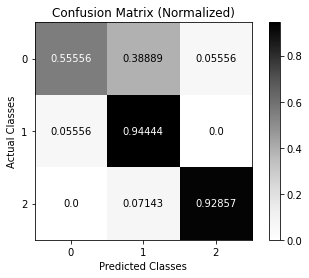

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.8029747584679422


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.91      0.56      0.69        18
Atypical Nevus       0.68      0.94      0.79        18
      Melanoma       0.93      0.93      0.93        14

      accuracy                           0.80        50
     macro avg       0.84      0.81      0.80        50
  weighted avg       0.83      0.80      0.79        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

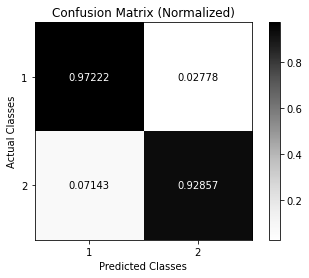

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.9503968253968254


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.97      0.97      0.97        36
            Melanoma       0.93      0.93      0.93        14

            accuracy                           0.96        50
           macro avg       0.95      0.95      0.95        50
        weighted avg       0.96      0.96      0.96        50



## Inception + classes' balance + $\pi/2$, $\pi$, $3\pi/2$ rotation + gaussian blur. 

In [ ]:
means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [ ]:
transformations = tt.Compose([
    tt.ToTensor(),
    tt.Resize((299, 299)),
    tt.Normalize(means, stds)
])

In [ ]:
train_images = array_to_tensor(transformations, train_images_array)
val_images = array_to_tensor(transformations, val_images_array)

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
#for now we have 26 items of class 2 and 62 for 1 & 0, so balance all of them
#to have 100 elements.
new_train_images, new_train_target = balance_classes(train_images, list(y_train), 100)

In [ ]:
augmentations = [iaa.geometric.Rotate(90), iaa.geometric.Rotate(180), iaa.geometric.Rotate(270)]
new_train_images, new_train_target = add_more_examples(new_train_images, list(new_train_target), augmentations)

In [ ]:
new_train_images = make_it_harder(new_train_images, augs_for_complication)

In [ ]:
new_train_dataloader = DataLoader(list(zip(new_train_images, new_train_target)), batch_size = 16, shuffle=True)
val_dataloader = DataLoader(list(zip(val_images, list(y_val))), batch_size = 16, shuffle=False)

In [ ]:
best_score = 0

In [ ]:
def objective(trial):
    global best_score
    inception = models.inception_v3(pretrained=True)

    for params in inception.parameters():
        params.requires_grad_(True)

    inception.AuxLogits.fc = nn.Sequential(
        nn.Linear(768, 3, bias=True),
        nn.Softmax())

    inception.fc = nn.Sequential(
        nn.Linear(2048, 3, bias=True),
        nn.Softmax())
    
    inception = inception.to(DEVICE)
    
    lr = trial.suggest_uniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-1)
    gamma = trial.suggest_uniform('gamma', 0.25, 0.75)

    optimizer = torch.optim.AdamW(inception.parameters(), lr=lr,
                                            weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, 
                                            gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    history = train(inception, criterion, optimizer, 10, new_train_dataloader,
                val_dataloader, '/content/inception.pth', lr_scheduler, True)
    
    inception.load_state_dict(torch.load('/content/inception.pth'))
    
    loss, acc, val_loss, val_acc = zip(*history)

    if max(val_acc) > best_score:
        best_score = max(val_acc)
        torch.save(inception.state_dict(),
        '/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_expansion_4.pth')

    return max(val_acc)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-05-01 16:32:22,917] A new study created in memory with name: no-name-1a2b5db3-699a-4515-a464-0acb12475097
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2362019736716088


epoch:  10%|█         | 1/10 [00:29<04:29, 29.90s/it]


Epoch 001 train_loss: 1.2362     val_loss 0.7695 train_acc 0.6649 val_acc 0.8200
loss on train 1.1537279194973884


epoch:  20%|██        | 2/10 [00:59<03:58, 29.76s/it]


Epoch 002 train_loss: 1.1537     val_loss 0.9913 train_acc 0.7128 val_acc 0.5400
loss on train 1.0952845925980426


epoch:  30%|███       | 3/10 [01:29<03:28, 29.79s/it]


Epoch 003 train_loss: 1.0953     val_loss 0.9284 train_acc 0.7699 val_acc 0.6200
loss on train 1.1123012025305565


epoch:  40%|████      | 4/10 [01:59<02:59, 29.84s/it]


Epoch 004 train_loss: 1.1123     val_loss 1.1537 train_acc 0.7566 val_acc 0.4000
loss on train 1.0863910710557978


epoch:  50%|█████     | 5/10 [02:29<02:28, 29.80s/it]


Epoch 005 train_loss: 1.0864     val_loss 0.9275 train_acc 0.7686 val_acc 0.6200
loss on train 1.0348542992104874


epoch:  60%|██████    | 6/10 [02:58<01:59, 29.78s/it]


Epoch 006 train_loss: 1.0349     val_loss 0.8300 train_acc 0.8125 val_acc 0.7200
loss on train 0.9854061007499695


epoch:  70%|███████   | 7/10 [03:28<01:29, 29.75s/it]


Epoch 007 train_loss: 0.9854     val_loss 0.8875 train_acc 0.8431 val_acc 0.6600
loss on train 0.9395656344738412


epoch:  80%|████████  | 8/10 [03:58<00:59, 29.73s/it]


Epoch 008 train_loss: 0.9396     val_loss 0.8282 train_acc 0.8777 val_acc 0.7200
loss on train 0.9150275270989601


epoch:  90%|█████████ | 9/10 [04:27<00:29, 29.72s/it]


Epoch 009 train_loss: 0.9150     val_loss 0.8448 train_acc 0.9029 val_acc 0.6800
loss on train 0.8800929391637762


epoch: 100%|██████████| 10/10 [04:57<00:00, 29.76s/it]



Epoch 010 train_loss: 0.8801     val_loss 0.8070 train_acc 0.9229 val_acc 0.7400


[I 2022-05-01 16:37:35,991] Trial 0 finished with value: 0.82 and parameters: {'lr': 0.0005443371487148355, 'weight_decay': 0.0010699422998068572, 'gamma': 0.25384097142498413}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2205990628993257


epoch:  10%|█         | 1/10 [00:30<04:32, 30.24s/it]


Epoch 001 train_loss: 1.2206     val_loss 0.7694 train_acc 0.6596 val_acc 0.7800
loss on train 1.126529280175554


epoch:  20%|██        | 2/10 [01:00<03:59, 29.98s/it]


Epoch 002 train_loss: 1.1265     val_loss 1.0482 train_acc 0.7407 val_acc 0.5000
loss on train 1.1477811869154586


epoch:  30%|███       | 3/10 [01:29<03:29, 29.87s/it]


Epoch 003 train_loss: 1.1478     val_loss 0.7998 train_acc 0.7234 val_acc 0.7000
loss on train 1.0612137901022078


epoch:  40%|████      | 4/10 [01:59<02:59, 29.84s/it]


Epoch 004 train_loss: 1.0612     val_loss 0.8268 train_acc 0.7846 val_acc 0.6800
loss on train 1.0063286246137415


epoch:  50%|█████     | 5/10 [02:29<02:29, 29.83s/it]


Epoch 005 train_loss: 1.0063     val_loss 0.9003 train_acc 0.8391 val_acc 0.6400
loss on train 0.9442198060928507


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.82s/it]


Epoch 006 train_loss: 0.9442     val_loss 0.8849 train_acc 0.8763 val_acc 0.6400
loss on train 0.9092421607768282


epoch:  70%|███████   | 7/10 [03:28<01:29, 29.79s/it]


Epoch 007 train_loss: 0.9092     val_loss 0.8801 train_acc 0.8936 val_acc 0.6600
loss on train 0.8529529178396185


epoch:  80%|████████  | 8/10 [03:58<00:59, 29.79s/it]


Epoch 008 train_loss: 0.8530     val_loss 0.8249 train_acc 0.9388 val_acc 0.6800
loss on train 0.8386672963487342


epoch:  90%|█████████ | 9/10 [04:28<00:29, 29.78s/it]


Epoch 009 train_loss: 0.8387     val_loss 0.8851 train_acc 0.9535 val_acc 0.6600
loss on train 0.8260268277310311


epoch: 100%|██████████| 10/10 [04:58<00:00, 29.83s/it]



Epoch 010 train_loss: 0.8260     val_loss 0.7831 train_acc 0.9668 val_acc 0.7800


[I 2022-05-01 16:42:35,071] Trial 1 finished with value: 0.78 and parameters: {'lr': 0.0004615416170686226, 'weight_decay': 0.00040483865152945986, 'gamma': 0.37434378939786217}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2483788449713524


epoch:  10%|█         | 1/10 [00:30<04:31, 30.12s/it]


Epoch 001 train_loss: 1.2484     val_loss 0.8459 train_acc 0.6622 val_acc 0.7200
loss on train 1.1778320555991315


epoch:  20%|██        | 2/10 [00:59<03:59, 29.92s/it]


Epoch 002 train_loss: 1.1778     val_loss 0.9613 train_acc 0.6995 val_acc 0.5800
loss on train 1.2099732249341113


epoch:  30%|███       | 3/10 [01:29<03:28, 29.84s/it]


Epoch 003 train_loss: 1.2100     val_loss 0.8962 train_acc 0.6809 val_acc 0.6200
loss on train 1.1244697367891352


epoch:  40%|████      | 4/10 [01:59<02:58, 29.79s/it]


Epoch 004 train_loss: 1.1245     val_loss 0.9619 train_acc 0.7407 val_acc 0.5800
loss on train 1.0663044046848378


epoch:  50%|█████     | 5/10 [02:29<02:28, 29.77s/it]


Epoch 005 train_loss: 1.0663     val_loss 0.9260 train_acc 0.7819 val_acc 0.6400
loss on train 1.0432845062397895


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.86s/it]


Epoch 006 train_loss: 1.0433     val_loss 0.8009 train_acc 0.7926 val_acc 0.7800
loss on train 0.9437481545387431


epoch:  70%|███████   | 7/10 [03:28<01:29, 29.78s/it]


Epoch 007 train_loss: 0.9437     val_loss 0.8290 train_acc 0.8777 val_acc 0.7200
loss on train 0.8871272117533582


epoch:  80%|████████  | 8/10 [03:58<00:59, 29.77s/it]


Epoch 008 train_loss: 0.8871     val_loss 0.8389 train_acc 0.9189 val_acc 0.7000
loss on train 0.8833014026601264


epoch:  90%|█████████ | 9/10 [04:28<00:29, 29.76s/it]


Epoch 009 train_loss: 0.8833     val_loss 0.8103 train_acc 0.9162 val_acc 0.7400
loss on train 0.8815038800239563


epoch: 100%|██████████| 10/10 [04:57<00:00, 29.79s/it]



Epoch 010 train_loss: 0.8815     val_loss 0.7991 train_acc 0.9189 val_acc 0.7600


[I 2022-05-01 16:47:33,743] Trial 2 finished with value: 0.78 and parameters: {'lr': 0.00057626044166389, 'weight_decay': 0.007967120962378586, 'gamma': 0.27770812423698765}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.1926291217195226


epoch:  10%|█         | 1/10 [00:30<04:30, 30.08s/it]


Epoch 001 train_loss: 1.1926     val_loss 0.8482 train_acc 0.7181 val_acc 0.7200
loss on train 0.9550205633995381


epoch:  20%|██        | 2/10 [00:59<03:59, 29.94s/it]


Epoch 002 train_loss: 0.9550     val_loss 0.8544 train_acc 0.8657 val_acc 0.6600
loss on train 0.9006473510823352


epoch:  30%|███       | 3/10 [01:29<03:29, 29.87s/it]


Epoch 003 train_loss: 0.9006     val_loss 0.8512 train_acc 0.9056 val_acc 0.6800
loss on train 0.8543151972141672


epoch:  40%|████      | 4/10 [01:59<02:59, 29.84s/it]


Epoch 004 train_loss: 0.8543     val_loss 0.8531 train_acc 0.9441 val_acc 0.7000
loss on train 0.8555333766531437


epoch:  50%|█████     | 5/10 [02:29<02:29, 29.92s/it]


Epoch 005 train_loss: 0.8555     val_loss 0.8113 train_acc 0.9375 val_acc 0.7400
loss on train 0.8321591729813433


epoch:  60%|██████    | 6/10 [02:59<02:00, 30.01s/it]


Epoch 006 train_loss: 0.8322     val_loss 0.7484 train_acc 0.9588 val_acc 0.8200
loss on train 0.8059650203014942


epoch:  70%|███████   | 7/10 [03:29<01:29, 29.94s/it]


Epoch 007 train_loss: 0.8060     val_loss 0.7849 train_acc 0.9801 val_acc 0.7600
loss on train 0.7929185806436742


epoch:  80%|████████  | 8/10 [03:59<00:59, 29.90s/it]


Epoch 008 train_loss: 0.7929     val_loss 0.7908 train_acc 0.9894 val_acc 0.7600
loss on train 0.7989058152158209


epoch:  90%|█████████ | 9/10 [04:29<00:29, 29.88s/it]


Epoch 009 train_loss: 0.7989     val_loss 0.7491 train_acc 0.9814 val_acc 0.7800
loss on train 0.7881847632692215


epoch: 100%|██████████| 10/10 [04:58<00:00, 29.89s/it]



Epoch 010 train_loss: 0.7882     val_loss 0.7676 train_acc 0.9907 val_acc 0.7800


[I 2022-05-01 16:52:33,408] Trial 3 finished with value: 0.82 and parameters: {'lr': 0.0001740450519358591, 'weight_decay': 0.057802406830336175, 'gamma': 0.43049561821581767}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2544295420037939


epoch:  10%|█         | 1/10 [00:30<04:30, 30.05s/it]


Epoch 001 train_loss: 1.2544     val_loss 1.0751 train_acc 0.6463 val_acc 0.4400
loss on train 1.2151607680828014


epoch:  20%|██        | 2/10 [01:00<04:00, 30.06s/it]


Epoch 002 train_loss: 1.2152     val_loss 0.9840 train_acc 0.6715 val_acc 0.5600
loss on train 1.2072647987528051


epoch:  30%|███       | 3/10 [01:29<03:29, 29.88s/it]


Epoch 003 train_loss: 1.2073     val_loss 0.9742 train_acc 0.6769 val_acc 0.5400
loss on train 1.2039805168801165


epoch:  40%|████      | 4/10 [01:59<02:58, 29.81s/it]


Epoch 004 train_loss: 1.2040     val_loss 1.0471 train_acc 0.6902 val_acc 0.5200
loss on train 1.2365028338229402


epoch:  50%|█████     | 5/10 [02:29<02:29, 29.87s/it]


Epoch 005 train_loss: 1.2365     val_loss 0.9297 train_acc 0.6662 val_acc 0.6200
loss on train 1.1839021203365732


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.78s/it]


Epoch 006 train_loss: 1.1839     val_loss 0.8953 train_acc 0.7035 val_acc 0.6200
loss on train 1.1280508637428284


epoch:  70%|███████   | 7/10 [03:28<01:29, 29.72s/it]


Epoch 007 train_loss: 1.1281     val_loss 0.9142 train_acc 0.7354 val_acc 0.6200
loss on train 1.0799516058982688


epoch:  80%|████████  | 8/10 [03:58<00:59, 29.70s/it]


Epoch 008 train_loss: 1.0800     val_loss 0.9365 train_acc 0.7779 val_acc 0.5800
loss on train 1.0500554784815361


epoch:  90%|█████████ | 9/10 [04:27<00:29, 29.68s/it]


Epoch 009 train_loss: 1.0501     val_loss 0.8908 train_acc 0.7965 val_acc 0.6200
loss on train 1.0452716997329226


epoch: 100%|██████████| 10/10 [04:57<00:00, 29.79s/it]



Epoch 010 train_loss: 1.0453     val_loss 0.9073 train_acc 0.7965 val_acc 0.6400


[I 2022-05-01 16:57:32,125] Trial 4 finished with value: 0.64 and parameters: {'lr': 0.0008143517322967912, 'weight_decay': 0.013518336032775725, 'gamma': 0.496327668463174}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3318059596609562


epoch:  10%|█         | 1/10 [00:29<04:29, 29.97s/it]


Epoch 001 train_loss: 1.3318     val_loss 1.0343 train_acc 0.5785 val_acc 0.4800
loss on train 1.2792557617451281


epoch:  20%|██        | 2/10 [00:59<03:59, 29.96s/it]


Epoch 002 train_loss: 1.2793     val_loss 0.9216 train_acc 0.6303 val_acc 0.6200
loss on train 1.3255209009698097


epoch:  30%|███       | 3/10 [01:29<03:28, 29.78s/it]


Epoch 003 train_loss: 1.3255     val_loss 0.9995 train_acc 0.5731 val_acc 0.4200
loss on train 1.3017546192128608


epoch:  40%|████      | 4/10 [01:59<02:58, 29.70s/it]


Epoch 004 train_loss: 1.3018     val_loss 1.0333 train_acc 0.6051 val_acc 0.4800
loss on train 1.2491878600830728


epoch:  50%|█████     | 5/10 [02:28<02:28, 29.61s/it]


Epoch 005 train_loss: 1.2492     val_loss 1.0414 train_acc 0.6330 val_acc 0.4400
loss on train 1.2121412842831714


epoch:  60%|██████    | 6/10 [02:57<01:58, 29.53s/it]


Epoch 006 train_loss: 1.2121     val_loss 0.9526 train_acc 0.6622 val_acc 0.5800
loss on train 1.1781722155023129


epoch:  70%|███████   | 7/10 [03:27<01:28, 29.50s/it]


Epoch 007 train_loss: 1.1782     val_loss 0.9097 train_acc 0.7074 val_acc 0.6200
loss on train 1.1538580643369796


epoch:  80%|████████  | 8/10 [03:56<00:59, 29.51s/it]


Epoch 008 train_loss: 1.1539     val_loss 0.9229 train_acc 0.7194 val_acc 0.5800
loss on train 1.1109366404249312


epoch:  90%|█████████ | 9/10 [04:26<00:29, 29.51s/it]


Epoch 009 train_loss: 1.1109     val_loss 1.0286 train_acc 0.7540 val_acc 0.4800
loss on train 1.1135684835149886


epoch: 100%|██████████| 10/10 [04:55<00:00, 29.59s/it]



Epoch 010 train_loss: 1.1136     val_loss 0.9237 train_acc 0.7473 val_acc 0.6000


[I 2022-05-01 17:02:28,780] Trial 5 finished with value: 0.62 and parameters: {'lr': 0.0009307440355726201, 'weight_decay': 0.0002340091770460486, 'gamma': 0.39801817540157447}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.277756745510913


epoch:  10%|█         | 1/10 [00:30<04:30, 30.01s/it]


Epoch 001 train_loss: 1.2778     val_loss 1.1547 train_acc 0.6423 val_acc 0.4000
loss on train 1.345552127412025


epoch:  20%|██        | 2/10 [01:00<04:00, 30.02s/it]


Epoch 002 train_loss: 1.3456     val_loss 1.0021 train_acc 0.5505 val_acc 0.5400
loss on train 1.2972962678746973


epoch:  30%|███       | 3/10 [01:29<03:28, 29.83s/it]


Epoch 003 train_loss: 1.2973     val_loss 0.9837 train_acc 0.5971 val_acc 0.5400
loss on train 1.2877075697513336


epoch:  40%|████      | 4/10 [01:59<02:59, 29.87s/it]


Epoch 004 train_loss: 1.2877     val_loss 0.9255 train_acc 0.5997 val_acc 0.6200
loss on train 1.2614647124675995


epoch:  50%|█████     | 5/10 [02:29<02:28, 29.73s/it]


Epoch 005 train_loss: 1.2615     val_loss 1.0007 train_acc 0.6316 val_acc 0.5200
loss on train 1.233942484602015


epoch:  60%|██████    | 6/10 [02:58<01:58, 29.67s/it]


Epoch 006 train_loss: 1.2339     val_loss 0.9411 train_acc 0.6543 val_acc 0.6000
loss on train 1.1663160450915073


epoch:  70%|███████   | 7/10 [03:28<01:28, 29.63s/it]


Epoch 007 train_loss: 1.1663     val_loss 0.9294 train_acc 0.7141 val_acc 0.6000
loss on train 1.1182323313773948


epoch:  80%|████████  | 8/10 [03:57<00:59, 29.59s/it]


Epoch 008 train_loss: 1.1182     val_loss 0.9005 train_acc 0.7540 val_acc 0.6200
loss on train 1.1332016688712099


epoch:  90%|█████████ | 9/10 [04:27<00:29, 29.57s/it]


Epoch 009 train_loss: 1.1332     val_loss 0.9311 train_acc 0.7287 val_acc 0.6000
loss on train 1.1037029941031273


epoch: 100%|██████████| 10/10 [04:57<00:00, 29.71s/it]



Epoch 010 train_loss: 1.1037     val_loss 0.9030 train_acc 0.7593 val_acc 0.6400


[I 2022-05-01 17:07:26,586] Trial 6 finished with value: 0.64 and parameters: {'lr': 0.0009772126330415863, 'weight_decay': 0.018916452987602583, 'gamma': 0.2736074957828837}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2251112359635374


epoch:  10%|█         | 1/10 [00:30<04:30, 30.01s/it]


Epoch 001 train_loss: 1.2251     val_loss 1.0269 train_acc 0.6795 val_acc 0.4800
loss on train 1.1634704965226195


epoch:  20%|██        | 2/10 [01:00<04:00, 30.03s/it]


Epoch 002 train_loss: 1.1635     val_loss 0.8817 train_acc 0.7194 val_acc 0.7000
loss on train 1.1243539198916008


epoch:  30%|███       | 3/10 [01:29<03:29, 29.87s/it]


Epoch 003 train_loss: 1.1244     val_loss 0.8758 train_acc 0.7394 val_acc 0.6600
loss on train 1.0311691646880292


epoch:  40%|████      | 4/10 [01:59<02:58, 29.82s/it]


Epoch 004 train_loss: 1.0312     val_loss 0.9193 train_acc 0.8072 val_acc 0.6200
loss on train 1.0410396583536838


epoch:  50%|█████     | 5/10 [02:29<02:28, 29.77s/it]


Epoch 005 train_loss: 1.0410     val_loss 0.9626 train_acc 0.7979 val_acc 0.5600
loss on train 0.9886749932106506


epoch:  60%|██████    | 6/10 [02:58<01:59, 29.76s/it]


Epoch 006 train_loss: 0.9887     val_loss 0.8421 train_acc 0.8311 val_acc 0.6800
loss on train 0.9165900362298843


epoch:  70%|███████   | 7/10 [03:28<01:29, 29.75s/it]


Epoch 007 train_loss: 0.9166     val_loss 0.8787 train_acc 0.8976 val_acc 0.6400
loss on train 0.8890928270968985


epoch:  80%|████████  | 8/10 [03:58<00:59, 29.84s/it]


Epoch 008 train_loss: 0.8891     val_loss 0.8182 train_acc 0.9122 val_acc 0.7200
loss on train 0.8949204125302903


epoch:  90%|█████████ | 9/10 [04:28<00:29, 29.78s/it]


Epoch 009 train_loss: 0.8949     val_loss 0.8528 train_acc 0.9082 val_acc 0.7000
loss on train 0.8808057029196557


epoch: 100%|██████████| 10/10 [04:57<00:00, 29.80s/it]



Epoch 010 train_loss: 0.8808     val_loss 0.8341 train_acc 0.9255 val_acc 0.7000


[I 2022-05-01 17:12:25,307] Trial 7 finished with value: 0.72 and parameters: {'lr': 0.0004188057526746876, 'weight_decay': 0.0993296254617179, 'gamma': 0.6397277899498321}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2728653131647314


epoch:  10%|█         | 1/10 [00:30<04:30, 30.04s/it]


Epoch 001 train_loss: 1.2729     val_loss 0.8986 train_acc 0.6370 val_acc 0.6400
loss on train 1.2189950562537986


epoch:  20%|██        | 2/10 [00:59<03:58, 29.81s/it]


Epoch 002 train_loss: 1.2190     val_loss 0.9993 train_acc 0.6755 val_acc 0.5800
loss on train 1.2496176019627998


epoch:  30%|███       | 3/10 [01:29<03:28, 29.75s/it]


Epoch 003 train_loss: 1.2496     val_loss 0.9819 train_acc 0.6463 val_acc 0.5600
loss on train 1.208256868605918


epoch:  40%|████      | 4/10 [01:59<02:58, 29.71s/it]


Epoch 004 train_loss: 1.2083     val_loss 0.9537 train_acc 0.6782 val_acc 0.6000
loss on train 1.1419119441762884


epoch:  50%|█████     | 5/10 [02:28<02:28, 29.69s/it]


Epoch 005 train_loss: 1.1419     val_loss 0.9631 train_acc 0.7314 val_acc 0.5600
loss on train 1.0810153928208859


epoch:  60%|██████    | 6/10 [02:58<01:59, 29.79s/it]


Epoch 006 train_loss: 1.0810     val_loss 0.8517 train_acc 0.7793 val_acc 0.6800
loss on train 1.0072106148334259


epoch:  70%|███████   | 7/10 [03:28<01:29, 29.73s/it]


Epoch 007 train_loss: 1.0072     val_loss 0.9030 train_acc 0.8258 val_acc 0.6400
loss on train 0.9889162918354603


epoch:  80%|████████  | 8/10 [03:58<00:59, 29.80s/it]


Epoch 008 train_loss: 0.9889     val_loss 0.8181 train_acc 0.8471 val_acc 0.7200
loss on train 0.9415004037796183


epoch:  90%|█████████ | 9/10 [04:27<00:29, 29.76s/it]


Epoch 009 train_loss: 0.9415     val_loss 0.8973 train_acc 0.8803 val_acc 0.6400
loss on train 0.9522095424063662


epoch: 100%|██████████| 10/10 [04:57<00:00, 29.75s/it]



Epoch 010 train_loss: 0.9522     val_loss 0.9029 train_acc 0.8604 val_acc 0.6400


[I 2022-05-01 17:17:23,557] Trial 8 finished with value: 0.72 and parameters: {'lr': 0.0005803543096598979, 'weight_decay': 0.02734956766855841, 'gamma': 0.440107020327156}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.3137931811048629


epoch:  10%|█         | 1/10 [00:29<04:29, 29.93s/it]


Epoch 001 train_loss: 1.3138     val_loss 1.0444 train_acc 0.5931 val_acc 0.4200
loss on train 1.2471737912360659


epoch:  20%|██        | 2/10 [00:59<03:59, 29.91s/it]


Epoch 002 train_loss: 1.2472     val_loss 1.0127 train_acc 0.6582 val_acc 0.5200
loss on train 1.2616712210026193


epoch:  30%|███       | 3/10 [01:29<03:29, 29.90s/it]


Epoch 003 train_loss: 1.2617     val_loss 0.9115 train_acc 0.6330 val_acc 0.6400
loss on train 1.18348273444683


epoch:  40%|████      | 4/10 [01:59<02:58, 29.77s/it]


Epoch 004 train_loss: 1.1835     val_loss 0.9653 train_acc 0.6862 val_acc 0.5600
loss on train 1.1639509378595556


epoch:  50%|█████     | 5/10 [02:28<02:28, 29.68s/it]


Epoch 005 train_loss: 1.1640     val_loss 0.9765 train_acc 0.7021 val_acc 0.5600
loss on train 1.1349224321385647


epoch:  60%|██████    | 6/10 [02:58<01:58, 29.62s/it]


Epoch 006 train_loss: 1.1349     val_loss 0.9170 train_acc 0.7234 val_acc 0.6000
loss on train 1.1175063620222376


epoch:  70%|███████   | 7/10 [03:28<01:29, 29.68s/it]


Epoch 007 train_loss: 1.1175     val_loss 0.8920 train_acc 0.7434 val_acc 0.6600
loss on train 1.1255166492563613


epoch:  80%|████████  | 8/10 [03:57<00:59, 29.62s/it]


Epoch 008 train_loss: 1.1255     val_loss 0.9885 train_acc 0.7340 val_acc 0.5600
loss on train 1.1147984393099521


epoch:  90%|█████████ | 9/10 [04:27<00:29, 29.59s/it]


Epoch 009 train_loss: 1.1148     val_loss 0.9337 train_acc 0.7527 val_acc 0.6000
loss on train 1.0284331669198705


epoch: 100%|██████████| 10/10 [04:56<00:00, 29.66s/it]



Epoch 010 train_loss: 1.0284     val_loss 0.9133 train_acc 0.8059 val_acc 0.6400


[I 2022-05-01 17:22:20,882] Trial 9 finished with value: 0.66 and parameters: {'lr': 0.0008776776914502586, 'weight_decay': 0.017436351957133535, 'gamma': 0.7211373387494433}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.32892899563972


epoch:  10%|█         | 1/10 [00:30<04:30, 30.01s/it]


Epoch 001 train_loss: 1.3289     val_loss 0.8989 train_acc 0.6463 val_acc 0.6800
loss on train 1.0120566157584494


epoch:  20%|██        | 2/10 [00:59<03:59, 29.88s/it]


Epoch 002 train_loss: 1.0121     val_loss 0.8787 train_acc 0.8697 val_acc 0.6200
loss on train 0.8865065638055193


epoch:  30%|███       | 3/10 [01:29<03:28, 29.82s/it]


Epoch 003 train_loss: 0.8865     val_loss 0.8873 train_acc 0.9402 val_acc 0.6600
loss on train 0.8279647129647275


epoch:  40%|████      | 4/10 [01:59<02:58, 29.79s/it]


Epoch 004 train_loss: 0.8280     val_loss 0.8858 train_acc 0.9747 val_acc 0.6400
loss on train 0.8122614558706892


epoch:  50%|█████     | 5/10 [02:29<02:29, 29.87s/it]


Epoch 005 train_loss: 0.8123     val_loss 0.8607 train_acc 0.9814 val_acc 0.7000
loss on train 0.7961852449051877


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.93s/it]


Epoch 006 train_loss: 0.7962     val_loss 0.8183 train_acc 0.9907 val_acc 0.7400
loss on train 0.7891540717571339


epoch:  70%|███████   | 7/10 [03:29<01:29, 29.87s/it]


Epoch 007 train_loss: 0.7892     val_loss 0.8513 train_acc 0.9947 val_acc 0.7000
loss on train 0.7917387269912882


epoch:  80%|████████  | 8/10 [03:58<00:59, 29.84s/it]


Epoch 008 train_loss: 0.7917     val_loss 0.8713 train_acc 0.9934 val_acc 0.6600
loss on train 0.7857531638855629


epoch:  90%|█████████ | 9/10 [04:28<00:29, 29.80s/it]


Epoch 009 train_loss: 0.7858     val_loss 0.8572 train_acc 0.9934 val_acc 0.6800
loss on train 0.7784617568584199


epoch: 100%|██████████| 10/10 [04:58<00:00, 29.84s/it]



Epoch 010 train_loss: 0.7785     val_loss 0.8664 train_acc 1.0000 val_acc 0.6600


[I 2022-05-01 17:27:19,965] Trial 10 finished with value: 0.74 and parameters: {'lr': 5.230744180703727e-05, 'weight_decay': 0.0014476875707326263, 'gamma': 0.6132267708217845}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2250429518679355


epoch:  10%|█         | 1/10 [00:30<04:31, 30.21s/it]


Epoch 001 train_loss: 1.2250     val_loss 0.8624 train_acc 0.6848 val_acc 0.6800
loss on train 0.9798731081029202


epoch:  20%|██        | 2/10 [01:00<04:01, 30.16s/it]


Epoch 002 train_loss: 0.9799     val_loss 0.8332 train_acc 0.8551 val_acc 0.7200
loss on train 0.877430517622765


epoch:  30%|███       | 3/10 [01:30<03:31, 30.16s/it]


Epoch 003 train_loss: 0.8774     val_loss 0.8209 train_acc 0.9229 val_acc 0.7600
loss on train 0.8621693989063831


epoch:  40%|████      | 4/10 [02:00<03:00, 30.03s/it]


Epoch 004 train_loss: 0.8622     val_loss 0.8080 train_acc 0.9335 val_acc 0.7400
loss on train 0.8338741178208209


epoch:  50%|█████     | 5/10 [02:30<02:29, 29.95s/it]


Epoch 005 train_loss: 0.8339     val_loss 0.8095 train_acc 0.9601 val_acc 0.7200
loss on train 0.8097106522702157


epoch:  60%|██████    | 6/10 [03:00<02:00, 30.02s/it]


Epoch 006 train_loss: 0.8097     val_loss 0.7917 train_acc 0.9761 val_acc 0.7800
loss on train 0.7973701611478278


epoch:  70%|███████   | 7/10 [03:30<01:29, 29.93s/it]


Epoch 007 train_loss: 0.7974     val_loss 0.7942 train_acc 0.9854 val_acc 0.7800
loss on train 0.7864460513946858


epoch:  80%|████████  | 8/10 [04:00<00:59, 30.00s/it]


Epoch 008 train_loss: 0.7864     val_loss 0.7528 train_acc 0.9947 val_acc 0.8000
loss on train 0.7859160963525164


epoch:  90%|█████████ | 9/10 [04:30<00:29, 29.96s/it]


Epoch 009 train_loss: 0.7859     val_loss 0.7495 train_acc 0.9920 val_acc 0.7800
loss on train 0.7947511064245346


epoch: 100%|██████████| 10/10 [04:59<00:00, 29.98s/it]



Epoch 010 train_loss: 0.7948     val_loss 0.7779 train_acc 0.9854 val_acc 0.7600


[I 2022-05-01 17:32:20,493] Trial 11 finished with value: 0.8 and parameters: {'lr': 0.00015941402877238175, 'weight_decay': 0.001553950246613409, 'gamma': 0.34929158467787313}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.1752159024806732


epoch:  10%|█         | 1/10 [00:30<04:30, 30.09s/it]


Epoch 001 train_loss: 1.1752     val_loss 0.8488 train_acc 0.7114 val_acc 0.6800
loss on train 1.0130370741194867


epoch:  20%|██        | 2/10 [01:00<04:00, 30.09s/it]


Epoch 002 train_loss: 1.0130     val_loss 0.8142 train_acc 0.8218 val_acc 0.7400
loss on train 0.9725287797603202


epoch:  30%|███       | 3/10 [01:30<03:29, 29.96s/it]


Epoch 003 train_loss: 0.9725     val_loss 0.8911 train_acc 0.8551 val_acc 0.6600
loss on train 0.9327732971374024


epoch:  40%|████      | 4/10 [01:59<02:59, 29.91s/it]


Epoch 004 train_loss: 0.9328     val_loss 0.8503 train_acc 0.8856 val_acc 0.7200
loss on train 0.9039813127923519


epoch:  50%|█████     | 5/10 [02:29<02:29, 29.85s/it]


Epoch 005 train_loss: 0.9040     val_loss 0.7929 train_acc 0.9069 val_acc 0.7400
loss on train 0.8940979115506436


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.83s/it]


Epoch 006 train_loss: 0.8941     val_loss 0.8439 train_acc 0.9109 val_acc 0.7000
loss on train 0.8425410783037226


epoch:  70%|███████   | 7/10 [03:29<01:29, 29.82s/it]


Epoch 007 train_loss: 0.8425     val_loss 0.8245 train_acc 0.9508 val_acc 0.7200
loss on train 0.8111626340987834


epoch:  80%|████████  | 8/10 [03:59<00:59, 29.87s/it]


Epoch 008 train_loss: 0.8112     val_loss 0.7840 train_acc 0.9721 val_acc 0.7800
loss on train 0.8120824276132786


epoch:  90%|█████████ | 9/10 [04:28<00:29, 29.82s/it]


Epoch 009 train_loss: 0.8121     val_loss 0.7862 train_acc 0.9721 val_acc 0.7800
loss on train 0.8102787010213162


epoch: 100%|██████████| 10/10 [04:58<00:00, 29.86s/it]



Epoch 010 train_loss: 0.8103     val_loss 0.8611 train_acc 0.9761 val_acc 0.6800


[I 2022-05-01 17:37:19,833] Trial 12 finished with value: 0.78 and parameters: {'lr': 0.0002710521554962356, 'weight_decay': 0.003114636491045853, 'gamma': 0.5341304600665575}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2580016217333205


epoch:  10%|█         | 1/10 [00:29<04:29, 29.95s/it]


Epoch 001 train_loss: 1.2580     val_loss 0.9659 train_acc 0.6449 val_acc 0.5600
loss on train 1.1825824798421656


epoch:  20%|██        | 2/10 [00:59<03:59, 29.97s/it]


Epoch 002 train_loss: 1.1826     val_loss 0.8826 train_acc 0.6995 val_acc 0.6400
loss on train 1.2206657922014277


epoch:  30%|███       | 3/10 [01:29<03:28, 29.82s/it]


Epoch 003 train_loss: 1.2207     val_loss 0.9059 train_acc 0.6622 val_acc 0.6200
loss on train 1.189848781900203


epoch:  40%|████      | 4/10 [01:59<02:59, 29.89s/it]


Epoch 004 train_loss: 1.1898     val_loss 0.9126 train_acc 0.6968 val_acc 0.6600
loss on train 1.1804473780571145


epoch:  50%|█████     | 5/10 [02:29<02:28, 29.76s/it]


Epoch 005 train_loss: 1.1804     val_loss 1.0644 train_acc 0.7021 val_acc 0.5000
loss on train 1.1252496229841353


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.82s/it]


Epoch 006 train_loss: 1.1252     val_loss 0.8736 train_acc 0.7367 val_acc 0.6800
loss on train 1.0690003671544663


epoch:  70%|███████   | 7/10 [03:28<01:29, 29.72s/it]


Epoch 007 train_loss: 1.0690     val_loss 0.8957 train_acc 0.7806 val_acc 0.6400
loss on train 1.0168072010608429


epoch:  80%|████████  | 8/10 [03:58<00:59, 29.68s/it]


Epoch 008 train_loss: 1.0168     val_loss 0.8841 train_acc 0.8271 val_acc 0.6600
loss on train 1.0063014880139778


epoch:  90%|█████████ | 9/10 [04:28<00:29, 29.75s/it]


Epoch 009 train_loss: 1.0063     val_loss 0.8596 train_acc 0.8324 val_acc 0.7000
loss on train 0.9486707017776814


epoch: 100%|██████████| 10/10 [04:57<00:00, 29.76s/it]



Epoch 010 train_loss: 0.9487     val_loss 0.9318 train_acc 0.8790 val_acc 0.5800


[I 2022-05-01 17:42:18,174] Trial 13 finished with value: 0.7 and parameters: {'lr': 0.0006949979043744297, 'weight_decay': 0.0004838270701808701, 'gamma': 0.31981227018753844}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.161114125809771


epoch:  10%|█         | 1/10 [00:30<04:30, 30.08s/it]


Epoch 001 train_loss: 1.1611     val_loss 0.8566 train_acc 0.7114 val_acc 0.6800
loss on train 1.0362670129918037


epoch:  20%|██        | 2/10 [00:59<03:59, 29.90s/it]


Epoch 002 train_loss: 1.0363     val_loss 0.8619 train_acc 0.8045 val_acc 0.6600
loss on train 0.977770429976443


epoch:  30%|███       | 3/10 [01:29<03:28, 29.84s/it]


Epoch 003 train_loss: 0.9778     val_loss 0.8656 train_acc 0.8471 val_acc 0.6600
loss on train 0.9752058767257853


epoch:  40%|████      | 4/10 [01:59<02:59, 29.94s/it]


Epoch 004 train_loss: 0.9752     val_loss 0.8387 train_acc 0.8497 val_acc 0.7000
loss on train 0.9442273543236104


epoch:  50%|█████     | 5/10 [02:29<02:29, 30.00s/it]


Epoch 005 train_loss: 0.9442     val_loss 0.8225 train_acc 0.8777 val_acc 0.7200
loss on train 0.8864480358489016


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.89s/it]


Epoch 006 train_loss: 0.8864     val_loss 0.9108 train_acc 0.9189 val_acc 0.6200
loss on train 0.8601073140793658


epoch:  70%|███████   | 7/10 [03:29<01:29, 29.87s/it]


Epoch 007 train_loss: 0.8601     val_loss 0.8450 train_acc 0.9375 val_acc 0.7000
loss on train 0.8283240782453659


epoch:  80%|████████  | 8/10 [03:59<00:59, 29.85s/it]


Epoch 008 train_loss: 0.8283     val_loss 0.8258 train_acc 0.9588 val_acc 0.7200
loss on train 0.8403799457752958


epoch:  90%|█████████ | 9/10 [04:28<00:29, 29.82s/it]


Epoch 009 train_loss: 0.8404     val_loss 0.8708 train_acc 0.9548 val_acc 0.6800
loss on train 0.8271331165699248


epoch: 100%|██████████| 10/10 [04:58<00:00, 29.87s/it]



Epoch 010 train_loss: 0.8271     val_loss 0.8180 train_acc 0.9574 val_acc 0.7200


[I 2022-05-01 17:47:17,586] Trial 14 finished with value: 0.72 and parameters: {'lr': 0.00033331403146815005, 'weight_decay': 0.08790335129107057, 'gamma': 0.4796629365296692}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.203081431541037


epoch:  10%|█         | 1/10 [00:30<04:31, 30.15s/it]


Epoch 001 train_loss: 1.2031     val_loss 0.8176 train_acc 0.6981 val_acc 0.7600
loss on train 0.954140545205867


epoch:  20%|██        | 2/10 [01:00<03:59, 29.97s/it]


Epoch 002 train_loss: 0.9541     val_loss 0.8892 train_acc 0.8723 val_acc 0.6000
loss on train 0.8946855537434841


epoch:  30%|███       | 3/10 [01:29<03:29, 29.91s/it]


Epoch 003 train_loss: 0.8947     val_loss 0.9347 train_acc 0.9109 val_acc 0.6000
loss on train 0.8872110184202803


epoch:  40%|████      | 4/10 [01:59<02:59, 29.89s/it]


Epoch 004 train_loss: 0.8872     val_loss 0.8892 train_acc 0.9202 val_acc 0.6200
loss on train 0.8829514396951553


epoch:  50%|█████     | 5/10 [02:29<02:29, 29.84s/it]


Epoch 005 train_loss: 0.8830     val_loss 0.8665 train_acc 0.9269 val_acc 0.6800
loss on train 0.8172009726788135


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.82s/it]


Epoch 006 train_loss: 0.8172     val_loss 0.8580 train_acc 0.9694 val_acc 0.7000
loss on train 0.8044855455134777


epoch:  70%|███████   | 7/10 [03:29<01:29, 29.81s/it]


Epoch 007 train_loss: 0.8045     val_loss 0.8478 train_acc 0.9787 val_acc 0.7000
loss on train 0.7984558166341579


epoch:  80%|████████  | 8/10 [03:58<00:59, 29.80s/it]


Epoch 008 train_loss: 0.7985     val_loss 0.8615 train_acc 0.9827 val_acc 0.6800
loss on train 0.7977415538848714


epoch:  90%|█████████ | 9/10 [04:28<00:29, 29.81s/it]


Epoch 009 train_loss: 0.7977     val_loss 0.8385 train_acc 0.9840 val_acc 0.7000
loss on train 0.7921683192253113


epoch: 100%|██████████| 10/10 [04:58<00:00, 29.84s/it]



Epoch 010 train_loss: 0.7922     val_loss 0.8413 train_acc 0.9894 val_acc 0.7200


[I 2022-05-01 17:52:16,778] Trial 15 finished with value: 0.76 and parameters: {'lr': 0.00018316172910556226, 'weight_decay': 0.0009798919440815819, 'gamma': 0.5555201832196479}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.469577302324011


epoch:  10%|█         | 1/10 [00:30<04:31, 30.12s/it]


Epoch 001 train_loss: 1.4696     val_loss 1.0349 train_acc 0.5027 val_acc 0.6200
loss on train 1.3035205805555303


epoch:  20%|██        | 2/10 [01:00<04:01, 30.15s/it]


Epoch 002 train_loss: 1.3035     val_loss 0.9581 train_acc 0.7061 val_acc 0.6400
loss on train 1.1615859650551004


epoch:  30%|███       | 3/10 [01:30<03:31, 30.16s/it]


Epoch 003 train_loss: 1.1616     val_loss 0.9235 train_acc 0.7886 val_acc 0.6600
loss on train 1.0722702551395336


epoch:  40%|████      | 4/10 [02:00<03:00, 30.04s/it]


Epoch 004 train_loss: 1.0723     val_loss 0.9130 train_acc 0.8497 val_acc 0.6400
loss on train 0.9737077532930577


epoch:  50%|█████     | 5/10 [02:30<02:29, 29.95s/it]


Epoch 005 train_loss: 0.9737     val_loss 0.9095 train_acc 0.9056 val_acc 0.6400
loss on train 0.9108505629478617


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.90s/it]


Epoch 006 train_loss: 0.9109     val_loss 0.9002 train_acc 0.9535 val_acc 0.6200
loss on train 0.8939251151490719


epoch:  70%|███████   | 7/10 [03:29<01:29, 29.87s/it]


Epoch 007 train_loss: 0.8939     val_loss 0.9228 train_acc 0.9614 val_acc 0.6600
loss on train 0.8623080557965218


epoch:  80%|████████  | 8/10 [03:59<00:59, 29.96s/it]


Epoch 008 train_loss: 0.8623     val_loss 0.9136 train_acc 0.9734 val_acc 0.6800
loss on train 0.8519872452350373


epoch:  90%|█████████ | 9/10 [04:29<00:29, 29.92s/it]


Epoch 009 train_loss: 0.8520     val_loss 0.9191 train_acc 0.9814 val_acc 0.6800
loss on train 0.8447462840283171


epoch: 100%|██████████| 10/10 [04:59<00:00, 29.96s/it]



Epoch 010 train_loss: 0.8447     val_loss 0.9240 train_acc 0.9827 val_acc 0.6400


[I 2022-05-01 17:57:17,074] Trial 16 finished with value: 0.68 and parameters: {'lr': 1.4766686819933e-05, 'weight_decay': 0.004855811895704589, 'gamma': 0.42886275150951275}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2486259366603607


epoch:  10%|█         | 1/10 [00:30<04:30, 30.08s/it]


Epoch 001 train_loss: 1.2486     val_loss 0.8767 train_acc 0.6609 val_acc 0.6600
loss on train 1.157041720887448


epoch:  20%|██        | 2/10 [00:59<03:59, 29.90s/it]


Epoch 002 train_loss: 1.1570     val_loss 0.9460 train_acc 0.7194 val_acc 0.5800
loss on train 1.2261656066204638


epoch:  30%|███       | 3/10 [01:29<03:28, 29.84s/it]


Epoch 003 train_loss: 1.2262     val_loss 0.9596 train_acc 0.6489 val_acc 0.5400
loss on train 1.2107315152249438


epoch:  40%|████      | 4/10 [01:59<02:58, 29.82s/it]


Epoch 004 train_loss: 1.2107     val_loss 0.8736 train_acc 0.6676 val_acc 0.6600
loss on train 1.1826428961246571


epoch:  50%|█████     | 5/10 [02:29<02:29, 29.91s/it]


Epoch 005 train_loss: 1.1826     val_loss 0.8682 train_acc 0.6955 val_acc 0.6800
loss on train 1.0989423761976527


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.83s/it]


Epoch 006 train_loss: 1.0989     val_loss 0.8970 train_acc 0.7553 val_acc 0.6000
loss on train 1.0242590422325946


epoch:  70%|███████   | 7/10 [03:28<01:29, 29.77s/it]


Epoch 007 train_loss: 1.0243     val_loss 0.9007 train_acc 0.8218 val_acc 0.6400
loss on train 0.9998129783792699


epoch:  80%|████████  | 8/10 [03:58<00:59, 29.74s/it]


Epoch 008 train_loss: 0.9998     val_loss 0.8638 train_acc 0.8391 val_acc 0.6600
loss on train 0.9985958489965885


epoch:  90%|█████████ | 9/10 [04:28<00:29, 29.72s/it]


Epoch 009 train_loss: 0.9986     val_loss 0.8532 train_acc 0.8298 val_acc 0.6800
loss on train 0.9717555946492135


epoch: 100%|██████████| 10/10 [04:58<00:00, 29.82s/it]



Epoch 010 train_loss: 0.9718     val_loss 0.8508 train_acc 0.8484 val_acc 0.7000


[I 2022-05-01 18:02:16,003] Trial 17 finished with value: 0.7 and parameters: {'lr': 0.0006040527045161779, 'weight_decay': 0.00014236991635166704, 'gamma': 0.3125820085405096}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.232762521885811


epoch:  10%|█         | 1/10 [00:30<04:30, 30.11s/it]


Epoch 001 train_loss: 1.2328     val_loss 1.0481 train_acc 0.6622 val_acc 0.5000
loss on train 1.2519367324545028


epoch:  20%|██        | 2/10 [01:00<04:00, 30.10s/it]


Epoch 002 train_loss: 1.2519     val_loss 0.9360 train_acc 0.6396 val_acc 0.5600
loss on train 1.1546911470433499


epoch:  30%|███       | 3/10 [01:30<03:30, 30.00s/it]


Epoch 003 train_loss: 1.1547     val_loss 0.9450 train_acc 0.7088 val_acc 0.5600
loss on train 1.1948424729895084


epoch:  40%|████      | 4/10 [01:59<02:59, 29.89s/it]


Epoch 004 train_loss: 1.1948     val_loss 1.0085 train_acc 0.6835 val_acc 0.5000
loss on train 1.1472116455118706


epoch:  50%|█████     | 5/10 [02:29<02:29, 29.95s/it]


Epoch 005 train_loss: 1.1472     val_loss 0.9776 train_acc 0.7234 val_acc 0.5800
loss on train 1.0650918039869754


epoch:  60%|██████    | 6/10 [03:00<02:00, 30.01s/it]


Epoch 006 train_loss: 1.0651     val_loss 0.8395 train_acc 0.7846 val_acc 0.7200
loss on train 0.9853135715139673


epoch:  70%|███████   | 7/10 [03:30<01:30, 30.08s/it]


Epoch 007 train_loss: 0.9853     val_loss 0.8177 train_acc 0.8511 val_acc 0.7400
loss on train 0.9964875693016864


epoch:  80%|████████  | 8/10 [04:00<00:59, 29.98s/it]


Epoch 008 train_loss: 0.9965     val_loss 0.8560 train_acc 0.8378 val_acc 0.7000
loss on train 0.9699084137348418


epoch:  90%|█████████ | 9/10 [04:29<00:29, 29.90s/it]


Epoch 009 train_loss: 0.9699     val_loss 0.8539 train_acc 0.8644 val_acc 0.7200
loss on train 0.9934251790351056


epoch: 100%|██████████| 10/10 [04:59<00:00, 29.94s/it]



Epoch 010 train_loss: 0.9934     val_loss 0.8182 train_acc 0.8364 val_acc 0.7400


[I 2022-05-01 18:07:16,161] Trial 18 finished with value: 0.74 and parameters: {'lr': 0.0006969003676079788, 'weight_decay': 0.043165562381715976, 'gamma': 0.2509157628387826}. Best is trial 0 with value: 0.82.
epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss on train 1.2029857698907243


epoch:  10%|█         | 1/10 [00:30<04:31, 30.13s/it]


Epoch 001 train_loss: 1.2030     val_loss 0.8769 train_acc 0.6769 val_acc 0.6800
loss on train 1.0790905889044418


epoch:  20%|██        | 2/10 [00:59<03:59, 29.95s/it]


Epoch 002 train_loss: 1.0791     val_loss 0.9011 train_acc 0.7699 val_acc 0.6400
loss on train 1.006679501939327


epoch:  30%|███       | 3/10 [01:29<03:29, 29.87s/it]


Epoch 003 train_loss: 1.0067     val_loss 0.9657 train_acc 0.8245 val_acc 0.5600
loss on train 1.0203236633158745


epoch:  40%|████      | 4/10 [01:59<02:59, 29.98s/it]


Epoch 004 train_loss: 1.0203     val_loss 0.8228 train_acc 0.8231 val_acc 0.7400
loss on train 0.9610877328730644


epoch:  50%|█████     | 5/10 [02:29<02:29, 29.89s/it]


Epoch 005 train_loss: 0.9611     val_loss 0.8774 train_acc 0.8537 val_acc 0.6800
loss on train 0.9318287182361522


epoch:  60%|██████    | 6/10 [02:59<01:59, 29.85s/it]


Epoch 006 train_loss: 0.9318     val_loss 0.8731 train_acc 0.8870 val_acc 0.6400
loss on train 0.8678692503178373


epoch:  70%|███████   | 7/10 [03:29<01:29, 29.83s/it]


Epoch 007 train_loss: 0.8679     val_loss 0.8331 train_acc 0.9295 val_acc 0.6800
loss on train 0.8553447710706833


epoch:  80%|████████  | 8/10 [03:59<00:59, 29.93s/it]


Epoch 008 train_loss: 0.8553     val_loss 0.7580 train_acc 0.9415 val_acc 0.8200
loss on train 0.840778426921114


epoch:  90%|█████████ | 9/10 [04:29<00:29, 29.88s/it]


Epoch 009 train_loss: 0.8408     val_loss 0.7983 train_acc 0.9535 val_acc 0.7600
loss on train 0.8308315581463753


epoch: 100%|██████████| 10/10 [04:58<00:00, 29.89s/it]



Epoch 010 train_loss: 0.8308     val_loss 0.8647 train_acc 0.9601 val_acc 0.6800


[I 2022-05-01 18:12:15,763] Trial 19 finished with value: 0.82 and parameters: {'lr': 0.0003286034230043906, 'weight_decay': 0.002610948655364885, 'gamma': 0.592222245032838}. Best is trial 0 with value: 0.82.


In [ ]:
inception_class_exp_4 = models.inception_v3(pretrained=True)

In [ ]:
inception_class_exp_4.AuxLogits.fc = nn.Sequential(
    nn.Linear(768, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_class_exp_4.fc = nn.Sequential(
    nn.Linear(2048, 3, bias=True),
    nn.Softmax())

In [ ]:
inception_class_exp_4.load_state_dict(torch.load('/content/drive/MyDrive/my_bachelor_diploma/trained_models/inception_class_expansion_4.pth', 
                                                 map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
inception_class_exp_4 = inception_class_exp_4.to(DEVICE)

In [ ]:
print(show_accuracy(inception_class_exp_4, val_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'Typical Nevus': 0.6666666666666666, 'Atyical Nevus': 0.8333333333333334, 'Melanoma': 1.0}


In [ ]:
labels, predicts = get_predictions(inception_class_exp_4, val_dataloader)
predicted_classes = np.argmax(predicts, axis=1)
actual_classes = np.array(labels)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


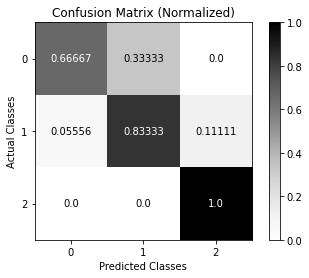

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.8255858836503998


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       0.92      0.67      0.77        18
Atypical Nevus       0.71      0.83      0.77        18
      Melanoma       0.88      1.00      0.93        14

      accuracy                           0.82        50
     macro avg       0.84      0.83      0.83        50
  weighted avg       0.83      0.82      0.82        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

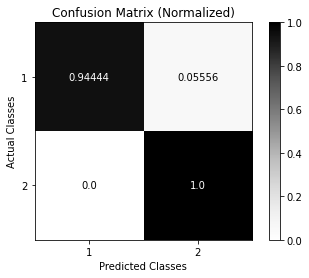

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.9523809523809523


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       1.00      0.94      0.97        36
            Melanoma       0.88      1.00      0.93        14

            accuracy                           0.96        50
           macro avg       0.94      0.97      0.95        50
        weighted avg       0.96      0.96      0.96        50

